In [1]:
from spleeter.separator import Separator
import os
import librosa
from swift_f0 import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import compiam
from typing import Optional, Tuple
from swift_f0 import (
    SwiftF0,
    PitchResult,
    plot_pitch,
    export_to_csv,
    segment_notes,
    plot_notes,
    plot_pitch_and_notes,
    export_to_midi,
)
vocal_note_sequence = None

# Enhanced pitch processing functions

Defines smoothing, stationary point detection, peak detection and other helper functions used to segment pitch contours into musical notes; prints a loaded confirmation.

In [2]:
# Enhanced pitch processing functions for better note transcription
from scipy import ndimage
from scipy.signal import medfilt, find_peaks
import copy

def smooth_pitch_contour(pitch_result, method='gaussian', sigma=1.0, snap_to_semitones=True):
    """
    Apply frequency domain smoothing to pitch contour.
    
    Parameters:
    - pitch_result: PitchResult object from SwiftF0
    - method: 'gaussian', 'median', 'quantile_snap'
    - sigma: Standard deviation for Gaussian smoothing (in semitones)
    - snap_to_semitones: Whether to snap to nearest semitone after smoothing
    """
    
    pitch_hz = getattr(pitch_result, 'pitch_hz', np.array([]))
    voicing = getattr(pitch_result, 'voicing', np.ones_like(pitch_hz, dtype=bool))
    
    if len(pitch_hz) == 0:
        return pitch_result
    
    # Convert to MIDI for processing (easier to work in semitone space)
    pitch_midi = np.zeros_like(pitch_hz)
    voiced_mask = (pitch_hz > 0) & voicing
    
    if not np.any(voiced_mask):
        return pitch_result
    
    pitch_midi[voiced_mask] = librosa.hz_to_midi(pitch_hz[voiced_mask])
    
    if method == 'gaussian':
        # Gaussian smoothing in MIDI space
        smoothed_midi = np.copy(pitch_midi)
        
        # Only smooth voiced regions
        if np.any(voiced_mask):
            # Apply Gaussian filter only to voiced frames
            voiced_midi = pitch_midi[voiced_mask]
            smoothed_voiced = ndimage.gaussian_filter1d(voiced_midi, sigma=sigma)
            smoothed_midi[voiced_mask] = smoothed_voiced
            
    elif method == 'median':
        # Median filtering to remove outliers
        kernel_size = max(3, int(sigma * 2) | 1)  # Ensure odd kernel size
        smoothed_midi = np.copy(pitch_midi)
        if np.any(voiced_mask):
            voiced_midi = pitch_midi[voiced_mask]
            smoothed_voiced = medfilt(voiced_midi, kernel_size=kernel_size)
            smoothed_midi[voiced_mask] = smoothed_voiced
            
    elif method == 'quantile_snap':
        # Snap to most common nearby frequencies
        smoothed_midi = quantile_snap_frequencies(pitch_midi, voiced_mask, window_size=int(sigma))
    
    # Snap to semitones if requested
    if snap_to_semitones:
        smoothed_midi[voiced_mask] = np.round(smoothed_midi[voiced_mask])
    
    # Convert back to Hz
    smoothed_hz = np.zeros_like(pitch_hz)
    smoothed_hz[voiced_mask] = librosa.midi_to_hz(smoothed_midi[voiced_mask])
    
    # Create new PitchResult with smoothed frequencies
    smoothed_result = copy.deepcopy(pitch_result)
    smoothed_result.pitch_hz = smoothed_hz
    
    return smoothed_result

def quantile_snap_frequencies(pitch_midi, voiced_mask, window_size=10, quantile_threshold=0.3):
    """Snap frequencies to locally common values using sliding window quantiles."""
    smoothed = np.copy(pitch_midi)
    
    if not np.any(voiced_mask):
        return smoothed
    
    voiced_indices = np.where(voiced_mask)[0]
    
    for i, idx in enumerate(voiced_indices):
        # Define local window
        start_win = max(0, i - window_size // 2)
        end_win = min(len(voiced_indices), i + window_size // 2 + 1)
        
        window_indices = voiced_indices[start_win:end_win]
        window_freqs = pitch_midi[window_indices]
        
        # Find most common frequency in window (round to nearest semitone)
        rounded_freqs = np.round(window_freqs)
        unique_freqs, counts = np.unique(rounded_freqs, return_counts=True)
        
        if len(unique_freqs) > 0:
            # Use most common frequency if it appears frequently enough
            max_count_idx = np.argmax(counts)
            if counts[max_count_idx] >= len(window_freqs) * quantile_threshold:
                smoothed[idx] = unique_freqs[max_count_idx]
    
    return smoothed

def detect_pitch_stationary_points(pitch_result, min_stability_duration=0.01, 
                                 pitch_change_threshold=0.5, derivative_threshold=0.1):
    """
    Detect notes at stationary points in pitch contour rather than fixed durations.
    
    Parameters:
    - pitch_result: PitchResult with smoothed frequencies
    - min_stability_duration: Minimum time a pitch must be stable (seconds)
    - pitch_change_threshold: Minimum pitch change to consider a new note (semitones)
    - derivative_threshold: Maximum pitch derivative for "stationary" regions (semitones/second)
    """
    
    pitch_hz = getattr(pitch_result, 'pitch_hz', np.array([]))
    timestamps = getattr(pitch_result, 'timestamps', None)
    voicing = getattr(pitch_result, 'voicing', np.ones_like(pitch_hz, dtype=bool))
    frame_period = getattr(pitch_result, 'frame_period', 0.01)
    
    if timestamps is None:
        timestamps = np.arange(len(pitch_hz)) * frame_period
    
    if len(pitch_hz) == 0:
        return []
    
    # Convert to MIDI and get voiced frames
    voiced_mask = (pitch_hz > 0) & voicing
    if not np.any(voiced_mask):
        return []
    
    voiced_times = timestamps[voiced_mask]
    voiced_midi = librosa.hz_to_midi(pitch_hz[voiced_mask])
    
    # Calculate pitch derivative (rate of change)
    dt = np.diff(voiced_times)
    dt[dt == 0] = frame_period  # Avoid division by zero
    pitch_derivative = np.abs(np.diff(voiced_midi)) / dt
    
    # Find stationary regions (low derivative)
    stationary_mask = np.concatenate([[True], pitch_derivative < derivative_threshold, [True]])
    stationary_regions = find_continuous_regions(stationary_mask)
    
    notes = []
    
    for start_idx, end_idx in stationary_regions:
        if end_idx <= start_idx:
            continue
            
        # Ensure indices are within bounds
        start_idx = max(0, start_idx)
        end_idx = min(len(voiced_times), end_idx)
        
        if end_idx <= start_idx:
            continue
            
        # Check if region is long enough
        region_duration = voiced_times[end_idx-1] - voiced_times[start_idx]
        if region_duration < min_stability_duration:
            continue
        
        # Calculate representative pitch for this region
        region_midi = voiced_midi[start_idx:end_idx]
        region_times = voiced_times[start_idx:end_idx]
        
        # Use median pitch (robust to outliers)
        representative_midi = np.median(region_midi)
        
        # Check if this represents a significant pitch change from previous note
        if notes and abs(representative_midi - notes[-1]['pitch_midi']) < pitch_change_threshold:
            # Merge with previous note
            notes[-1]['end'] = region_times[-1]
            notes[-1]['pitch_midi'] = np.median([notes[-1]['pitch_midi'], representative_midi])
            notes[-1]['pitch_hz'] = librosa.midi_to_hz(notes[-1]['pitch_midi'])
        else:
            # Create new note
            # Fix confidence calculation to handle indexing properly
            confidence_values = getattr(pitch_result, 'confidence', np.ones_like(pitch_hz))
            if len(confidence_values) > 0 and np.any(voiced_mask):
                voiced_confidence = confidence_values[voiced_mask]
                conf_start = min(start_idx, len(voiced_confidence) - 1)
                conf_end = min(end_idx, len(voiced_confidence))
                region_confidence = np.mean(voiced_confidence[conf_start:conf_end]) if conf_end > conf_start else 1.0
            else:
                region_confidence = 1.0
                
            notes.append({
                'start': region_times[0],
                'end': region_times[-1],
                'pitch_midi': representative_midi,
                'pitch_hz': librosa.midi_to_hz(representative_midi),
                'pitch_median': librosa.midi_to_hz(representative_midi),
                'confidence': region_confidence
            })
    
    return notes

def find_continuous_regions(mask):
    """Find continuous True regions in boolean mask."""
    diff = np.diff(np.concatenate([[False], mask, [False]]).astype(int))
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]
    return list(zip(starts, ends))

def detect_melodic_peaks_and_stable_regions(pitch_result, peak_prominence=1.0, 
                                          stable_region_min_duration=0.15):
    """
    Detect both melodic peaks (for fast ornaments) and stable regions (for sustained notes).
    """
    
    pitch_hz = getattr(pitch_result, 'pitch_hz', np.array([]))
    timestamps = getattr(pitch_result, 'timestamps', None)
    voicing = getattr(pitch_result, 'voicing', np.ones_like(pitch_hz, dtype=bool))
    frame_period = getattr(pitch_result, 'frame_period', 0.01)
    
    if timestamps is None:
        timestamps = np.arange(len(pitch_hz)) * frame_period
    
    voiced_mask = (pitch_hz > 0) & voicing
    if not np.any(voiced_mask):
        return []
    
    voiced_times = timestamps[voiced_mask]
    voiced_midi = librosa.hz_to_midi(pitch_hz[voiced_mask])
    
    # Smooth for peak detection
    smoothed_midi = ndimage.gaussian_filter1d(voiced_midi, sigma=2)
    
    # Find peaks (local maxima) and valleys (local minima)
    peaks, _ = find_peaks(smoothed_midi, prominence=peak_prominence)
    valleys, _ = find_peaks(-smoothed_midi, prominence=peak_prominence)
    
    # Combine and sort all significant points
    significant_points = np.sort(np.concatenate([peaks, valleys]))
    
    notes = []
    
    # Convert peaks/valleys to notes
    for i, point_idx in enumerate(significant_points):
        # Define note boundaries
        if i == 0:
            start_idx = 0
        else:
            start_idx = (significant_points[i-1] + point_idx) // 2
            
        if i == len(significant_points) - 1:
            end_idx = len(voiced_midi) - 1
        else:
            end_idx = (point_idx + significant_points[i+1]) // 2
        
        # Ensure indices are within bounds
        start_idx = max(0, start_idx)
        end_idx = min(len(voiced_times) - 1, end_idx)
        
        if end_idx <= start_idx:
            continue
        
        # Check minimum duration
        duration = voiced_times[end_idx] - voiced_times[start_idx]
        if duration < 0.05:  # Very short minimum for ornaments
            continue
        
        # Create note
        pitch_midi = smoothed_midi[point_idx]
        
        # Fix confidence calculation to handle indexing properly
        confidence_values = getattr(pitch_result, 'confidence', np.ones_like(pitch_hz))
        if len(confidence_values) > 0 and np.any(voiced_mask):
            voiced_confidence = confidence_values[voiced_mask]
            conf_start = min(start_idx, len(voiced_confidence) - 1)
            conf_end = min(end_idx, len(voiced_confidence))
            region_confidence = np.mean(voiced_confidence[conf_start:conf_end]) if conf_end > conf_start else 1.0
        else:
            region_confidence = 1.0
            
        notes.append({
            'start': voiced_times[start_idx],
            'end': voiced_times[end_idx],
            'pitch_midi': pitch_midi,
            'pitch_hz': librosa.midi_to_hz(pitch_midi),
            'pitch_median': librosa.midi_to_hz(pitch_midi),
            'is_ornament': duration < stable_region_min_duration,
            'confidence': region_confidence
        })
    
    return notes

print("Enhanced pitch processing functions loaded!")

Enhanced pitch processing functions loaded!


# Stem separation and path setup

Set audio file path, optionally run spleeter separation (creates `separated_stems/<filename>`), and compute paths for `vocals.wav` and `accompaniment.wav` used later.

In [8]:
audio_path = '/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/audio_test_files/venkatesh_marubihag_aalap.mp3'
tonic = 'D#'
raga_name = 'Maru Bihag'

# inputs
# audio_path = '/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/RagaDataset/Hindustani/audio/Gaud Malhar/Gaud Malhar_9.mp3'
fusion = False  # whether song is fusion or pure classical
output_dir = '/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/files/separated_stems/htdemucs' # saved stems directory
instrument_mode = 'autodetect'

filename = os.path.splitext(os.path.basename(audio_path))[0]
stem_dir = os.path.join(output_dir, filename)

# only run separation if the folder doesn't already exist
if not os.path.isdir(stem_dir):
    separator = Separator('spleeter:2stems')
    separator.separate_to_file(audio_path, output_dir, codec='mp3')
else:
    print(f"Skipping separation: '{stem_dir}' already exists.")

# set the paths
vocals_path = os.path.join(stem_dir, 'vocals.mp3')
accompaniment_path = os.path.join(stem_dir, 'accompaniment.mp3')

print("Vocals:", vocals_path)
print("Accompaniment:", accompaniment_path)


Skipping separation: '/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/files/separated_stems/htdemucs/venkatesh_marubihag_aalap' already exists.
Vocals: /Users/saumyamishra/Desktop/intern/summer25/RagaDetection/files/separated_stems/htdemucs/venkatesh_marubihag_aalap/vocals.mp3
Accompaniment: /Users/saumyamishra/Desktop/intern/summer25/RagaDetection/files/separated_stems/htdemucs/venkatesh_marubihag_aalap/accompaniment.mp3


# Load CSV → PitchResult and analysis wrapper

Utilities to load swift-f0 CSVs into a `PitchResult`, apply confidence overrides, and `analyze_or_load_with_plots()` which runs detection, smoothing, plotting and exports MIDI and histograms.

In [9]:
def load_swiftf0_csv_as_pitchresult(csv_path: str, silent: bool = False) -> PitchResult:
    """Load a CSV exported by swift-f0 and return a defensive PitchResult instance."""
    df = pd.read_csv(csv_path)
    # accept 'time' or 'timestamp' for timing, 'voiced' or 'voicing' for voiced flag
    ts_col = "time" if "time" in df.columns else ("timestamp" if "timestamp" in df.columns else None)

    pitch_col = "pitch_hz" if "pitch_hz" in df.columns else None
    conf_col = "confidence" if "confidence" in df.columns else None
    voiced_col = "voicing" if "voicing" in df.columns else ("voiced" if "voiced" in df.columns else None)

    if pitch_col is None or conf_col is None:
        raise ValueError(f"CSV {csv_path} missing required columns. Found: {list(df.columns)}")

    timestamps = pd.to_numeric(df[ts_col], errors="coerce").to_numpy() if ts_col else np.arange(len(df)).astype(float)
    pitch_hz = pd.to_numeric(df[pitch_col], errors="coerce").to_numpy()
    pitch_hz = np.nan_to_num(pitch_hz, nan=0.0)
    confidence = pd.to_numeric(df[conf_col], errors="coerce").to_numpy()
    confidence = np.nan_to_num(confidence, nan=0.0)

    if voiced_col:
        voiced_raw = df[voiced_col].astype(str).fillna("").str.strip().str.lower()

        def parse_bool(x: str) -> bool:
            if x == "" or x == "nan":
                return False
            if x in ("1", "1.0", "true", "t", "yes", "y"):
                return True
            if x in ("0", "0.0", "false", "f", "no", "n"):
                return False
            try:
                return bool(int(float(x)))
            except Exception:
                return False

        voiced = np.array([parse_bool(x) for x in voiced_raw], dtype=bool)
    else:
        voiced = (pitch_hz > 0) & (confidence > 0)

    # frame_period if available via 'frame_rate' or infer from timestamps
    frame_period = None
    if "frame_rate" in df.columns:
        try:
            frame_period = 1.0 / float(df["frame_rate"].iloc[0])
        except Exception:
            frame_period = None
    elif ts_col:
        times = pd.to_numeric(df[ts_col], errors="coerce").to_numpy()
        if len(times) > 1:
            diffs = np.diff(times[: min(50, len(times))])
            frame_period = float(np.median(diffs)) if diffs.size else None

    pr = PitchResult(pitch_hz=pitch_hz, confidence=confidence, timestamps=timestamps, voicing=voiced)
    setattr(pr, "frame_period", frame_period)
    if not silent:
        print(
            f"[LOAD CSV] {os.path.basename(csv_path)} -> PitchResult (frames={len(pitch_hz)}, voiced={int(voiced.sum())})"
        )
    return pr


def _apply_override_confidence(pr: PitchResult, threshold: float) -> None:
    """Replace/override pr.voicing using the provided confidence threshold."""
    conf = getattr(pr, "confidence", None)
    pitch = getattr(pr, "pitch_hz", None)
    if conf is None or pitch is None or len(conf) != len(pitch):
        print("[WARN] Cannot apply override_confidence_threshold: inconsistent or missing arrays.")
        return
    new_voicing = (pitch > 0) & (conf >= threshold)
    setattr(pr, "voicing", new_voicing)
    print(f"[INFO] Applied override_confidence_threshold = {threshold} (voiced frames = {int(new_voicing.sum())})")


def analyze_or_load_with_plots(
    stem_path: str,
    detector: SwiftF0,
    output_prefix: str = "output",
    num_bins: int = 25,
    save_midi: bool = True,
    force_recompute: bool = False,
    store_as_vocal: bool = False,
    start_time: float = 0.0,
    duration: Optional[float] = None,
    override_confidence_threshold: Optional[float] = None,
) -> Tuple[PitchResult, np.ndarray, np.ndarray, np.ndarray]:
    """
    Main pipeline wrapper.
    - If <stem_dir>/<output_prefix>_pitch_data.csv exists and force_recompute is False -> load CSV.
      Otherwise run SwiftF0 on the audio slice (offset=start_time, duration=duration).
    - Optionally override voicing via override_confidence_threshold (applied even when CSV is loaded).
    - Runs plotting, segmentation, MIDI export and returns (pr, valid_frequencies, cent_hist, midi_vals).
    """
    global vocal_note_sequence

    stem_dir = os.path.dirname(stem_path) or "."
    csv_path = os.path.join(stem_dir, f"{output_prefix}_pitch_data.csv")
    midi_npy_path = os.path.join(stem_dir, f"{output_prefix}_midi.npy")
    midi_csv_path = os.path.join(stem_dir, f"{output_prefix}_midi.csv")

    pr: Optional[PitchResult] = None
    sr: Optional[int] = None

    if os.path.isfile(csv_path) and not force_recompute:
        try:
            pr = load_swiftf0_csv_as_pitchresult(csv_path)
        except Exception as e:
            print(f"[WARN] Failed to load CSV {csv_path}: {e}. Will recompute.")
            pr = None

    # run detector if needed
    if pr is None:
        print(f"[RUN] Running SwiftF0 for {stem_path} (start={start_time}, duration={duration})")
        y, sr = librosa.load(stem_path, sr=None, offset=start_time, duration=duration)
        pr = detector.detect_from_array(y, sr)
        try:
            export_to_csv(pr, csv_path)
            print(f"[WRITE] Exported CSV: {csv_path}")
        except Exception as e:
            print(f"[WARN] export_to_csv failed: {e}")

    # override voicing using confidence (works whether loaded or recomputed)
    if override_confidence_threshold is not None:
        _apply_override_confidence(pr, override_confidence_threshold)

    # plot pitch (always run to update visuals)
    try:
        plot_pitch(pr, show=False, output_path=os.path.join(stem_dir, f"{output_prefix}_pitch.jpg"))
    except Exception as e:
        print(f"[WARN] plot_pitch failed: {e}")

    # Enhanced note segmentation with frequency smoothing + stationary point detection
    notes = []
    try:
        # Apply frequency smoothing first
        print(f"[SMOOTH] Applying {SMOOTHING_METHOD} smoothing to pitch contour...")
        smoothed_pr = smooth_pitch_contour(pr, method=SMOOTHING_METHOD, sigma=SMOOTHING_SIGMA, snap_to_semitones=SNAP_TO_SEMITONES)
        
        # Choose detection method based on configuration
        if USE_PEAK_DETECTION:
            print(f"[SEGMENT] Using peak-based detection for note segmentation...")
            note_dicts = detect_melodic_peaks_and_stable_regions(
                smoothed_pr,
                peak_prominence=PEAK_PROMINENCE,
                stable_region_min_duration=STABLE_REGION_MIN_DURATION
            )
        else:
            print(f"[SEGMENT] Using stationary point detection for note segmentation...")
            note_dicts = detect_pitch_stationary_points(
                smoothed_pr, 
                min_stability_duration=MIN_STABILITY_DURATION,
                pitch_change_threshold=PITCH_CHANGE_THRESHOLD,
                derivative_threshold=DERIVATIVE_THRESHOLD
            )
        
        # Convert to the format expected by downstream code (objects with attributes)
        notes = []
        for note_dict in note_dicts:
            # Create a simple note object with the required attributes
            note_obj = type('Note', (), {})()
            note_obj.start = note_dict['start']
            note_obj.end = note_dict['end']
            note_obj.pitch_hz = note_dict['pitch_hz']
            note_obj.pitch_median = note_dict['pitch_median']
            note_obj.pitch_midi = note_dict['pitch_midi']
            note_obj.confidence = note_dict.get('confidence', 1.0)
            if 'is_ornament' in note_dict:
                note_obj.is_ornament = note_dict['is_ornament']
            notes.append(note_obj)
        
        print(f"[INFO] Detected {len(notes)} notes using {'peak-based' if USE_PEAK_DETECTION else 'stationary point'} method")

        if store_as_vocal:
            vocal_note_sequence = [
                {"start": note.start, "end": note.end, "pitch_hz": note.pitch_median, "midi_note": note.pitch_midi}
                for note in notes
            ]

        try:
            plot_notes(notes, output_path=os.path.join(stem_dir, f"{output_prefix}_note_segments.jpg"))
        except Exception as e:
            print(f"[WARN] plot_notes failed: {e}")

        try:
            plot_pitch_and_notes(pr, notes, output_path=os.path.join(stem_dir, f"{output_prefix}_combined_analysis.jpg"))
        except Exception as e:
            print(f"[WARN] plot_pitch_and_notes failed: {e}")

        try:
            export_to_midi(notes, os.path.join(stem_dir, f"{output_prefix}_notes.mid"))
        except Exception as e:
            print(f"[WARN] export_to_midi failed: {e}")

    except Exception as e:
        print(f"[WARN] segment_notes failed or returned no notes: {e}")
        notes = []

    # Extract voiced frames robustly
    voiced_mask = getattr(pr, "voicing", None)
    pitch_hz_arr = getattr(pr, "pitch_hz", np.array([], dtype=float))
    conf_arr = getattr(pr, "confidence", None)

    if voiced_mask is not None and len(voiced_mask) == len(pitch_hz_arr):
        voiced_freqs = pitch_hz_arr[voiced_mask]
        voiced_confs = conf_arr[voiced_mask] if conf_arr is not None else np.ones_like(voiced_freqs)
    else:
        voiced_freqs = pitch_hz_arr
        voiced_confs = conf_arr if conf_arr is not None else np.ones_like(voiced_freqs)

    # Filter positives
    valid_mask = voiced_freqs > 0
    valid_frequencies = voiced_freqs[valid_mask]
    valid_confidences = voiced_confs[valid_mask] if np.size(voiced_confs) else np.array([])

    # Frame duration
    frame_period = getattr(pr, "frame_period", None)
    if frame_period is None:
        if sr is not None:
            frame_period = 512.0 / float(sr)
        else:
            frame_period = 0.01
    weights = (valid_confidences * frame_period) if valid_confidences.size else np.array([])

    # MIDI values (load or compute and save)
    midi_vals = None
    if save_midi and os.path.isfile(midi_npy_path) and not force_recompute:
        try:
            midi_vals = np.load(midi_npy_path)
            print(f"[LOAD] MIDI npy loaded: {midi_npy_path} (len={len(midi_vals)})")
        except Exception as e:
            print(f"[WARN] Failed to load MIDI npy: {e}. Will recompute MIDI.")
            midi_vals = None

    if midi_vals is None:
        if valid_frequencies.size:
            midi_vals = librosa.hz_to_midi(valid_frequencies)
        else:
            midi_vals = np.array([], dtype=float)
        if save_midi:
            try:
                np.save(midi_npy_path, midi_vals)
                pd.DataFrame({"midi": np.round(midi_vals, 6)}).to_csv(midi_csv_path, index=False)
                print(f"[WRITE] Saved MIDI -> {midi_npy_path}, {midi_csv_path}")
            except Exception as e:
                print(f"[WARN] Failed to save MIDI files: {e}")

    # MIDI summary
    if midi_vals.size:
        midi_preview = np.round(midi_vals[:40], 2).tolist()
        pitch_classes = np.mod(np.round(midi_vals), 12).astype(int)
        print(f"\n{output_prefix} — voiced (valid) frames: {len(midi_vals)}")
        print("MIDI preview (first up to 40):", midi_preview)
        print("Unique pitch-classes:", sorted(np.unique(pitch_classes).tolist()))
        print("MIDI mean {:.2f}, median {:.2f}, std {:.2f}\n".format(np.mean(midi_vals), np.median(midi_vals), np.std(midi_vals)))
    else:
        print(f"\n{output_prefix} — no valid voiced frames found. MIDI empty.\n")

    # Cent histogram (weighted) and save plots
    if valid_frequencies.size:
        midi_vals_full = librosa.hz_to_midi(valid_frequencies)
        cent_values = (midi_vals_full % 12) * 100.0
        cent_hist, _ = np.histogram(cent_values, bins=num_bins, range=(0, 1200), weights=weights if weights.size else None)
    else:
        cent_hist = np.zeros(num_bins, dtype=float)

    bin_width = 1200.0 / num_bins
    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(num_bins), cent_hist, width=1.0, alpha=0.8)
    plt.title(f"{output_prefix}: Weighted Cent Histogram ({num_bins} bins, {bin_width:.1f}¢/bin)")
    plt.xlabel("Bin index")
    plt.ylabel("Weighted Seconds")
    step = max(1, num_bins // 12)
    ticks = np.arange(0, num_bins, step)
    labels = [f"{int(i * bin_width)}¢" for i in ticks]
    plt.xticks(ticks=ticks, labels=labels, rotation=45)
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(stem_dir, f"{output_prefix}_cent_histogram.jpg"))
    plt.show()
    plt.close()

    # Frequency histogram
    plt.figure(figsize=(12, 4))
    plt.hist(valid_frequencies, bins=1200, alpha=0.8, weights=weights if weights.size else None)
    plt.title(f"{output_prefix}: Weighted Frequency Histogram of Voiced Frames")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Weighted Seconds")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(stem_dir, f"{output_prefix}_frequency_histogram.jpg"))
    plt.show()
    plt.close()

    return pr, valid_frequencies, cent_hist, midi_vals


# Configuration settings for analysis

Set global configuration variables used by the pipeline (smoothing method, thresholds, peak vs stationary detection, and other tuning parameters). Change these to experiment.

In [10]:
# Smoothing parameters
SMOOTHING_METHOD = 'gaussian'  # Options: 'gaussian', 'median', 'quantile_snap'
SMOOTHING_SIGMA = 1.5  # For gaussian: std dev in semitones; for median: kernel size factor
SNAP_TO_SEMITONES = True  # Whether to snap frequencies to nearest semitones

# Stationary point detection parameters
MIN_STABILITY_DURATION = 0.1  # Minimum time a pitch must be stable (seconds)
PITCH_CHANGE_THRESHOLD = 0.3  # Minimum pitch change to consider a new note (semitones)
DERIVATIVE_THRESHOLD = 0.15  # Maximum pitch derivative for "stationary" regions (semitones/second)

# Alternative: Peak-based detection parameters (for handling fast ornaments like taans)
USE_PEAK_DETECTION = False  # Set to True to use peak detection instead of stationary points
PEAK_PROMINENCE = 1.0  # Minimum prominence for melodic peaks (semitones)
STABLE_REGION_MIN_DURATION = 0.15  # Threshold between ornaments and sustained notes

print("Configuration loaded:")
print(f"  Smoothing: {SMOOTHING_METHOD} (sigma={SMOOTHING_SIGMA}, snap={SNAP_TO_SEMITONES})")
print(f"  Detection: {'Peak-based' if USE_PEAK_DETECTION else 'Stationary points'}")
if not USE_PEAK_DETECTION:
    print(f"    Min stability: {MIN_STABILITY_DURATION}s, Change threshold: {PITCH_CHANGE_THRESHOLD} semitones")
    print(f"    Derivative threshold: {DERIVATIVE_THRESHOLD} semitones/sec")
else:
    print(f"    Peak prominence: {PEAK_PROMINENCE} semitones")
    print(f"    Ornament threshold: {STABLE_REGION_MIN_DURATION}s")

Configuration loaded:
  Smoothing: gaussian (sigma=1.5, snap=True)
  Detection: Stationary points
    Min stability: 0.1s, Change threshold: 0.3 semitones
    Derivative threshold: 0.15 semitones/sec


# Configuration: smoothing & detection parameters

Set global parameters used by the enhanced processing pipeline (smoothing method, thresholds, detection modes). Modify these to experiment with behavior.

In [11]:
# Analysis and comparison functions for different note detection methods

def compare_note_detection_methods(pitch_result, output_prefix="comparison"):
    """
    Compare different note detection methods and visualize the results.
    """
    print("=== Comparing Note Detection Methods ===")
    
    # Method 1: Original duration-based segmentation
    try:
        from swift_f0 import segment_notes
        original_notes = segment_notes(pitch_result, split_semitone_threshold=0.8, min_note_duration=0.1)
        print(f"Original method: {len(original_notes)} notes")
    except:
        print("Original segment_notes not available")
        original_notes = []
    
    # Method 2: Gaussian smoothing + stationary points
    smoothed_pr_gaussian = smooth_pitch_contour(pitch_result, method='gaussian', sigma=1.5, snap_to_semitones=True)
    stationary_notes = detect_pitch_stationary_points(
        smoothed_pr_gaussian, 
        min_stability_duration=0.1,
        pitch_change_threshold=0.3,
        derivative_threshold=0.15
    )
    print(f"Stationary points method: {len(stationary_notes)} notes")
    
    # Method 3: Peak-based detection
    peak_notes = detect_melodic_peaks_and_stable_regions(
        smoothed_pr_gaussian,
        peak_prominence=1.0,
        stable_region_min_duration=0.15
    )
    print(f"Peak-based method: {len(peak_notes)} notes")
    
    # Method 4: Median smoothing + stationary points
    smoothed_pr_median = smooth_pitch_contour(pitch_result, method='median', sigma=3, snap_to_semitones=True)
    median_stationary_notes = detect_pitch_stationary_points(
        smoothed_pr_median, 
        min_stability_duration=0.1,
        pitch_change_threshold=0.3,
        derivative_threshold=0.15
    )
    print(f"Median smoothing + stationary: {len(median_stationary_notes)} notes")
    
    # Analyze note durations
    methods_data = {
        'Original': [note.end - note.start for note in original_notes],  # Note: original notes are objects
        'Stationary': [n['end'] - n['start'] for n in stationary_notes],  # Note: our notes are dictionaries
        'Peak-based': [n['end'] - n['start'] for n in peak_notes],
        'Median+Stationary': [n['end'] - n['start'] for n in median_stationary_notes]
    }
    
    # Plot comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Duration histograms
    ax1 = axes[0, 0]
    for method, durations in methods_data.items():
        if durations:
            ax1.hist(durations, alpha=0.6, label=f'{method} (n={len(durations)})', bins=20)
    ax1.set_xlabel('Note Duration (seconds)')
    ax1.set_ylabel('Count')
    ax1.set_title('Note Duration Distribution by Method')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Pitch contour with different smoothing
    ax2 = axes[0, 1]
    timestamps = getattr(pitch_result, 'timestamps', np.arange(len(pitch_result.pitch_hz)) * 0.01)
    voiced_mask = (pitch_result.pitch_hz > 0) & getattr(pitch_result, 'voicing', np.ones_like(pitch_result.pitch_hz, dtype=bool))
    
    if np.any(voiced_mask):
        ax2.plot(timestamps[voiced_mask], librosa.hz_to_midi(pitch_result.pitch_hz[voiced_mask]), 
                alpha=0.5, label='Original', linewidth=1)
        ax2.plot(timestamps[voiced_mask], librosa.hz_to_midi(smoothed_pr_gaussian.pitch_hz[voiced_mask]), 
                alpha=0.8, label='Gaussian Smoothed', linewidth=2)
        ax2.plot(timestamps[voiced_mask], librosa.hz_to_midi(smoothed_pr_median.pitch_hz[voiced_mask]), 
                alpha=0.8, label='Median Smoothed', linewidth=2)
    
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Pitch (MIDI)')
    ax2.set_title('Pitch Contour: Original vs Smoothed')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Note count comparison
    ax3 = axes[1, 0]
    method_names = list(methods_data.keys())
    note_counts = [len(durations) for durations in methods_data.values()]
    bars = ax3.bar(method_names, note_counts, alpha=0.7)
    ax3.set_ylabel('Number of Notes')
    ax3.set_title('Note Count by Detection Method')
    ax3.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars, note_counts):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(note_counts)*0.01, 
                str(count), ha='center', va='bottom')
    
    # Average note duration comparison
    ax4 = axes[1, 1]
    avg_durations = [np.mean(durations) if durations else 0 for durations in methods_data.values()]
    bars = ax4.bar(method_names, avg_durations, alpha=0.7, color='orange')
    ax4.set_ylabel('Average Note Duration (seconds)')
    ax4.set_title('Average Note Duration by Method')
    ax4.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, avg_dur in zip(bars, avg_durations):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(avg_durations)*0.01, 
                f'{avg_dur:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    if output_prefix:
        plt.savefig(f"{output_prefix}_method_comparison.jpg", dpi=150, bbox_inches='tight')
    plt.show()
    
    return {
        'original': original_notes,
        'stationary': stationary_notes,
        'peak_based': peak_notes,
        'median_stationary': median_stationary_notes
    }

def analyze_pitch_derivatives(pitch_result, window_size=5):
    """
    Analyze pitch derivatives to help tune derivative_threshold parameter.
    """
    pitch_hz = pitch_result.pitch_hz
    timestamps = getattr(pitch_result, 'timestamps', np.arange(len(pitch_hz)) * 0.01)
    voicing = getattr(pitch_result, 'voicing', np.ones_like(pitch_hz, dtype=bool))
    
    voiced_mask = (pitch_hz > 0) & voicing
    if not np.any(voiced_mask):
        print("No voiced frames found")
        return
    
    voiced_times = timestamps[voiced_mask]
    voiced_midi = librosa.hz_to_midi(pitch_hz[voiced_mask])
    
    # Calculate derivatives
    dt = np.diff(voiced_times)
    dt[dt == 0] = 0.01
    derivatives = np.abs(np.diff(voiced_midi)) / dt
    
    # Smooth derivatives for analysis
    smoothed_derivatives = np.convolve(derivatives, np.ones(window_size)/window_size, mode='same')
    
    # Statistics
    print(f"Pitch Derivative Analysis:")
    print(f"  Mean: {np.mean(derivatives):.3f} semitones/sec")
    print(f"  Median: {np.median(derivatives):.3f} semitones/sec")
    print(f"  95th percentile: {np.percentile(derivatives, 95):.3f} semitones/sec")
    print(f"  99th percentile: {np.percentile(derivatives, 99):.3f} semitones/sec")
    
    # Suggested thresholds
    conservative_threshold = np.percentile(derivatives, 75)
    moderate_threshold = np.percentile(derivatives, 85)
    aggressive_threshold = np.percentile(derivatives, 95)
    
    print(f"\\nSuggested derivative thresholds:")
    print(f"  Conservative (more notes): {conservative_threshold:.3f}")
    print(f"  Moderate: {moderate_threshold:.3f}")
    print(f"  Aggressive (fewer notes): {aggressive_threshold:.3f}")
    
    # Plot
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(voiced_times[:-1], derivatives, alpha=0.6, label='Raw derivatives')
    plt.plot(voiced_times[:-1], smoothed_derivatives, alpha=0.8, label=f'Smoothed (window={window_size})')
    plt.axhline(conservative_threshold, color='green', linestyle='--', alpha=0.7, label=f'Conservative: {conservative_threshold:.2f}')
    plt.axhline(moderate_threshold, color='orange', linestyle='--', alpha=0.7, label=f'Moderate: {moderate_threshold:.2f}')
    plt.axhline(aggressive_threshold, color='red', linestyle='--', alpha=0.7, label=f'Aggressive: {aggressive_threshold:.2f}')
    plt.ylabel('|dPitch/dt| (semitones/sec)')
    plt.title('Pitch Derivatives Over Time')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.hist(derivatives, bins=50, alpha=0.7, density=True)
    plt.xlim(0, 100)
    plt.axvline(conservative_threshold, color='green', linestyle='--', alpha=0.7, label=f'Conservative: {conservative_threshold:.2f}')
    plt.axvline(moderate_threshold, color='orange', linestyle='--', alpha=0.7, label=f'Moderate: {moderate_threshold:.2f}')
    plt.axvline(aggressive_threshold, color='red', linestyle='--', alpha=0.7, label=f'Aggressive: {aggressive_threshold:.2f}')
    plt.xlabel('|dPitch/dt| (semitones/sec)')
    plt.ylabel('Density')
    plt.title('Distribution of Pitch Derivatives')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Analysis and comparison functions loaded!")

Analysis and comparison functions loaded!


-------Vocal analysis--------
[LOAD CSV] vocals_pitch_data.csv -> PitchResult (frames=8739, voiced=7469)
[INFO] Applied override_confidence_threshold = 0.9 (voiced frames = 7803)
[SMOOTH] Applying gaussian smoothing to pitch contour...
[SEGMENT] Using stationary point detection for note segmentation...
[INFO] Detected 60 notes using stationary point method


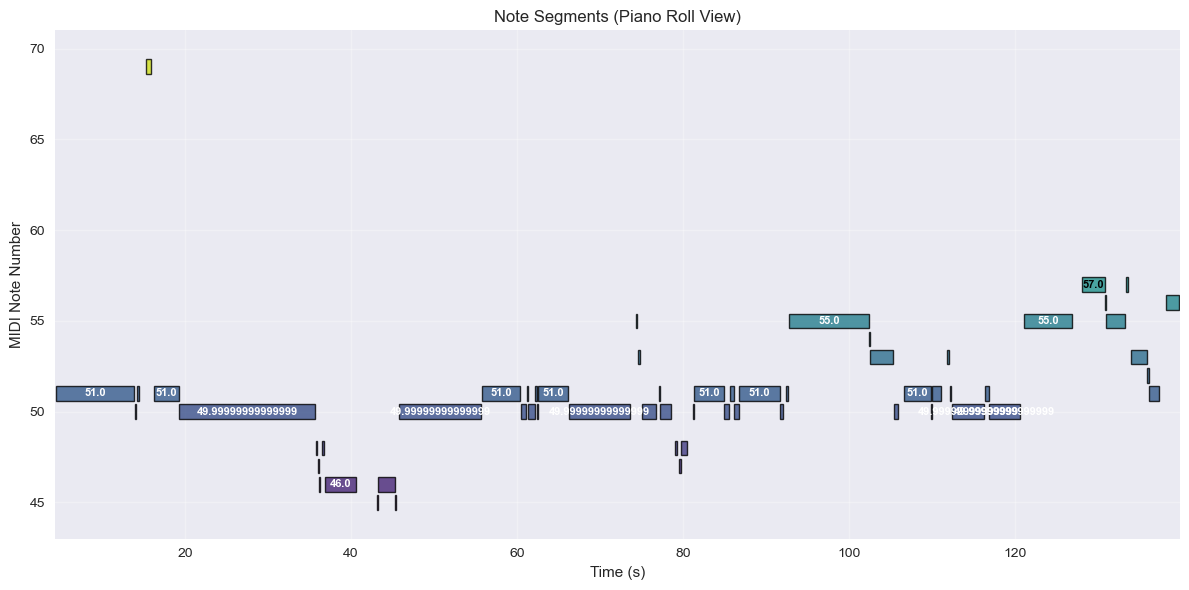

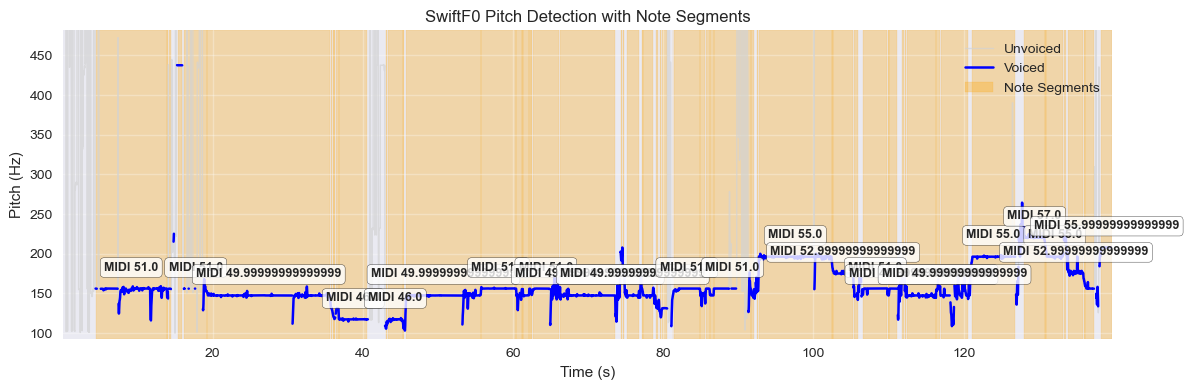

[WARN] export_to_midi failed: data byte must be int
[LOAD] MIDI npy loaded: /Users/saumyamishra/Desktop/intern/summer25/RagaDetection/files/separated_stems/htdemucs/venkatesh_marubihag_aalap/vocals_midi.npy (len=7485)

vocals — voiced (valid) frames: 7485
MIDI preview (first up to 40): [51.029998779296875, 51.029998779296875, 51.029998779296875, 51.029998779296875, 51.02000045776367, 51.040000915527344, 51.040000915527344, 51.04999923706055, 51.04999923706055, 51.04999923706055, 51.040000915527344, 51.040000915527344, 51.0099983215332, 51.040000915527344, 51.04999923706055, 51.04999923706055, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 

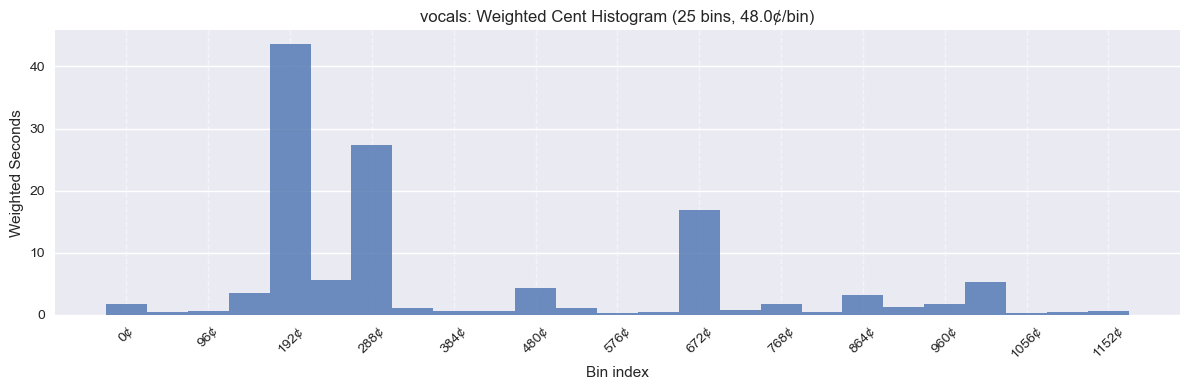

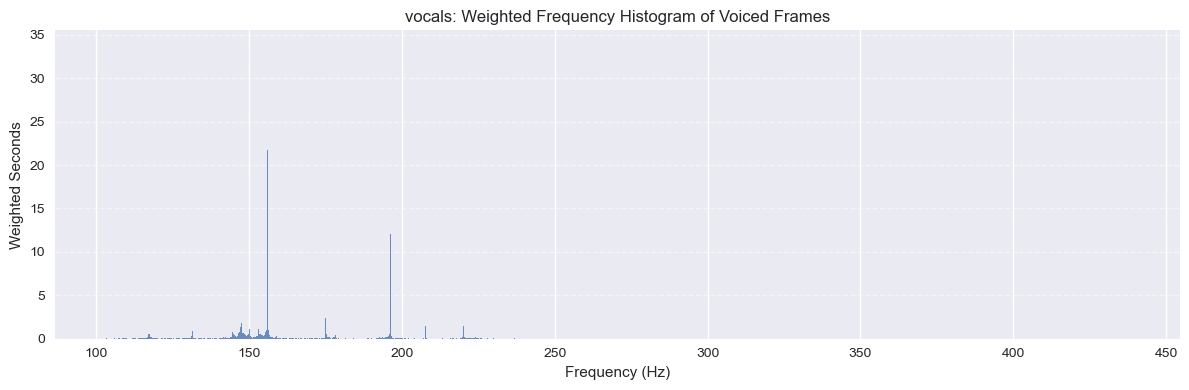

-------Accompaniment analysis --------
[LOAD CSV] accompaniment_pitch_data.csv -> PitchResult (frames=8739, voiced=4805)
[SMOOTH] Applying gaussian smoothing to pitch contour...
[SEGMENT] Using stationary point detection for note segmentation...
[INFO] Detected 57 notes using stationary point method


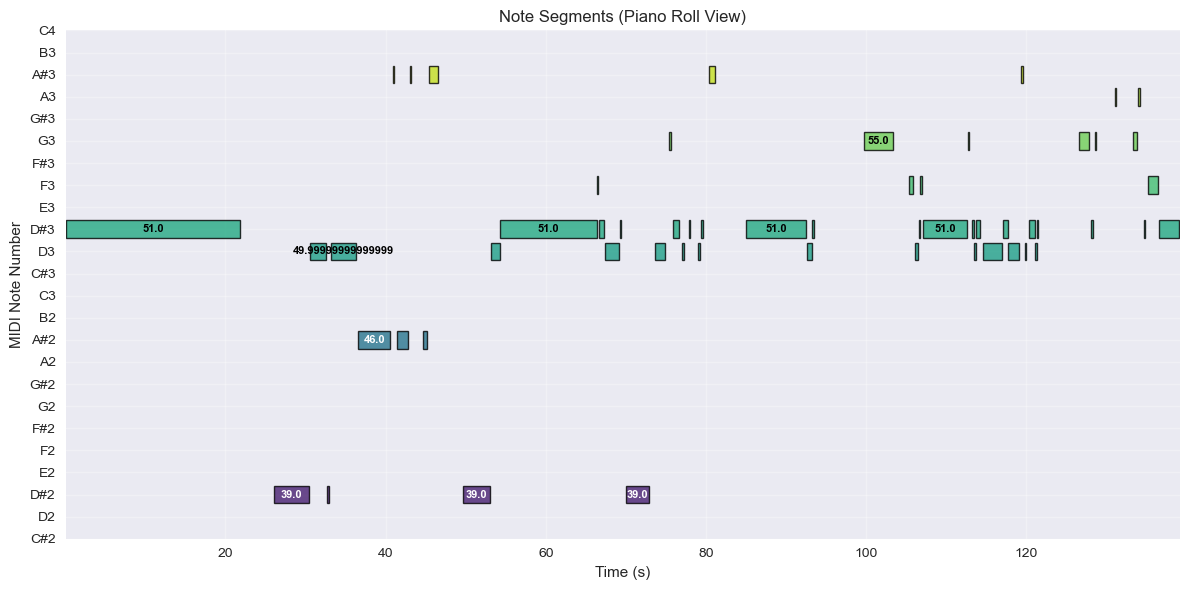

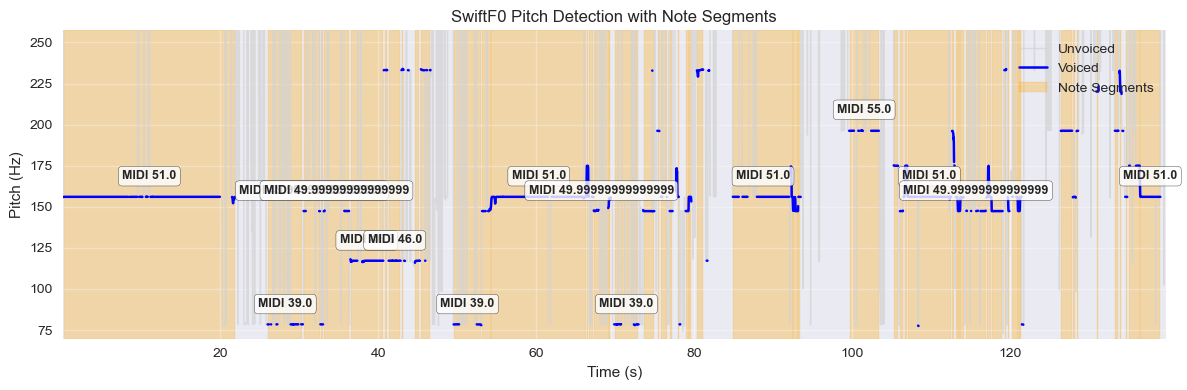

[WARN] export_to_midi failed: data byte must be int
[LOAD] MIDI npy loaded: /Users/saumyamishra/Desktop/intern/summer25/RagaDetection/files/separated_stems/htdemucs/venkatesh_marubihag_aalap/accompaniment_midi.npy (len=4805)

accompaniment — voiced (valid) frames: 4805
MIDI preview (first up to 40): [51.040000915527344, 51.04999923706055, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016, 51.060001373291016,

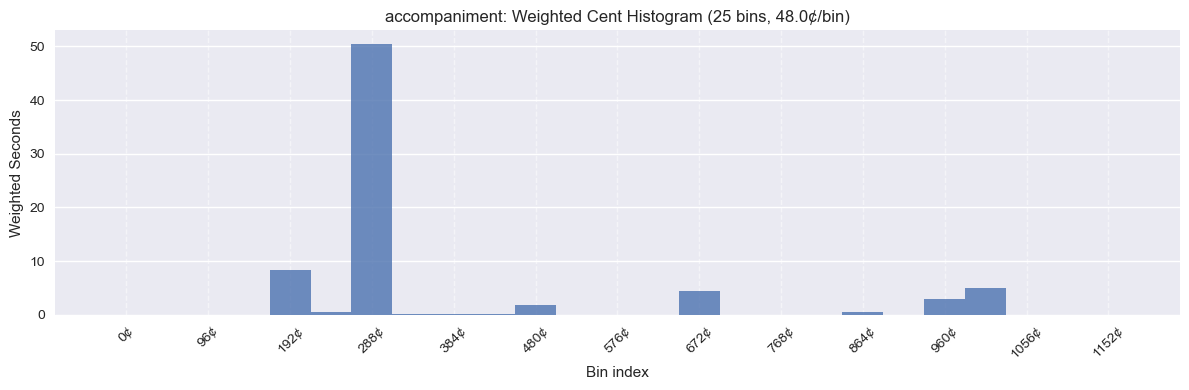

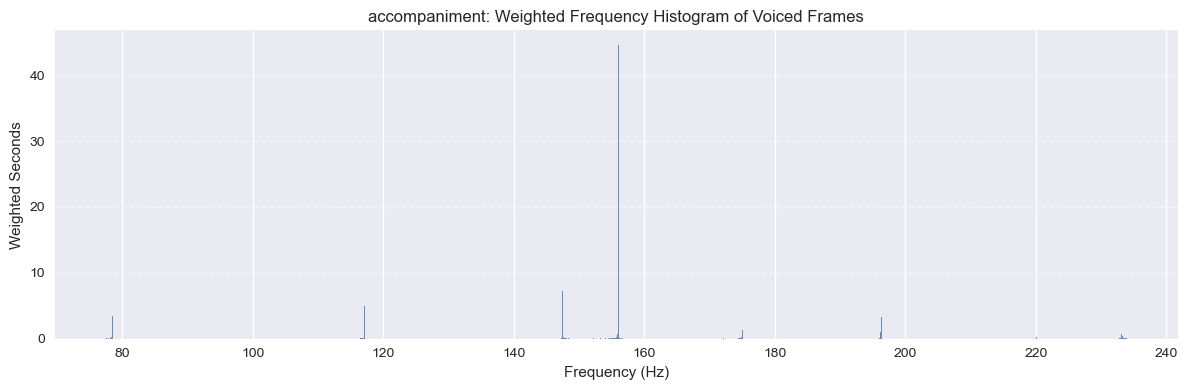

In [ ]:
if __name__ == "__main__":
    min_note_str = "B1"
    max_note_str = "C4"
    fmin_hz = librosa.note_to_hz(min_note_str)
    fmax_hz = librosa.note_to_hz(max_note_str)

    # vocal detector: can alter confidence_threshold here (affects detection if recomputing)
    detector_v = SwiftF0(fmin=fmin_hz, fmax=fmax_hz, confidence_threshold=0.9)
    print("-------Vocal analysis--------")
    result_v, valid_freqs_v, cent_hist_v, midi_vals_v = analyze_or_load_with_plots(
        vocals_path,
        detector_v,
        output_prefix="vocals",
        store_as_vocal=True,
        duration=10000.0,  # example: analyze only first 120s when recomputing
        override_confidence_threshold=0. 9,  # will re-threshold even if CSV loaded
    )

    detector_a = SwiftF0(fmin=fmin_hz, fmax=fmax_hz, confidence_threshold=0.8)
    print("-------Accompaniment analysis --------")
    result_a, valid_freqs_a, cent_hist_a, midi_vals_a = analyze_or_load_with_plots(
        accompaniment_path, detector_a, output_prefix="accompaniment"
    )

# Main analysis: run SwiftF0 on stems

Sets detector ranges, initializes SwiftF0 for vocal and accompaniment, and runs `analyze_or_load_with_plots()` to compute pitch, notes, histograms and MIDI for both stems.

In [13]:

_OFFSET_TO_SARGAM = {
    0:  ("Sa",  0, ""),           # 0
    1:  ("Re",  1, "komal"),      # 1
    2:  ("Re",  1, "shuddha"),    # 2
    3:  ("Ga",  2, "komal"),      # 3
    4:  ("Ga",  2, "shuddha"),    # 4
    5:  ("Ma",  3, "shuddha"),    # 5
    6:  ("Ma",  3, "tivra"),      # 6 
    7:  ("Pa",  4, ""),           # 7
    8:  ("Dha", 5, "komal"),      # 8
    9:  ("Dha", 5, "shuddha"),    # 9
    10: ("Ni",  6, "komal"),      # 10
    11: ("Ni",  6, "shuddha"),    # 11
}

def _tonic_to_midi_class(tonic):
    """
    Accepts tonic as:
      - int/float: treated as MIDI number (or MIDI class if you mod 12)
      - string like 'C#4' or 'D'  -> converted using librosa.note_to_midi
      - frequency in Hz (float)   -> convert to MIDI via librosa.hz_to_midi
    Returns integer 0..11 = tonic MIDI class
    """
    if tonic is None:
        raise ValueError("tonic must be provided (MIDI number, note name, or Hz)")
    # numeric -> treat as midi or hz heuristically
    if isinstance(tonic, (int, np.integer)):
        return int(tonic) % 12
    if isinstance(tonic, float) or (isinstance(tonic, np.floating)):
        # ambiguous: assume it's a MIDI if > 0 and < 128 and near integer, else treat as Hz
        if 0 <= tonic < 128 and abs(tonic - round(tonic)) < 0.01:
            return int(round(tonic)) % 12
        else:
            midi = librosa.hz_to_midi(float(tonic))
            return int(round(midi)) % 12
    if isinstance(tonic, str):
        # try note_to_midi directly (accepts 'C#4'), if fails try appending octave 4 ('C#' -> 'C#4')
        try:
            midi = librosa.note_to_midi(tonic)
            return int(midi) % 12
        except Exception:
            try:
                midi = librosa.note_to_midi(tonic + "4")
                return int(midi) % 12
            except Exception:
                # try parse as float Hz string
                try:
                    midi = librosa.hz_to_midi(float(tonic))
                    return int(round(midi)) % 12
                except Exception:
                    raise ValueError(f"Unable to interpret tonic: {tonic!r}")
    raise ValueError(f"Unsupported tonic type: {type(tonic)}")


def convert_vocal_sequence_to_sargam(vocal_note_sequence,
                                     tonic,
                                     sargam_names=None,
                                     prefer_unicode=True):
    """
    Convert vocal_note_sequence (list of dicts with keys 'midi_note' or 'pitch_hz') to sargam.
    - tonic: MIDI number, note string, or frequency in Hz (reference tonic)
    - sargam_names: optional list/array of 7 labels for degrees ['Sa','Re','Ga','Ma','Pa','Dha','Ni']
                    if provided, degree_index (0..6) will be mapped to this and modifier appended.
    - prefer_unicode: if True use '♯' and '♭' glyphs for modifiers.
    Returns: list of dicts (new), in same order as input.
    """
    tonic_class = _tonic_to_midi_class(tonic)
    out = []
    # default sargam array if not provided
    if sargam_names is None:
        sargam_names = ['Sa','Re','Ga','Ma','Pa','Dha','Ni']

    # glyphs
    flat = '♭' if prefer_unicode else 'b'
    sharp = '♯' if prefer_unicode else '#'

    for note in vocal_note_sequence:
        # robust MIDI extraction: prefer midi_note if present, else compute from pitch_hz
        midi_val = None
        if 'midi_note' in note and note['midi_note'] is not None:
            try:
                midi_val = float(note['midi_note'])
            except Exception:
                midi_val = None
        if midi_val is None and 'pitch_hz' in note and note['pitch_hz'] is not None:
            try:
                midi_val = float(librosa.hz_to_midi(float(note['pitch_hz'])))
            except Exception:
                midi_val = None
        if midi_val is None:
            # fallback: skip note or set to NaN
            out_note = dict(note)
            out_note.update({
                'midi': None,
                'pc_offset': None,
                'degree_index': None,
                'modifier': None,
                'sargam': None,
                'octave': None,
                'sargam_from_array': None
            })
            out.append(out_note)
            continue

        midi_round = int(np.round(midi_val))
        pc_class = midi_round % 12
        # offset relative to tonic
        offset = (pc_class - tonic_class) % 12   # 0..11
        base_name, degree_idx, modifier = _OFFSET_TO_SARGAM[offset]

        # pretty sargam label
        if modifier == '':
            sargam_label = base_name
        elif modifier == 'komal':
            # use flat symbol on the base (Re♭) or write "(komal)"
            sargam_label = f"{base_name}{flat} (komal)"
        elif modifier == 'tivra':
            sargam_label = f"{base_name}{sharp} (tivra)"
        elif modifier == 'shuddha':
            sargam_label = f"{base_name}"   # explicitly shuddha -> no marker
        else:
            sargam_label = f"{base_name} ({modifier})"

        # map to sargam_names array if user provided one
        try:
            base_from_array = sargam_names[degree_idx]
        except Exception:
            base_from_array = sargam_names[degree_idx % len(sargam_names)]

        if modifier == '':
            sargam_from_array = base_from_array
        elif modifier == 'komal':
            sargam_from_array = f"{base_from_array}{flat} (komal)"
        elif modifier == 'tivra':
            sargam_from_array = f"{base_from_array}{sharp} (tivra)"
        else:
            sargam_from_array = base_from_array

        octave = (midi_round // 12) - 1  # MIDI octave standard: MIDI 60 -> octave 4 => (60//12)-1 = 4

        out_note = dict(note)  # copy original fields
        out_note.update({
            'midi': midi_round,
            'pc_offset': int(offset),
            'degree_index': int(degree_idx),
            'modifier': modifier,
            'sargam': sargam_label,
            'octave': int(octave),
            'sargam_from_array': sargam_from_array
        })
        out.append(out_note)

    return out

sargam = ['Sa','Re','Ga','Ma','Pa','Dha','Ni']
sargam_seq = convert_vocal_sequence_to_sargam(vocal_note_sequence, tonic, sargam_names=sargam)

for n in sargam_seq:
    print(f"{n['start']:.2f}s→{n['end']:.2f}s  MIDI={n['midi']}  {n['sargam']}  (octave {n['octave']})")

4.41s→13.90s  MIDI=51  Sa  (octave 3)
13.93s→14.06s  MIDI=50  Ni  (octave 3)
14.17s→14.41s  MIDI=51  Sa  (octave 3)
15.32s→15.90s  MIDI=69  Ma♯ (tivra)  (octave 4)
16.25s→19.24s  MIDI=51  Sa  (octave 3)
19.27s→35.66s  MIDI=50  Ni  (octave 3)
35.75s→35.94s  MIDI=48  Dha  (octave 3)
35.98s→36.12s  MIDI=47  Dha♭ (komal)  (octave 2)
36.15s→36.31s  MIDI=46  Pa  (octave 2)
36.46s→36.76s  MIDI=48  Dha  (octave 3)
36.82s→40.62s  MIDI=46  Pa  (octave 2)
43.14s→43.27s  MIDI=45  Ma♯ (tivra)  (octave 2)
43.30s→45.34s  MIDI=46  Pa  (octave 2)
45.37s→45.48s  MIDI=45  Ma♯ (tivra)  (octave 2)
45.78s→55.70s  MIDI=50  Ni  (octave 3)
55.74s→60.42s  MIDI=51  Sa  (octave 3)
60.46s→61.13s  MIDI=50  Ni  (octave 3)
61.16s→61.30s  MIDI=51  Sa  (octave 3)
61.34s→62.14s  MIDI=50  Ni  (octave 3)
62.17s→62.42s  MIDI=51  Sa  (octave 3)
62.46s→62.57s  MIDI=50  Ni  (octave 3)
62.60s→66.14s  MIDI=51  Sa  (octave 3)
66.30s→73.59s  MIDI=50  Ni  (octave 3)
74.34s→74.50s  MIDI=55  Ga  (octave 3)
74.65s→74.81s  MIDI=53  Re

# Convert vocal sequence to sargam labels

Contains helpers to map detected vocal note sequences to sargam labels relative to the tonic and prints the resulting sargam sequence.

In [14]:
import numpy as np
import pandas as pd
import librosa


def load_raga_definitions(csv_path):
    """
    Load raga definitions from CSV file.
    Your format: columns 0-11 are chromatic notes, 'names' column contains raga names.
    
    Returns:
    - raga_df: DataFrame with raga names as index and note presence as binary values
    """
    # Load the CSV
    df = pd.read_csv(csv_path)
    
    # Extract the 12 note columns (0-11) and the names column
    note_columns = [str(i) for i in range(12)]  # ['0', '1', '2', ..., '11']
    notes_data = df[note_columns].values
    
    # Parse the names column which contains lists like ["Jayat"] or ["Bhairavi, Bilaskhani Todi, Asavari (komal re)"]
    raga_names = []
    expanded_notes = []
    
    for i, names_cell in enumerate(df['names']):
        # Remove brackets and quotes, then split by comma
        names_str = str(names_cell).strip('[""]')
        if ', ' in names_str:
            # Multiple ragas in one row - split them
            individual_ragas = [name.strip() for name in names_str.split(', ')]
        else:
            # Single raga
            individual_ragas = [names_str.strip()]
        
        # Add each raga with the same note pattern
        for raga_name in individual_ragas:
            if raga_name and raga_name != 'nan':  # Skip empty names
                raga_names.append(raga_name)
                expanded_notes.append(notes_data[i])
    
    # Create DataFrame with raga names as index
    raga_df = pd.DataFrame(expanded_notes, 
                          index=raga_names, 
                          columns=note_columns)
    
    print(f"Loaded {len(raga_df)} raga definitions:")
    return raga_df

def get_raga_notes(raga_df, raga_name, tonic='C'):
    """
    Get the valid notes for a specific raga relative to the given tonic.
    
    Parameters:
    - raga_df: DataFrame with raga definitions
    - raga_name: Name of the raga (should match index in CSV)
    - tonic: Tonic note (string like 'C', 'D', etc.)
    
    Returns:
    - valid_pcs: List of pitch classes (0-11) that are valid in this raga
    """
    if raga_name not in raga_df.index:
        print(f"Available ragas: {list(raga_df.index)}")
        raise ValueError(f"Raga '{raga_name}' not found in CSV.")
    
    # Get binary array for this raga
    raga_notes = raga_df.loc[raga_name].values.astype(int)
    
    # Convert tonic to pitch class
    if isinstance(tonic, str):
        try:
            tonic_pc = librosa.note_to_midi(tonic + '4') % 12
        except:
            tonic_pc = librosa.note_to_midi(tonic) % 12
    else:
        tonic_pc = int(tonic) % 12
    
    # Find which pitch classes are valid (have value 1)
    base_valid_pcs = np.where(raga_notes == 1)[0]
    
    # Transpose to the actual tonic
    valid_pcs = [(pc + tonic_pc) % 12 for pc in base_valid_pcs]
    
    # Show what notes we found
    note_names = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    valid_note_names = [note_names[pc] for pc in sorted(valid_pcs)]
    print(f"Raga '{raga_name}' in tonic '{tonic}': {valid_note_names}")
    
    return sorted(valid_pcs)

def snap_to_raga_notes(midi_notes, valid_pcs, max_distance=1.0, discard_far=False):
    """
    Snap MIDI notes to the nearest valid raga notes.
    
    Parameters:
    - midi_notes: Array of MIDI note numbers (can include floats)
    - valid_pcs: List of valid pitch classes (0-11) for the raga
    - max_distance: Maximum semitone distance to snap (default 1.0)
    - discard_far: If True, discard notes more than max_distance away
    
    Returns:
    - corrected_midi: Array of corrected MIDI notes
    - correction_info: List of dicts with correction details
    """
    midi_notes = np.array(midi_notes)
    corrected_midi = []
    correction_info = []
    
    for original_midi in midi_notes:
        if np.isnan(original_midi):
            continue
            
        # Get the pitch class and octave
        original_pc = int(original_midi) % 12
        octave = int(original_midi) // 12
        
        # Find the closest valid pitch class
        distances = []
        for valid_pc in valid_pcs:
            # Calculate distance considering octave wrapping
            dist1 = abs(original_pc - valid_pc)
            dist2 = 12 - dist1  # Distance going the other way around the octave
            min_dist = min(dist1, dist2)
            distances.append((min_dist, valid_pc))
        
        # Get the closest valid pitch class
        min_distance, closest_pc = min(distances, key=lambda x: x[0])
        
        # Check if we should discard this note
        if discard_far and min_distance > max_distance:
            correction_info.append({
                'original_midi': original_midi,
                'original_pc': original_pc,
                'corrected_midi': None,
                'corrected_pc': None,
                'distance': min_distance,
                'action': 'discarded'
            })
            continue
        
        # Calculate the corrected MIDI note
        if min_distance <= max_distance:
            # Determine direction of correction
            if abs(original_pc - closest_pc) <= abs(original_pc - (closest_pc - 12)):
                if abs(original_pc - closest_pc) <= abs(original_pc - (closest_pc + 12)):
                    # Direct path is shortest
                    corrected_midi_note = octave * 12 + closest_pc
                else:
                    # Path via +12 is shorter
                    corrected_midi_note = octave * 12 + closest_pc + 12
            else:
                # Path via -12 is shorter
                corrected_midi_note = octave * 12 + closest_pc - 12
            
            # Ensure we don't go too far from original
            if abs(corrected_midi_note - original_midi) > abs((octave * 12 + closest_pc) - original_midi):
                corrected_midi_note = octave * 12 + closest_pc
            
            corrected_midi.append(corrected_midi_note)
            
            correction_info.append({
                'original_midi': original_midi,
                'original_pc': original_pc,
                'corrected_midi': corrected_midi_note,
                'corrected_pc': closest_pc,
                'distance': min_distance,
                'action': 'corrected' if min_distance > 0 else 'unchanged'
            })
        else:
            # This shouldn't happen with current logic, but just in case
            corrected_midi.append(original_midi)
            correction_info.append({
                'original_midi': original_midi,
                'original_pc': original_pc,
                'corrected_midi': original_midi,
                'corrected_pc': original_pc,
                'distance': 0,
                'action': 'unchanged'
            })
    
    return np.array(corrected_midi), correction_info

def filter_notes_by_octave_range(note_sequence, tonic, octave_range=3, verbose=True):
    """
    Filter notes to keep only those within a specified octave range around the median note.
    
    Parameters:
    - note_sequence: List of note dictionaries
    - tonic: Tonic note (string like 'C', 'D#', etc.)
    - octave_range: Number of octaves to keep (default 3: median octave ± 1)
    - verbose: Whether to print filtering statistics
    
    Returns:
    - filtered_sequence: List of note dictionaries within the octave range
    - filter_stats: Statistics about the filtering applied
    """
    if not note_sequence:
        return [], {'total_notes': 0, 'filtered_notes': 0, 'removed_notes': 0}
    
    # Convert tonic to MIDI
    if isinstance(tonic, str):
        try:
            tonic_midi = librosa.note_to_midi(tonic + '4')
        except:
            tonic_midi = librosa.note_to_midi(tonic)
    else:
        tonic_midi = float(tonic)
    
    # Extract MIDI values from all notes
    midi_values = []
    valid_notes = []
    
    for note in note_sequence:
        midi_val = None
        for key in ['midi', 'midi_note']:
            if key in note and note[key] is not None:
                try:
                    midi_val = float(note[key])
                    break
                except:
                    continue
        
        if midi_val is not None:
            midi_values.append(midi_val)
            valid_notes.append(note)
    
    if not midi_values:
        return [], {'total_notes': len(note_sequence), 'filtered_notes': 0, 'removed_notes': len(note_sequence)}
    
    # Find median MIDI note
    median_midi = np.median(midi_values)
    
    # Calculate the relative Sa (tonic) octave for the median note
    # Distance from tonic to median, then find which Sa octave is closest
    offset_from_tonic = median_midi - tonic_midi
    median_sa_octave = int(np.floor(offset_from_tonic / 12))
    median_sa_midi = tonic_midi + median_sa_octave * 12
    
    # Define the octave range to keep
    half_range = octave_range // 2
    min_octave = median_sa_octave - half_range
    max_octave = median_sa_octave + half_range
    
    min_midi = tonic_midi + min_octave * 12
    max_midi = tonic_midi + (max_octave + 1) * 12  # +1 because we want to include the full top octave
    
    if verbose:
        print(f"Octave filtering analysis:")
        print(f"  Tonic MIDI: {tonic_midi:.1f}")
        print(f"  Median MIDI: {median_midi:.1f}")
        print(f"  Median Sa octave: {median_sa_octave}")
        print(f"  Keeping octaves {min_octave} to {max_octave}")
        print(f"  MIDI range: {min_midi:.1f} to {max_midi:.1f}")
    
    # Filter notes within the octave range
    filtered_sequence = []
    removed_count = 0
    
    for note in valid_notes:
        midi_val = None
        for key in ['midi', 'midi_note']:
            if key in note and note[key] is not None:
                try:
                    midi_val = float(note[key])
                    break
                except:
                    continue
        
        if midi_val is not None and min_midi <= midi_val < max_midi:
            filtered_sequence.append(note.copy())
        else:
            removed_count += 1
    
    filter_stats = {
        'total_notes': len(note_sequence),
        'valid_midi_notes': len(valid_notes),
        'filtered_notes': len(filtered_sequence),
        'removed_notes': removed_count,
        'median_midi': median_midi,
        'median_sa_octave': median_sa_octave,
        'octave_range': octave_range,
        'midi_range': (min_midi, max_midi)
    }
    
    if verbose:
        print(f"  Filtered: {len(filtered_sequence)} notes kept, {removed_count} removed")
        print(f"  Retention rate: {len(filtered_sequence)/len(valid_notes)*100:.1f}%")
    
    return filtered_sequence, filter_stats

def apply_raga_correction_to_notes(note_sequence, raga_df, raga_name, tonic, max_distance=1.0, 
                                  apply_octave_filter=True, octave_range=3):
    """
    Apply raga-based pitch correction to a sequence of note dictionaries.

    Modified behavior: notes that would be "corrected" (i.e. moved up/down to nearest raga note)
    or explicitly "discarded" are removed from the output. Only notes classified as "unchanged"
    are retained.

    Parameters:
    - note_sequence: List of note dictionaries (like your sargam_seq)
    - raga_df: DataFrame with raga definitions
    - raga_name: Name of the raga
    - tonic: Tonic note
    - max_distance: Maximum correction distance in semitones
    - apply_octave_filter: Whether to filter notes by octave range (default True)
    - octave_range: Number of octaves to keep around median (default 3)

    Returns:
    - corrected_sequence: New list of note dictionaries (only 'unchanged' notes kept)
    - correction_stats: Statistics about the corrections applied
    """
    # Optional octave filtering step
    working_sequence = note_sequence
    octave_filter_stats = None
    
    if apply_octave_filter:
        print("Applying octave range filter...")
        working_sequence, octave_filter_stats = filter_notes_by_octave_range(
            note_sequence, tonic, octave_range=octave_range, verbose=True
        )
        print()
   
    # Get valid notes for this raga
    # Get valid notes for this raga
    valid_pcs = get_raga_notes(raga_df, raga_name, tonic)

    corrected_sequence = []
    all_corrections = []

    for note in working_sequence:
        # Extract MIDI note
        original_midi = None
        for key in ['midi', 'midi_note']:
            if key in note and note[key] is not None:
                try:
                    original_midi = float(note[key])
                except Exception:
                    original_midi = None
                break

        if original_midi is None:
            # Record that this note had no MIDI info and skip it
            all_corrections.append({
                'original_midi': None,
                'original_pc': None,
                'corrected_midi': None,
                'corrected_pc': None,
                'distance': None,
                'action': 'no_midi'
            })
            continue

        # Apply correction (we only use the decision, not the corrected value)
        _, correction_info = snap_to_raga_notes([original_midi], valid_pcs, max_distance=max_distance)
        correction = correction_info[0]
        all_corrections.append(correction)

        # Keep only notes that are unchanged (i.e. already conform to raga)
        if correction['action'] == 'unchanged':
            # append original note unchanged (preserve all original fields)
            corrected_sequence.append(note.copy())
        else:
            # drop the note (do not adjust pitch)
            # this removes notes that would have been moved up/down or discarded
            continue

    # Calculate statistics
    total_notes = len(note_sequence)
    corrected_notes_count = len([c for c in all_corrections if c.get('action') == 'corrected'])
    unchanged_notes_count = len([c for c in all_corrections if c.get('action') == 'unchanged'])
    discarded_notes_count = len([c for c in all_corrections if c.get('action') == 'discarded'])
    no_midi_count = len([c for c in all_corrections if c.get('action') == 'no_midi'])

    correction_stats = {
        'total_notes': total_notes,
        'corrected_notes': corrected_notes_count,   # notes that WOULD have been corrected (now removed)
        'unchanged_notes': unchanged_notes_count,
        'discarded_notes': discarded_notes_count,
        'no_midi_notes': no_midi_count,
        'remaining_notes': len(corrected_sequence),
        'valid_pitch_classes': valid_pcs,
        'raga_name': raga_name,
        'octave_filter_applied': apply_octave_filter,
        'octave_filter_stats': octave_filter_stats
    }

    return corrected_sequence, correction_stats, all_corrections

def print_correction_summary(correction_stats, all_corrections):
    """Print a summary of the pitch corrections applied."""
    
    stats = correction_stats
    print("="*60)
    print(f"RAGA-BASED PITCH CORRECTION SUMMARY")
    print("="*60)
    print(f"Raga: {stats['raga_name']}")
    print(f"Valid pitch classes: {stats['valid_pitch_classes']}")
    
    # Show octave filter information if applied
    if stats.get('octave_filter_applied', False) and stats.get('octave_filter_stats'):
        octave_stats = stats['octave_filter_stats']
        print(f"\nOctave Filter Applied:")
        print(f"  Median MIDI note: {octave_stats['median_midi']:.1f}")
        print(f"  Center Sa octave: {octave_stats['median_sa_octave']}")
        print(f"  MIDI range kept: {octave_stats['midi_range'][0]:.1f} to {octave_stats['midi_range'][1]:.1f}")
        print(f"  Notes after octave filter: {octave_stats['filtered_notes']} (removed {octave_stats['removed_notes']})")
    
    print(f"")
    print(f"Original notes:    {stats['total_notes']:4d}")
    print(f"Unchanged notes:   {stats['unchanged_notes']:4d} ({stats['unchanged_notes']/stats['total_notes']*100:.1f}%)")
    print(f"Corrected notes:   {stats['corrected_notes']:4d} ({stats['corrected_notes']/stats['total_notes']*100:.1f}%)")
    print(f"Discarded notes:   {stats['discarded_notes']:4d} ({stats['discarded_notes']/stats['total_notes']*100:.1f}%)")
    print(f"Remaining notes:   {stats['remaining_notes']:4d} ({stats['remaining_notes']/stats['total_notes']*100:.1f}%)")
    
    # Show some examples of corrections
    corrected_examples = [c for c in all_corrections if c['action'] == 'corrected'][:10]
    if corrected_examples:
        print(f"\nExample corrections:")
        for i, correction in enumerate(corrected_examples[:5], 1):
            orig_note = librosa.midi_to_note(int(correction['original_midi']))
            corr_note = librosa.midi_to_note(int(correction['corrected_midi']))
            print(f"  {i}. {orig_note} → {corr_note} (distance: {correction['distance']:.1f} semitones)")

raga_df = load_raga_definitions('/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/db/raga_list_final.csv')

# Configuration for octave filtering
USE_OCTAVE_FILTER = True     # Toggle octave filter on/off
OCTAVE_RANGE = 3             # Number of octaves to keep (3 = median octave ± 1)

print(f"Octave filter configuration:")
print(f"  Enabled: {USE_OCTAVE_FILTER}")
print(f"  Range: {OCTAVE_RANGE} octaves {'(median ± 1)' if OCTAVE_RANGE == 3 else ''}")
print()

# 2. Apply correction to your notes with octave filtering:
corrected_sargam_seq, stats, corrections = apply_raga_correction_to_notes(
    sargam_seq, raga_df, raga_name, tonic, 
    max_distance=1.0,
    apply_octave_filter=USE_OCTAVE_FILTER,
    octave_range=OCTAVE_RANGE
)

print_correction_summary(stats, corrections)

Loaded 133 raga definitions:
Octave filter configuration:
  Enabled: True
  Range: 3 octaves (median ± 1)

Applying octave range filter...
Octave filtering analysis:
  Tonic MIDI: 63.0
  Median MIDI: 51.0
  Median Sa octave: -1
  Keeping octaves -2 to 0
  MIDI range: 39.0 to 75.0
  Filtered: 60 notes kept, 0 removed
  Retention rate: 100.0%

Raga 'Maru Bihag' in tonic 'D#': ['C', 'D', 'D#', 'F', 'G', 'G#', 'A', 'A#']
RAGA-BASED PITCH CORRECTION SUMMARY
Raga: Maru Bihag
Valid pitch classes: [0, 2, 3, 5, 7, 8, 9, 10]

Octave Filter Applied:
  Median MIDI note: 51.0
  Center Sa octave: -1
  MIDI range kept: 39.0 to 75.0
  Notes after octave filter: 60 (removed 0)

Original notes:      60
Unchanged notes:     56 (93.3%)
Corrected notes:      4 (6.7%)
Discarded notes:      0 (0.0%)
Remaining notes:     56 (93.3%)

Example corrections:
  1. B2 → C3 (distance: 1.0 semitones)
  2. B2 → C3 (distance: 1.0 semitones)
  3. F♯3 → F3 (distance: 1.0 semitones)
  4. E3 → D♯3 (distance: 1.0 semitones)


In [15]:
valid_pcs = get_raga_notes(raga_df, raga_name, tonic)
print(f"Valid pitch classes for raga '{raga_name}': {valid_pcs}")

Raga 'Maru Bihag' in tonic 'D#': ['C', 'D', 'D#', 'F', 'G', 'G#', 'A', 'A#']
Valid pitch classes for raga 'Maru Bihag': [0, 2, 3, 5, 7, 8, 9, 10]


# Raga definitions and raga-aware correction utilities

Load raga definitions from CSV, compute valid pitch classes for a raga, snap MIDI notes to raga notes, and apply raga-based corrections to a note sequence.

Using raga-corrected sargam sequence for phrase detection
Number of corrected notes: 56


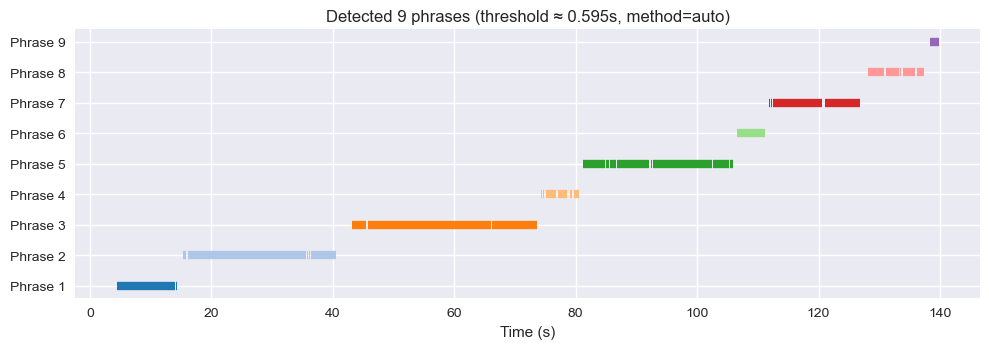


Phrase detection results:
Threshold used: 0.595s
Number of phrases detected: 9

Phrase 1: 4.41s → 14.41s  dur=10.00s  notes=3
    Sa | Ni | Sa
Phrase 2: 15.32s → 40.62s  dur=25.30s  notes=7
    Ma♯ (tivra) | Sa | Ni | Dha | Pa | Dha | Pa
Phrase 3: 43.14s → 73.59s  dur=30.45s  notes=12
    Ma♯ (tivra) | Pa | Ma♯ (tivra) | Ni | Sa | Ni | Sa | Ni | Sa | Ni | Sa | Ni
Phrase 4: 74.34s → 80.50s  dur=6.16s  notes=7
    Ga | Re | Ni | Sa | Ni | Dha | Dha
Phrase 5: 81.24s → 105.94s  dur=24.70s  notes=11
    Ni | Sa | Ni | Sa | Ni | Sa | Ni | Sa | Ga | Re | Ni
Phrase 6: 106.65s → 111.14s  dur=4.50s  notes=3
    Sa | Ni | Sa
Phrase 7: 111.78s → 126.84s  dur=15.06s  notes=6
    Re | Sa | Ni | Sa | Ni | Ga
Phrase 8: 128.07s → 137.35s  dur=9.28s  notes=6
    Ma♯ (tivra) | Ma | Ga | Ma♯ (tivra) | Re | Sa
Phrase 9: 138.28s → 139.82s  dur=1.54s  notes=1
    Ma

Comparison:
Original notes: 60
Corrected notes: 56
Notes retained after raga correction: 93.3%


In [16]:
def _extract_times_and_labels(notes, label_key='sargam'):
    """
    Accepts notes: list-of-dicts with 'start','end' fields. Optionally uses MIDI and sargam labels.
    Returns arrays: starts, ends, mids, labels (strings), original indices.
    """
    starts, ends, mids, labels, idxs = [], [], [], [], []
    for i, n in enumerate(notes):
        if 'start' not in n or 'end' not in n:
            raise ValueError("Each note dict must have 'start' and 'end' keys.")
        starts.append(float(n['start']))
        ends.append(float(n['end']))
        mids.append(int(n.get('midi') if n.get('midi') is not None else (round(n.get('midi_note')) if n.get('midi_note') is not None else np.nan)))
        labels.append(str(n.get(label_key, n.get('sargam', n.get('midi','')))))
        idxs.append(i)
    return np.array(starts), np.array(ends), np.array(mids), labels, np.array(idxs)

def cluster_notes_into_phrases(notes,
                               method='auto',
                               fixed_threshold=None,
                               iqr_factor=1.5,
                               min_phrase_duration=0.1,
                               min_notes_in_phrase=1,
                               merge_gap_threshold=0.1,
                               label_key='sargam',
                               plot_timeline=True,
                               min_auto_threshold=0.3):  # New parameter for minimum auto threshold
    """
    Cluster timestamped notes into phrases.
    - notes: list of dicts with keys 'start' (s), 'end' (s) and optionally 'midi'/'midi_note' and sargam labels.
    - method: 'auto' | 'threshold' | 'kmeans' | 'dbscan'
      - 'auto' tries KMeans (if sklearn available) else robust threshold using IQR.
      - 'threshold' uses fixed_threshold (if None uses iqr method).
      - 'kmeans' uses 2-cluster KMeans on gaps.
      - 'dbscan' treats gaps > eps as breaks; pass eps as fixed_threshold.
    - fixed_threshold: seconds. If supplied it takes priority for 'threshold' or 'dbscan'.
    - iqr_factor: multiplier for IQR in robust threshold.
    - min_phrase_duration: drop phrases shorter than this (seconds) or merge them with neighbors.
    - min_notes_in_phrase: drop phrases with fewer notes (or merge).
    - merge_gap_threshold: after initial segmentation, adjacent phrases separated by a *tiny* silence < this will be merged.
    - label_key: which field in note dict to use for textual label (default 'sargam').
    - min_auto_threshold: minimum threshold for auto method. If auto threshold < this, switch to dbscan with this value.
    Returns: phrases (list of lists of note dicts), breaks_indices, threshold_used
    """
    # defensive copy & sort by start time
    notes_sorted = sorted(notes, key=lambda n: float(n['start']))
    starts, ends, mids, labels, idxs = _extract_times_and_labels(notes_sorted, label_key=label_key)
    n = len(starts)
    if n == 0:
        return [], [], None

    # compute inter-note gaps: end[i-1] -> start[i]
    if n == 1:
        gaps = np.array([])
    else:
        gaps = starts[1:] - ends[:-1]
        # numerical safety
        gaps = np.maximum(gaps, 0.0)

    # pick threshold
    threshold_used = None
    actual_method_used = method  # Track what method was actually used
    
    if method == 'dbscan':
        if fixed_threshold is None:
            raise ValueError("dbscan method requires fixed_threshold (eps in seconds).")
        threshold_used = float(fixed_threshold)

    elif method == 'threshold':
        if fixed_threshold is not None:
            threshold_used = float(fixed_threshold)
        else:
            # robust IQR threshold
            if gaps.size == 0:
                threshold_used = 0.5
            else:
                q1, q3 = np.percentile(gaps, [25, 75])
                iqr = max(q3 - q1, 1e-9)
                threshold_used = float(np.median(gaps) + iqr_factor * iqr)

    elif method in ('kmeans', 'auto'):
        # try KMeans splitting into 2 clusters (short vs long gaps)
        threshold_used = None
        if gaps.size == 0:
            threshold_used = 0.5
        else:
            try:
                from sklearn.cluster import KMeans
                X = gaps.reshape(-1, 1)
                km = KMeans(n_clusters=2, random_state=0, n_init='auto').fit(X)
                centers = km.cluster_centers_.reshape(-1)
                labels_km = km.labels_
                # cluster with smaller center = within-phrase short gaps
                short_cluster = np.argmin(centers)
                long_cluster = np.argmax(centers)
                # threshold = midpoint between the two cluster centers
                auto_threshold = float((centers[short_cluster] + centers[long_cluster]) / 2.0)
                
                # Check if auto threshold is below minimum - if so, switch to dbscan
                if auto_threshold < min_auto_threshold:
                    threshold_used = min_auto_threshold
                    actual_method_used = 'dbscan'
                    print(f"[INFO] Auto threshold ({auto_threshold:.3f}s) below minimum ({min_auto_threshold:.3f}s), switching to dbscan with threshold {min_auto_threshold:.3f}s")
                else:
                    threshold_used = auto_threshold
                    
            except Exception as e:
                # fallback to robust threshold
                q1, q3 = np.percentile(gaps, [25, 75]) if gaps.size else (0.0, 0.0)
                iqr = max(q3 - q1, 1e-9)
                auto_threshold = float(np.median(gaps) + iqr_factor * iqr)
                
                # Check if fallback threshold is below minimum
                if auto_threshold < min_auto_threshold:
                    threshold_used = min_auto_threshold
                    actual_method_used = 'dbscan'
                    print(f"[INFO] Fallback threshold ({auto_threshold:.3f}s) below minimum ({min_auto_threshold:.3f}s), switching to dbscan with threshold {min_auto_threshold:.3f}s")
                else:
                    threshold_used = auto_threshold
                    
                # keep note of fallback
                print(f"[WARN] KMeans unavailable or failed ({e}); using robust IQR threshold {threshold_used:.3f}s")

    else:
        raise ValueError("Unknown method: choose 'auto','threshold','kmeans','dbscan'")

    # segmentation: break where gap > threshold_used
    if gaps.size == 0:
        break_positions = np.array([], dtype=int)
    else:
        break_positions = np.where(gaps > threshold_used)[0]  # indices in gaps; break between note i and i+1 for each index found

    # form phrases
    phrases = []
    start_idx = 0
    for b in break_positions:
        end_idx = b + 1  # inclusive index for phrase slice
        phrase_notes = notes_sorted[start_idx:end_idx]
        phrases.append(phrase_notes)
        start_idx = end_idx
    # last phrase
    phrases.append(notes_sorted[start_idx:])

    # postprocess: merge tiny phrases or those with fewer notes than min_notes_in_phrase
    def _phrase_duration(ph):
        return ph[-1]['end'] - ph[0]['start'] if len(ph) else 0.0

    # 1) merge phrases separated by very small gaps (< merge_gap_threshold)
    if len(phrases) > 1:
        merged = []
        i = 0
        while i < len(phrases):
            cur = phrases[i]
            j = i + 1
            while j < len(phrases):
                gap_between = phrases[j][0]['start'] - cur[-1]['end']
                if gap_between <= merge_gap_threshold:
                    # merge and advance
                    cur = cur + phrases[j]
                    j += 1
                else:
                    break
            merged.append(cur)
            i = j
        phrases = merged

    # 2) merge or drop too-short / too-few-note phrases
    final_phrases = []
    i = 0
    while i < len(phrases):
        ph = phrases[i]
        dur = _phrase_duration(ph)
        if (dur < min_phrase_duration) or (len(ph) < min_notes_in_phrase):
            # try merging with neighbor: prefer merging forward, else backward, else drop
            merged_here = False
            if i + 1 < len(phrases):
                phrases[i+1] = ph + phrases[i+1]
                merged_here = True
            elif i - 1 >= 0:
                final_phrases[-1] = final_phrases[-1] + ph
                merged_here = True
            # if merged, skip adding; else drop
            if merged_here:
                # do not append ph; move to next (which will be merged)
                i += 1
                continue
            else:
                # drop it
                i += 1
                continue
        else:
            final_phrases.append(ph)
            i += 1
    phrases = final_phrases

    # produce break indices in original notes_sorted indexing
    # compute cumulative sizes to reconstruct original break indices
    cum_lens = np.cumsum([len(p) for p in phrases])
    breaks_indices = [int(x) for x in cum_lens[:-1]]  # indices in sorted notes where phrases break

    if plot_timeline:
        fig, ax = plt.subplots(figsize=(10, max(2, len(phrases)*0.4)))
        cmap = plt.get_cmap('tab20')
        for i, ph in enumerate(phrases):
            xs = [n['start'] for n in ph]
            xe = [n['end'] for n in ph]
            y = i
            for j, (s, e) in enumerate(zip(xs, xe)):
                ax.plot([s, e], [y, y], lw=6, solid_capstyle='butt', color=cmap(i % 20))
                # Removed: ax.text(...) that was printing sargam labels
        ax.set_yticks(range(len(phrases)))
        ax.set_yticklabels([f"Phrase {i+1}" for i in range(len(phrases))])
        ax.set_xlabel("Time (s)")
        ax.set_title(f"Detected {len(phrases)} phrases (threshold ≈ {threshold_used:.3f}s, method={actual_method_used})")
        plt.tight_layout()
        plt.show()

    return phrases, breaks_indices, threshold_used

def print_phrases_summary(phrases, label_key='sargam', max_notes=20):
    """Print a summary of detected phrases with their note sequences."""
    for i, ph in enumerate(phrases, 1):
        start = ph[0]['start']
        end = ph[-1]['end']
        dur = end - start
        nnotes = len(ph)
        labels = [str(n.get(label_key, n.get('sargam', ''))) for n in ph]
        preview = " | ".join(labels[:max_notes])
        print(f"Phrase {i}: {start:.2f}s → {end:.2f}s  dur={dur:.2f}s  notes={nnotes}")
        print(f"    {preview}")

try:
    notes_to_use = corrected_sargam_seq
    print("Using raga-corrected sargam sequence for phrase detection")
    print(f"Number of corrected notes: {len(notes_to_use)}")
except NameError:
    print("Warning: corrected_sargam_seq not found, using original sargam_seq")
    notes_to_use = sargam_seq

phrases, breaks, thr = cluster_notes_into_phrases(
    notes_to_use, 
    method='auto', 
    fixed_threshold=3, 
    plot_timeline=True,
    label_key='sargam'
)

print(f"\nPhrase detection results:")
print(f"Threshold used: {thr:.3f}s")
print(f"Number of phrases detected: {len(phrases)}")
print()

print_phrases_summary(phrases)

try:
    if 'corrected_sargam_seq' in locals() and 'sargam_seq' in locals():
        print(f"\nComparison:")
        print(f"Original notes: {len(sargam_seq)}")
        print(f"Corrected notes: {len(corrected_sargam_seq)}")
        print(f"Notes retained after raga correction: {len(corrected_sargam_seq)/len(sargam_seq)*100:.1f}%")
except:
    pass

# Clustering notes into phrases and related helpers

Defines functions to cluster timestamped notes into phrases, plot timelines, and compute phrase summaries; used for phrase-level analysis and visualization.

In [17]:
print("Total notes kept:", len(corrected_sargam_seq))
print("Total phrases:", len(phrases))

Total notes kept: 56
Total phrases: 9


# Quick summary prints

Prints simple counts: total corrected notes kept and detected phrases; a short status check after phrase detection.

Found 9 phrases from previous analysis.
Using tonic: D#
Building corrected transition matrix for aaroh/avroh analysis...
Analyzing Corrected Raga Patterns...
--------------------------------------------------
Found 8 unique sargam notes in the corrected data:
  Sa, Re, Ga, Ma, Ma♯ (tivra), Pa, Dha, Ni
  Ordered by pitch class: [0, 1, 3, 5, 6, 7, 8, 10]
Built transition matrix with 47 transitions across 9 phrases
Matrix dimensions: 8x8 (only notes present in corrected data)
Found 7 unique ascending patterns
Found 11 unique descending patterns


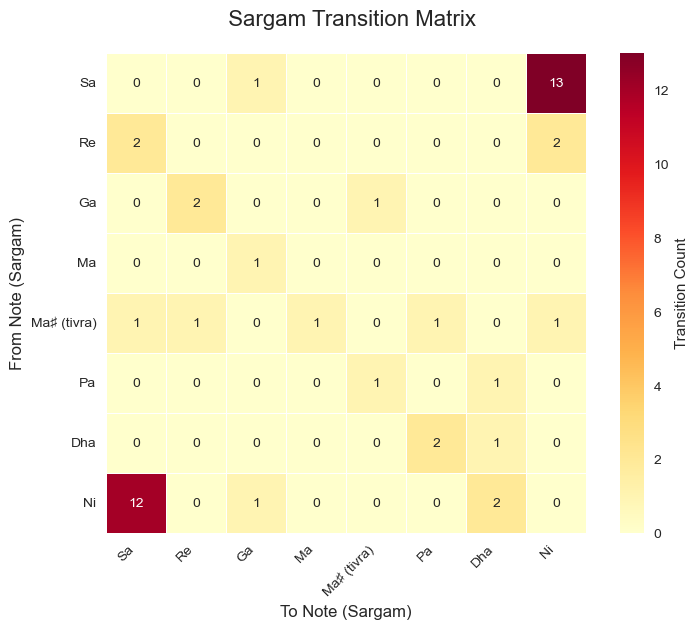

AAROH (ASCENDING) PATTERNS
 1. Ni → Sa                        ( 12 times)
 2. Pa → Dha                       (  1 times)
 3. Ma♯ (tivra) → Pa               (  1 times)
 4. Ma♯ (tivra) → Ni               (  1 times)
 5. Sa → Ga                        (  1 times)
 6. Ni → Ga                        (  1 times)
 7. Ga → Ma♯ (tivra)               (  1 times)

AVROH (DESCENDING) PATTERNS
 1. Sa → Ni                        ( 13 times)
 2. Ni → Dha                       (  2 times)
 3. Dha → Pa                       (  2 times)
 4. Ga → Re                        (  2 times)
 5. Re → Ni                        (  2 times)
 6. Re → Sa                        (  2 times)
 7. Ma♯ (tivra) → Sa               (  1 times)
 8. Pa → Ma♯ (tivra)               (  1 times)
 9. Ma♯ (tivra) → Ma               (  1 times)
10. Ma → Ga                        (  1 times)
11. Ma♯ (tivra) → Re               (  1 times)

COMMON MELODIC PATTERNS
 1. Ni → Sa → Ni                             (37 times)
 2. Sa → Ni → Sa 

In [18]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def extract_corrected_sargam_info(note, tonic):
    """Extract sargam information from corrected notes, using their sargam labels directly."""
    # Use the corrected sargam label if available
    sargam_label = note.get('sargam', '').strip()
    
    # Get MIDI for direction analysis
    midi_note = note.get('midi', note.get('midi_note', None))
    if midi_note is not None:
        midi_note = int(round(float(midi_note)))
    
    # Map sargam labels to pitch class offsets (relative to Sa)
    sargam_to_pc = {
        'Sa': 0,
        'Re♭ (komal)': 1, 'Re♭': 1,
        'Re': 2, 'Re (shuddha)': 2,
        'Ga♭ (komal)': 3, 'Ga♭': 3,
        'Ga': 4, 'Ga (shuddha)': 4,
        'Ma': 5, 'Ma (shuddha)': 5,
        'Ma♯ (tivra)': 6, 'Ma♯': 6,
        'Pa': 7,
        'Dha♭ (komal)': 8, 'Dha♭': 8,
        'Dha': 9, 'Dha (shuddha)': 9,
        'Ni♭ (komal)': 10, 'Ni♭': 10,
        'Ni': 11, 'Ni (shuddha)': 11
    }
    
    # Try exact match first, then fuzzy match
    pc_offset = None
    for sargam_key, pc_val in sargam_to_pc.items():
        if sargam_label == sargam_key:
            pc_offset = pc_val
            break
        elif sargam_key.startswith(sargam_label.split()[0]):  # Match base note
            pc_offset = pc_val
            break
    
    if pc_offset is None:
        # Fallback: try to extract from pc_offset field if available
        if 'pc_offset' in note and note['pc_offset'] is not None:
            pc_offset = int(note['pc_offset']) % 12
        else:
            return None, midi_note, sargam_label
    
    return pc_offset, midi_note, sargam_label

def build_transition_matrix_corrected(phrases, tonic, sargam_labels=None, min_transition_gap=0.1):
    """
    Build transition matrix specifically for corrected raga notes.
    Only uses notes that actually appear in the phrases.
    """
    
    # Collect all unique sargam labels that actually appear in the data
    unique_sargams = set()
    for phrase in phrases:
        for note in phrase:
            sargam = note.get('sargam', '').strip()
            if sargam:
                unique_sargams.add(sargam)
    
    # Define the correct sargam order based on pitch class
    sargam_order_map = {
        'Sa': 0,
        'Re♭ (komal)': 1, 'Re♭': 1,
        'Re': 2, 'Re (shuddha)': 2,
        'Ga♭ (komal)': 3, 'Ga♭': 3,
        'Ga': 4, 'Ga (shuddha)': 4,
        'Ma': 5, 'Ma (shuddha)': 5,
        'Ma♯ (tivra)': 6, 'Ma♯': 6,
        'Pa': 7,
        'Dha♭ (komal)': 8, 'Dha♭': 8,
        'Dha': 9, 'Dha (shuddha)': 9,
        'Ni♭ (komal)': 10, 'Ni♭': 10,
        'Ni': 11, 'Ni (shuddha)': 11
    }
    
    # Sort unique sargams by their pitch class order
    def get_sargam_order(sargam):
        for key, order in sargam_order_map.items():
            if sargam == key or key.startswith(sargam.split()[0]):
                return order
        return 99  # Unknown sargams go to the end
    
    unique_sargams = sorted(list(unique_sargams), key=get_sargam_order)
    print(f"Found {len(unique_sargams)} unique sargam notes in the corrected data:")
    print(f"  {', '.join(unique_sargams)}")
    print(f"  Ordered by pitch class: {[get_sargam_order(s) for s in unique_sargams]}")
    
    # Create mapping from sargam label to matrix index
    sargam_to_idx = {sargam: i for i, sargam in enumerate(unique_sargams)}
    
    # Initialize matrices
    n_notes = len(unique_sargams)
    transition_matrix = np.zeros((n_notes, n_notes), dtype=int)
    transition_details = []
    aaroh_patterns = defaultdict(int)
    avroh_patterns = defaultdict(int)
    
    total_transitions = 0
    
    for phrase_idx, phrase in enumerate(phrases):
        if len(phrase) < 2:
            continue
            
        sorted_phrase = sorted(phrase, key=lambda x: x.get('start', 0))
        
        for i in range(len(sorted_phrase) - 1):
            current_note = sorted_phrase[i]
            next_note = sorted_phrase[i + 1]
            
            # Extract sargam information
            curr_pc, curr_midi, curr_sargam = extract_corrected_sargam_info(current_note, tonic)
            next_pc, next_midi, next_sargam = extract_corrected_sargam_info(next_note, tonic)
            
            if curr_sargam not in sargam_to_idx or next_sargam not in sargam_to_idx:
                continue
            
            # Check time gap
            time_gap = next_note.get('start', 0) - current_note.get('end', 0)
            if time_gap > min_transition_gap * 5:
                continue
            
            # Get matrix indices
            curr_idx = sargam_to_idx[curr_sargam]
            next_idx = sargam_to_idx[next_sargam]
            
            # Update transition matrix
            transition_matrix[curr_idx, next_idx] += 1
            
            # Analyze direction if MIDI available
            if curr_midi is not None and next_midi is not None:
                midi_diff = next_midi - curr_midi
                
                pattern_key = f"{curr_sargam} → {next_sargam}"
                if midi_diff > 0:
                    aaroh_patterns[pattern_key] += 1
                elif midi_diff < 0:
                    avroh_patterns[pattern_key] += 1
            
            # Store transition details
            transition_details.append({
                'phrase_idx': phrase_idx,
                'from_sargam': curr_sargam,
                'to_sargam': next_sargam,
                'from_midi': curr_midi,
                'to_midi': next_midi,
                'direction': 'ascending' if (curr_midi and next_midi and next_midi > curr_midi) 
                           else 'descending' if (curr_midi and next_midi and next_midi < curr_midi)
                           else 'same',
                'time_gap': time_gap,
                'start_time': current_note.get('start', 0),
                'end_time': next_note.get('end', 0)
            })
            
            total_transitions += 1
    
    # Create DataFrame with actual sargam labels
    transition_df = pd.DataFrame(transition_matrix, 
                                index=unique_sargams, 
                                columns=unique_sargams)
    
    print(f"Built transition matrix with {total_transitions} transitions across {len(phrases)} phrases")
    print(f"Matrix dimensions: {n_notes}x{n_notes} (only notes present in corrected data)")
    print(f"Found {len(aaroh_patterns)} unique ascending patterns")
    print(f"Found {len(avroh_patterns)} unique descending patterns")
    
    return transition_matrix, transition_df, aaroh_patterns, avroh_patterns, transition_details, unique_sargams

def analyze_aaroh_avroh(aaroh_patterns, avroh_patterns, top_n=10):
    """Analyze and display the most common ascending and descending patterns."""
    
    print("="*60)
    print("AAROH (ASCENDING) PATTERNS")
    print("="*60)
    
    sorted_aaroh = sorted(aaroh_patterns.items(), key=lambda x: x[1], reverse=True)
    
    if not sorted_aaroh:
        print("No ascending patterns found.")
    else:
        for i, (pattern, count) in enumerate(sorted_aaroh[:top_n], 1):
            print(f"{i:2d}. {pattern:<30} ({count:3d} times)")
    
    print("\n" + "="*60)
    print("AVROH (DESCENDING) PATTERNS") 
    print("="*60)
    
    sorted_avroh = sorted(avroh_patterns.items(), key=lambda x: x[1], reverse=True)
    
    if not sorted_avroh:
        print("No descending patterns found.")
    else:
        for i, (pattern, count) in enumerate(sorted_avroh[:top_n], 1):
            print(f"{i:2d}. {pattern:<30} ({count:3d} times)")
    
    return sorted_aaroh, sorted_avroh

def plot_transition_heatmap_v2(transition_df, title="Note Transition Matrix", 
                              figsize=(10, 8), annot=True, cmap='YlOrRd'):
    """Plot an improved heatmap of the transition matrix."""
    
    # Adjust figure size based on number of notes
    n_notes = len(transition_df.index)
    figsize = (max(8, n_notes * 0.8), max(6, n_notes * 0.8))
    
    plt.figure(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(transition_df, 
                annot=annot, 
                fmt='d', 
                cmap=cmap,
                square=True,
                linewidths=0.5,
                cbar_kws={'label': 'Transition Count'})
    
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('To Note (Sargam)', fontsize=12)
    plt.ylabel('From Note (Sargam)', fontsize=12)
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

def extract_melodic_sequences(phrases, max_length=8):
    """Extract longer melodic sequences for pattern analysis."""
    
    sequences = []
    
    for phrase_idx, phrase in enumerate(phrases):
        if len(phrase) < 3:
            continue
            
        sorted_phrase = sorted(phrase, key=lambda x: x.get('start', 0))
        
        # Extract sargam sequence
        sargam_sequence = []
        midi_sequence = []
        
        for note in sorted_phrase:
            sargam = note.get('sargam', '').strip()
            if sargam:
                sargam_sequence.append(sargam)
                midi_val = note.get('midi', note.get('midi_note'))
                if midi_val:
                    midi_sequence.append(int(midi_val))
        
        # Break into overlapping windows
        for i in range(len(sargam_sequence) - 2):
            end_idx = min(i + max_length, len(sargam_sequence))
            seq = sargam_sequence[i:end_idx]
            midi_seq = midi_sequence[i:end_idx] if len(midi_sequence) == len(sargam_sequence) else None
            
            if len(seq) >= 3:
                sequences.append({
                    'phrase_idx': phrase_idx,
                    'sequence': seq,
                    'midi_sequence': midi_seq,
                    'length': len(seq),
                    'start_idx': i
                })
    
    return sequences

def find_common_patterns(sequences, min_length=3, min_frequency=2):
    """Find commonly occurring melodic patterns."""
    
    pattern_counts = defaultdict(int)
    
    for seq_info in sequences:
        seq = seq_info['sequence']
        
        # Generate all subsequences of minimum length
        for length in range(min_length, len(seq) + 1):
            for start in range(len(seq) - length + 1):
                pattern = tuple(seq[start:start + length])
                pattern_counts[pattern] += 1
    
    # Filter by minimum frequency
    common_patterns = {pattern: count for pattern, count in pattern_counts.items() 
                      if count >= min_frequency}
    
    # Sort by frequency and length
    sorted_patterns = sorted(common_patterns.items(), 
                           key=lambda x: (x[1], len(x[0])), 
                           reverse=True)
    
    return sorted_patterns

def analyze_raga_patterns_corrected(phrases, tonic='D', top_patterns=15):
    """Complete analysis of raga patterns from corrected phrases."""
    
    print("Analyzing Corrected Raga Patterns...")
    print("-" * 50)
    
    # Build transition matrix for corrected notes only
    matrix, df, aaroh, avroh, details, unique_sargams = build_transition_matrix_corrected(phrases, tonic)
    
    # Plot transition matrix
    plot_transition_heatmap_v2(df, "  Sargam Transition Matrix")
    
    # Analyze patterns
    analyze_aaroh_avroh(aaroh, avroh, top_n=top_patterns)
    
    # Extract melodic sequences
    sequences = extract_melodic_sequences(phrases)
    common_patterns = find_common_patterns(sequences)
    
    print(f"\n{'='*60}")
    print("COMMON MELODIC PATTERNS")
    print("="*60)
    
    if common_patterns:
        for i, (pattern, count) in enumerate(common_patterns[:top_patterns], 1):
            pattern_str = " → ".join(pattern)
            print(f"{i:2d}. {pattern_str:<40} ({count:2d} times)")
    else:
        print("No common patterns found (try reducing min_frequency)")
    
    return matrix, df, aaroh, avroh, details, sequences, common_patterns, unique_sargams

# Check if phrases from previous cell exist
if 'phrases' not in locals() or len(phrases) == 0:
    print("Error: No phrases found. Please run the phrase detection cell first.")
else:
    print(f"Found {len(phrases)} phrases from previous analysis.")
    
    # Use the same tonic as defined earlier
    if 'tonic' not in locals():
        tonic = 'D'
        print(f"Using default tonic: {tonic}")
    else:
        print(f"Using tonic: {tonic}")
    
    print("Building corrected transition matrix for aaroh/avroh analysis...")
    
    # Run the complete analysis
    results = analyze_raga_patterns_corrected(phrases, tonic=tonic, top_patterns=20)
    matrix, df, aaroh_patterns, avroh_patterns, transition_details, sequences, common_patterns, unique_sargams = results
    
    # Additional analysis: Most active notes
    print(f"\n{'='*60}")
    print("NOTE USAGE STATISTICS")
    print("="*60)
    
    # Calculate note activity
    outgoing = df.sum(axis=1)
    incoming = df.sum(axis=0)
    total_activity = outgoing + incoming
    
    print("Most active notes (total transitions):")
    for i, (note, activity) in enumerate(total_activity.sort_values(ascending=False).head(10).items(), 1):
        out_count = outgoing[note]
        in_count = incoming[note]
        print(f"{i:2d}. {note:<20} Total: {activity:3d} (Out: {out_count:3d}, In: {in_count:3d})")
    
    # Summary
    print(f"\nSummary:")
    print(f"Transition matrix shape: {matrix.shape}")
    print(f"Unique sargam notes used: {len(unique_sargams)}")
    print(f"Total phrases analyzed: {len(phrases)}")
    print(f"Total transitions captured: {len(transition_details)}")
    print(f"Unique melodic patterns found: {len(common_patterns)}")
    
    try:
        if 'corrected_sargam_seq' in locals():
            print(f"Analysis performed on raga-corrected note sequence")
        else:
            print(f"Analysis performed on original note sequence")
    except:
        pass

# Extract and summarize corrected sargam info / build transition matrices

Collects corrected sargam labels and builds transition matrices, patterns and utilities for analyzing melodic sequences; includes plotting helpers and pattern extraction functions.

=== Enhanced Pitch Processing Demonstration ===

1. Analyzing pitch derivatives to help tune parameters...
Pitch Derivative Analysis:
  Mean: 3.950 semitones/sec
  Median: 0.130 semitones/sec
  95th percentile: 23.132 semitones/sec
  99th percentile: 47.660 semitones/sec
\nSuggested derivative thresholds:
  Conservative (more notes): 2.711
  Moderate: 7.320
  Aggressive (fewer notes): 23.132


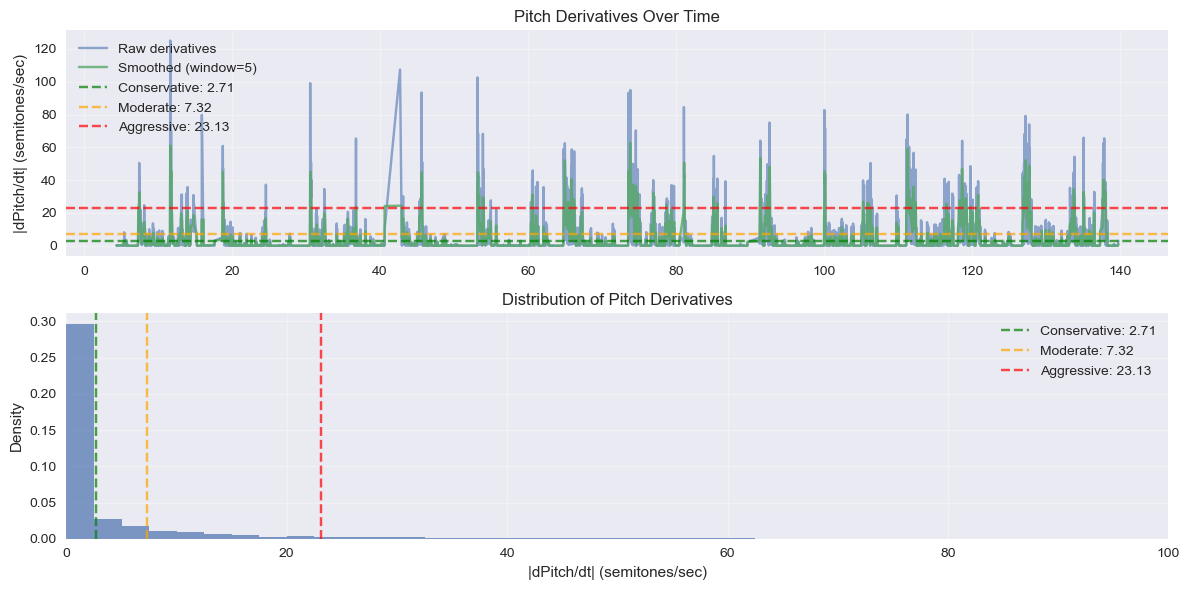

\n============================================================\n
2. Comparing different note detection methods...
=== Comparing Note Detection Methods ===
Original method: 94 notes
Stationary points method: 60 notes
Peak-based method: 63 notes
Median smoothing + stationary: 65 notes


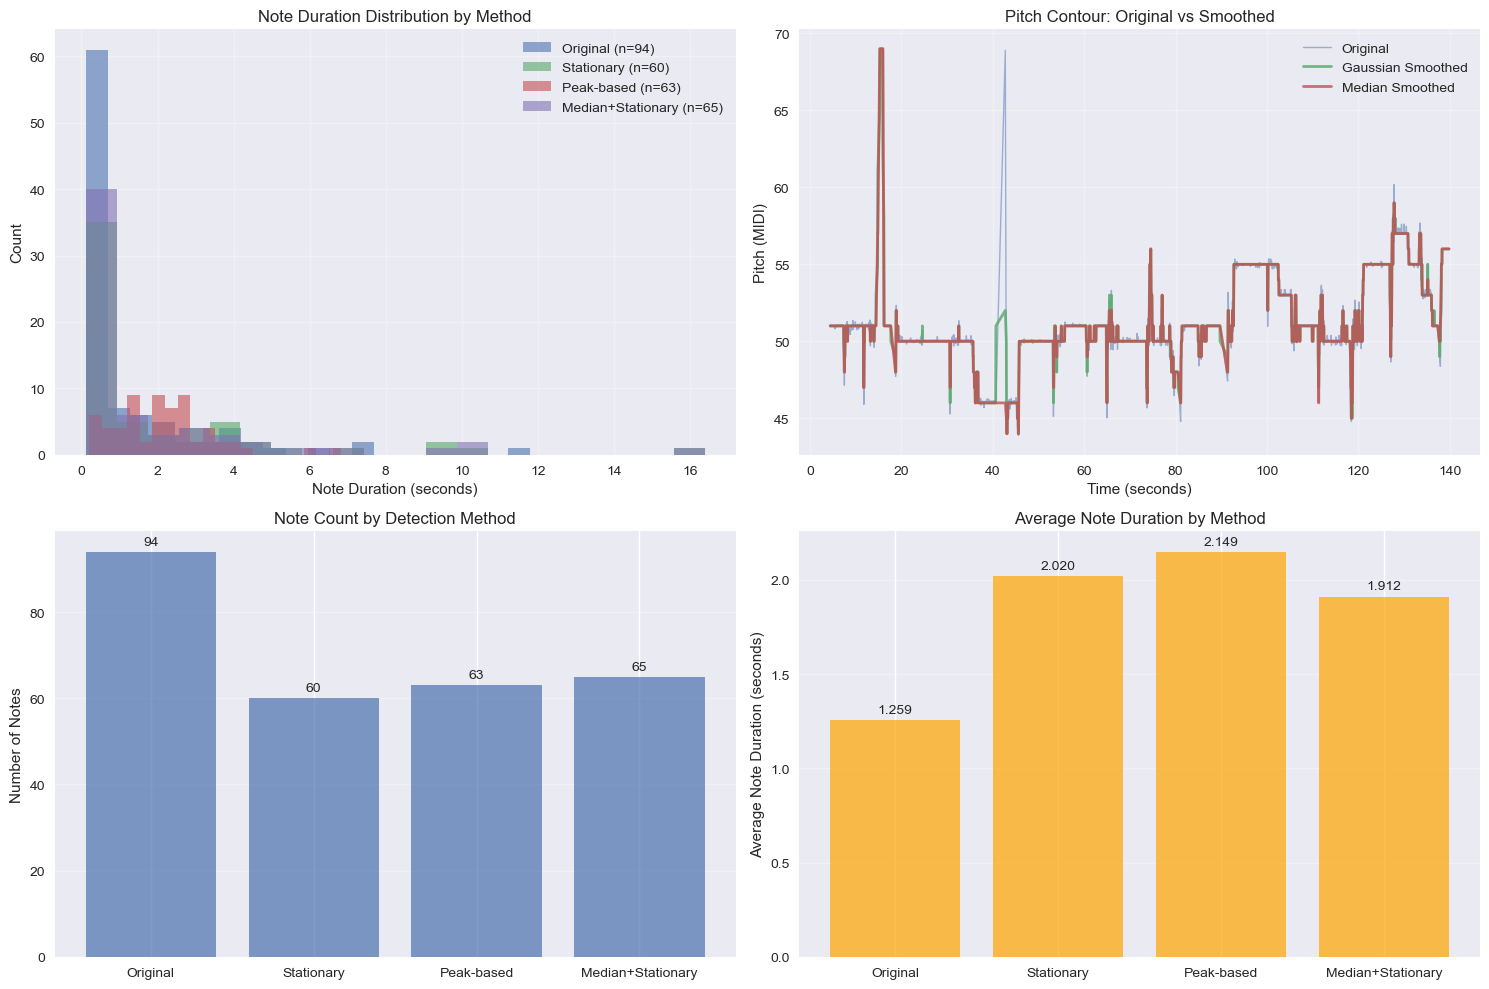

\n============================================================\n
3. Experimenting with different parameter settings...
\nTesting aggressive smoothing (sigma=3.0):
  Result: 49 notes detected
\nTesting sensitive detection (low thresholds):
  Result: 28 notes detected
Testing peak-based detection for ornaments:
  Result: 99 total notes (96 sustained, 3 ornaments)


In [19]:
print("=== Enhanced Pitch Processing Demonstration ===")
print()

# Analyse pitch derivatives to understand the signal characteristics
print("1. Analyzing pitch derivatives to help tune parameters...")
analyze_pitch_derivatives(result_v, window_size=5)

print("\\n" + "="*60 + "\\n")

# Compare different note detection methods
print("2. Comparing different note detection methods...")
comparison_results = compare_note_detection_methods(result_v, output_prefix="vocal_comparison")

print("\\n" + "="*60 + "\\n")

# Experiment with different configurations
print("3. Experimenting with different parameter settings...")

#  More aggressive smoothing for noisy signals
print("\\nTesting aggressive smoothing (sigma=3.0):")
aggressive_smooth = smooth_pitch_contour(result_v, method='gaussian', sigma=3.0, snap_to_semitones=True)
aggressive_notes = detect_pitch_stationary_points(
    aggressive_smooth, 
    min_stability_duration=0.15,
    pitch_change_threshold=0.5,
    derivative_threshold=0.1
)
print(f"  Result: {len(aggressive_notes)} notes detected")

# More sensitive detection for subtle changes
print("\\nTesting sensitive detection (low thresholds):")
sensitive_notes = detect_pitch_stationary_points(
    result_v, 
    min_stability_duration=0.05,
    pitch_change_threshold=0.2,
    derivative_threshold=0.25
)
print(f"  Result: {len(sensitive_notes)} notes detected")

# Example: Peak-based detection for ornament-rich music
print("Testing peak-based detection for ornaments:")
peak_notes = detect_melodic_peaks_and_stable_regions(
    result_v,
    peak_prominence=0.8,
    stable_region_min_duration=0.1
)
ornament_count = sum(1 for note in peak_notes if note.get('is_ornament', False))
sustained_count = len(peak_notes) - ornament_count
print(f"  Result: {len(peak_notes)} total notes ({sustained_count} sustained, {ornament_count} ornaments)")

# Demonstration of enhanced processing

Runs a demonstration that analyzes pitch derivatives, compares detection methods, and experiments with several parameter settings to show differences in detected notes.

# Test comparison of detection methods

Run a full comparison of note detection methods and report success/failure; intended to verify recent fixes and print per-method counts.

In [20]:
def midi_to_sargam(midi_note, tonic_note='C'):
    """
    Convert MIDI note to sargam notation relative to given tonic.
    """
    # Convert tonic to MIDI if it's a string
    if isinstance(tonic_note, str):
        tonic_midi = librosa.note_to_midi(tonic_note + '4')
    else:
        tonic_midi = tonic_note
    
    # Calculate offset from tonic
    offset = int(round(midi_note - tonic_midi)) % 12
    
    # Sargam mapping with komal/shuddha variants
    sargam_map = {
        0:  "Sa",
        1:  "re",      # komal Re
        2:  "Re",      # shuddha Re  
        3:  "ga",      # komal Ga
        4:  "Ga",      # shuddha Ga
        5:  "Ma",      # shuddha Ma
        6:  "Ma#",     # tivra Ma
        7:  "Pa",
        8:  "dha",     # komal Dha
        9:  "Dha",     # shuddha Dha
        10: "ni",      # komal Ni
        11: "Ni"       # shuddha Ni
    }
    
    # octave information
    octave_diff = int((midi_note - tonic_midi) // 12)
    base_sargam = sargam_map.get(offset, f"?{offset}")
    
    # Add octave markers
    if octave_diff < 0:
        return base_sargam + "'" * abs(octave_diff)  # Lower octave with apostrophes
    elif octave_diff > 0:
        return base_sargam + "·" * octave_diff  # Higher octave with dots
    else:
        return base_sargam

def detect_phrases(notes, max_gap=2.0, min_phrase_length=3):
    """
    group notes into phrases based on temporal gaps and minimum length.
    """
    if not notes:
        return []
    
    # Helper function to get note attributes
    def get_note_attr(note, attr):
        if isinstance(note, dict):
            return note.get(attr)
        else:
            # Handle both direct attribute access and getattr with defaults
            if hasattr(note, attr):
                return getattr(note, attr)
            else:
                return None
    
    phrases = []
    current_phrase = []
    
    for i, note in enumerate(notes):
        if not current_phrase:
            current_phrase = [note]
        else:
            # get timing from note (handle both dict and object formats)
            prev_end = get_note_attr(current_phrase[-1], 'end')
            curr_start = get_note_attr(note, 'start')
            
            if prev_end is None or curr_start is None:
                current_phrase.append(note)
                continue
                
            gap = curr_start - prev_end
            
            if gap > max_gap:
                # End current phrase if it's long enough
                if len(current_phrase) >= min_phrase_length:
                    phrases.append(current_phrase)
                current_phrase = [note]
            else:
                current_phrase.append(note)
    
    # Add final phrase if long enough
    if len(current_phrase) >= min_phrase_length:
        phrases.append(current_phrase)
    
    return phrases

def transcribe_notes_to_sargam(notes, tonic_note='C', phrase_detection=True):
    """
    Convert a list of notes to sargam transcription.
    """
    if not notes:
        return "No notes detected"
    
    # Handle different note formats (dict vs object)
    def get_note_attr(note, attr):
        if isinstance(note, dict):
            return note.get(attr)
        else:
            # Handle both direct attribute access and getattr with defaults
            if hasattr(note, attr):
                return getattr(note, attr)
            else:
                # Handle special cases for object attributes
                if attr == 'pitch_midi' and hasattr(note, 'pitch_midi'):
                    return note.pitch_midi
                elif attr == 'start' and hasattr(note, 'start'):
                    return note.start
                elif attr == 'end' and hasattr(note, 'end'):
                    return note.end
                return None
    
    if phrase_detection:
        phrases = detect_phrases(notes)
        transcription_parts = []
        
        for i, phrase in enumerate(phrases):
            phrase_sargams = []
            phrase_start = get_note_attr(phrase[0], 'start')
            phrase_end = get_note_attr(phrase[-1], 'end')
            
            for note in phrase:
                midi_val = get_note_attr(note, 'pitch_midi')
                if midi_val is not None:
                    sargam = midi_to_sargam(midi_val, tonic_note)
                    
                    # Add duration indicator for very short or very long notes
                    duration = get_note_attr(note, 'end') - get_note_attr(note, 'start')
                    if duration < 0.1:
                        sargam = f"({sargam})"  # Very quick ornament
                    elif duration > 2.0:
                        sargam = f"{sargam}—"   # Sustained note
                    
                    phrase_sargams.append(sargam)
            
            phrase_text = " ".join(phrase_sargams)
            time_info = f"[{phrase_start:.1f}s-{phrase_end:.1f}s]"
            transcription_parts.append(f"Phrase {i+1} {time_info}: {phrase_text}")
        
        return "\n".join(transcription_parts)
    else:
        # Simple linear transcription
        sargams = []
        for note in notes:
            midi_val = get_note_attr(note, 'pitch_midi')
            if midi_val is not None:
                sargam = midi_to_sargam(midi_val, tonic_note)
                sargams.append(sargam)
        return " ".join(sargams)

def compare_transcriptions(notes_dict, tonic_note='C'):
    """
    Compare transcriptions from different note detection methods.
    """
    print("PHRASE-WISE TRANSCRIPTION COMPARISON")
    print("=" * 60)
    print(f"Tonic: {tonic_note}")
    print()
    
    for method_name, notes in notes_dict.items():
        print(f"{method_name.upper()} METHOD ({len(notes)} notes):")
        print("-" * 40)
        
        transcription = transcribe_notes_to_sargam(notes, tonic_note, phrase_detection=True)
        print(transcription)
        print()
        
        # Also show simplified linear transcription
        linear = transcribe_notes_to_sargam(notes, tonic_note, phrase_detection=False)
        print(f"Linear: {linear[:100]}{'...' if len(linear) > 100 else ''}")
        print("\n" + "=" * 60 + "\n")

def analyze_note_patterns(notes, tonic_note='C'):
    """
    Analyze common note patterns and transitions in the transcription.
    """
    if not notes:
        return
    
    # Helper function to get note attributes
    def get_note_attr(note, attr):
        if isinstance(note, dict):
            return note.get(attr)
        else:
            if hasattr(note, attr):
                return getattr(note, attr)
            else:
                return None
    
    # Convert to sargam sequence
    sargam_sequence = []
    for note in notes:
        midi_val = get_note_attr(note, 'pitch_midi')
        if midi_val is not None:
            sargam = midi_to_sargam(midi_val, tonic_note)
            sargam_sequence.append(sargam)
    
    if not sargam_sequence:
        print("No valid notes found for pattern analysis")
        return
    
    print(f"PATTERN ANALYSIS ({len(sargam_sequence)} notes)")
    print("-" * 30)
    
    # Most frequent notes
    from collections import Counter
    note_counts = Counter(sargam_sequence)
    print("Most frequent notes:")
    for note, count in note_counts.most_common(7):
        percentage = (count / len(sargam_sequence)) * 100
        print(f"  {note}: {count} times ({percentage:.1f}%)")
    
    # Common transitions (bigrams)
    if len(sargam_sequence) > 1:
        transitions = [f"{sargam_sequence[i]}→{sargam_sequence[i+1]}" 
                      for i in range(len(sargam_sequence)-1)]
        transition_counts = Counter(transitions)
        print(f"\nMost common transitions:")
        for transition, count in transition_counts.most_common(5):
            print(f"  {transition}: {count} times")
    
    # Detect aaroh/avroh patterns
    ascending_patterns = []
    
    for i in range(len(sargam_sequence) - 2):
        triplet = sargam_sequence[i:i+3]
        # Simple ascending/descending detection (could be more sophisticated)
        if len(set(triplet)) == 3:  # All different notes
            ascending_patterns.append(" ".join(triplet))
    
    if ascending_patterns:
        print(f"\nDetected melodic patterns:")
        pattern_counts = Counter(ascending_patterns)
        for pattern, count in pattern_counts.most_common(3):
            print(f"  {pattern}: {count} times")

print("Transcription functions loaded!")

Transcription functions loaded!


# Transcription helper functions (midi → sargam, phrase grouping)

Defines utilities to convert MIDI notes to sargam notation, group notes into phrases, transcribe phrases into readable sargam strings, and compare transcriptions across methods.

In [21]:
# Run Phrase-wise Transcription Comparison
print("GENERATING PHRASE-WISE TRANSCRIPTIONS")
print("=" * 50)

# Use existing comparison results or generate new ones
try:
    if 'comparison_results' not in locals():
        print("Generating comparison results...")
        comparison_results = compare_note_detection_methods(result_v, output_prefix=None)
    
    # Run transcription comparison
    compare_transcriptions(comparison_results, tonic_note=tonic)
    
except Exception as e:
    print(f"Error with full comparison: {e}")
    print("Trying individual methods...")
    
    # Try individual methods with better error handling
    methods_to_try = {}
    
    # Try stationary point method
    if 'stationary_notes' in locals() and stationary_notes:
        methods_to_try['Stationary Points'] = stationary_notes
        
    # Try peak-based method  
    if 'peak_notes' in locals() and peak_notes:
        methods_to_try['Peak-based'] = peak_notes
        
    # Try original method with different approach
    try:
        from swift_f0 import segment_notes
        original_notes_fresh = segment_notes(result_v, split_semitone_threshold=0.8, min_note_duration=0.1)
        methods_to_try['Original'] = original_notes_fresh
    except Exception as orig_error:
        print(f"Could not get original method notes: {orig_error}")
    
    if methods_to_try:
        compare_transcriptions(methods_to_try, tonic_note=tonic)
    
    print("DETAILED PATTERN ANALYSIS FOR EACH METHOD")
    print("=" * 60)
    
    for method_name, notes in comparison_results.items():
        print(f"\n{method_name.upper()} METHOD ANALYSIS:")
        analyze_note_patterns(notes, tonic_note=tonic)
        print("\n" + "-" * 60)
        
except Exception as e:
    print(f"Error generating transcriptions: {e}")
    print("Make sure the detection methods have been run first.")
    
    # Fallback: use any available note sequences
    if 'stationary_notes' in locals() and stationary_notes:
        print("\nUsing stationary point detection results:")
        transcription = transcribe_notes_to_sargam(stationary_notes, tonic, phrase_detection=True)
        print(transcription)
    elif 'vocal_note_sequence' in locals() and vocal_note_sequence:
        print("\nUsing vocal note sequence:")
        transcription = transcribe_notes_to_sargam(vocal_note_sequence, tonic, phrase_detection=True)
        print(transcription)

GENERATING PHRASE-WISE TRANSCRIPTIONS
PHRASE-WISE TRANSCRIPTION COMPARISON
Tonic: D#

ORIGINAL METHOD (94 notes):
----------------------------------------
Phrase 1 [4.4s-16.3s]: Sa' Sa'— ni'' Sa'— Sa' Sa' Ni'' Sa' Ma# Sa'
Phrase 2 [18.8s-40.7s]: Ni''— Ni'' Ni''— Dha'' Pa'' Dha'' Pa''—
Phrase 3 [43.0s-139.8s]: Ma#'' Pa''— Ma#'' Ma'' Ni''— Ni'' Ni'' Sa'— Ni'' Ni'' Sa' Ni'' Sa'— Sa' Ni'' Sa' Ni'' Sa' Ni'' Ni''— dha'' Ga' Re' Sa' Ni'' Sa' Ni'' Sa' Ni'' Dha'' Dha'' dha'' Dha'' Sa'— Ni'' Ni'' Sa' Ni'' Sa'— Sa' Sa' Ni'' Sa' Ga'— Ga'— Re'— Sa' Ni'' Sa' Re' Sa'— Re' Sa' Ni''— Sa' Sa' Ni'' Ni'' Ma#'' Ni'' Ni'' Ni'' Sa' Ni'' Re' Ga'— Ga' Ga' Ma#'— Ga'— Ma#' Ga' Re' Re' Sa' Sa' Ma'

Linear: Sa' Sa' ni'' Sa' Sa' Sa' Ni'' Sa' Ma# Sa' Ni'' Ni'' Ni'' Dha'' Pa'' Dha'' Pa'' Ma#'' Pa'' Ma#'' Ma''...


STATIONARY METHOD (60 notes):
----------------------------------------
Phrase 1 [4.4s-40.6s]: Sa'— Ni'' Sa' Ma# Sa'— Ni''— Dha'' dha'' Pa'' Dha'' Pa''—
Phrase 2 [43.1s-139.8s]: Ma#'' Pa''— Ma#'' Ni''— Sa'— 

# Plot pitch contour with sargam lines

This cell defines a helper to plot a wide pitch contour and overlay horizontal sargam (semitone) lines relative to the tonic; it also attempts to render the plot for an available pitch result.

Raga 'Maru Bihag' in tonic 'D#': ['C', 'D', 'D#', 'F', 'G', 'G#', 'A', 'A#']
Using raga-specific notes for Maru Bihag: 8 notes
Median MIDI: 50.7, Center Sa: 39.0
Displaying 3 octaves: 27.0 to 63.0 MIDI
Joined 37 original segments into 4 continuous segments



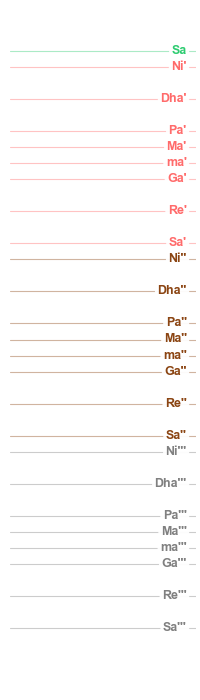
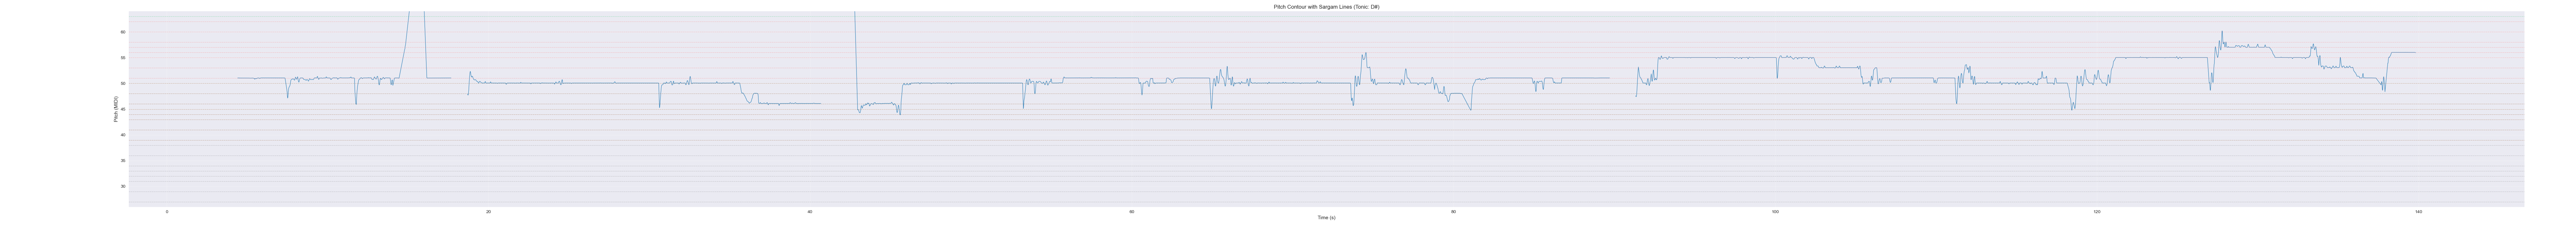

In [22]:
# ▶️ Wide pitch plot with tonic-relative sargam lines (COLOR-CODED BY OCTAVE)
def plot_pitch_with_sargam_lines(pr, tonic_ref=None, raga_name=None, figsize_width=80, figsize_height=10, dpi=10, join_gap_threshold=2.0):
    """Plot wide pitch contour and overlay horizontal lines for the raga-specific notes relative to tonic.
    Notes are color-coded by octave instead of using lowercase.
    """
    if tonic_ref is None:
        tonic_ref = globals().get('tonic', globals().get('TONIC', 'C'))
    if raga_name is None:
        raga_name = globals().get('raga_name', 'Bhairav')
    
    try:
        tonic_midi_base = librosa.note_to_midi(str(tonic_ref) + '4')
        tonic_midi = int(tonic_midi_base) % 12
    except Exception as e:
        try:
            tonic_midi_base = librosa.hz_to_midi(float(tonic_ref))
            tonic_midi = int(tonic_midi_base) % 12
        except Exception:
            tonic_midi_base = 60
            tonic_midi = 0
    
    # Get raga-specific notes
    raga_notes = None
    try:
        if 'raga_df' in globals():
            raga_notes = get_raga_notes(globals()['raga_df'], raga_name, tonic_ref)
            print(f"Using raga-specific notes for {raga_name}: {len(raga_notes)} notes")
    except Exception as e:
        print(f"Could not load raga notes: {e}. Using all 12 semitones.")
    
    OFFSET_TO_SARGAM = {
        0: 'Sa', 1: 're', 2: 'Re', 3: 'ga', 4: 'Ga', 5: 'ma', 
        6: 'Ma', 7: 'Pa', 8: 'dha', 9: 'Dha', 10: 'ni', 11: 'Ni'
    }
    
    # Define colors for each octave
    OCTAVE_COLORS = {
        -2: '#8B4513',  # Brown (two octaves below)
        -1: '#FF6B6B',  # Red (one octave below)
        0:  '#2ECC71',  # Green (middle octave)
        1:  '#3498DB',  # Blue (one octave above)
        2:  '#9B59B6',  # Purple (two octaves above)
    }
    
    pitch_hz = getattr(pr, 'pitch_hz', np.array([]))
    if pitch_hz is None or len(pitch_hz) == 0:
        from IPython.display import HTML, display
        display(HTML('<em>No pitch data to plot.</em>'))
        return
    
    frame_period = getattr(pr, 'frame_period', 0.01)
    timestamps = getattr(pr, 'timestamps', None)
    if timestamps is None:
        timestamps = np.arange(len(pitch_hz)) * frame_period
    voicing = getattr(pr, 'voicing', np.ones_like(pitch_hz, dtype=bool))
    voiced_mask = (pitch_hz > 0) & voicing
    voiced_midi = librosa.hz_to_midi(pitch_hz[voiced_mask]) if np.any(voiced_mask) else np.array([])
    
    # Calculate 3-octave range
    if np.any(voiced_midi):
        median_midi = np.median(voiced_midi)
        median_offset_from_tonic = median_midi - tonic_midi_base
        median_octave = int(np.floor(median_offset_from_tonic / 12))
        center_sa_midi = tonic_midi_base + median_octave * 12
        min_m = center_sa_midi - 12
        max_m = center_sa_midi + 24
        print(f"Median MIDI: {median_midi:.1f}, Center Sa: {center_sa_midi:.1f}")
        print(f"Displaying 3 octaves: {min_m:.1f} to {max_m:.1f} MIDI")
    else:
        center_sa_midi = tonic_midi_base
        min_m = center_sa_midi - 12
        max_m = center_sa_midi + 24
    
    rng = np.arange(int(np.floor(min_m)), int(np.ceil(max_m)) + 1)
    
    # Create main plot
    fig, ax = plt.subplots(figsize=(figsize_width, figsize_height), dpi=dpi)
    fig.subplots_adjust(left=0.05, right=0.98, top=0.95, bottom=0.08)
    
    if np.any(voiced_mask):
        voiced_times = timestamps[voiced_mask]
        time_diffs = np.diff(voiced_times)
        gap_threshold = frame_period * 3
        gap_indices = np.where(time_diffs > gap_threshold)[0]
        
        segments = []
        start_idx = 0
        for gap_idx in gap_indices:
            end_idx = gap_idx + 1
            segments.append((start_idx, end_idx))
            start_idx = end_idx
        segments.append((start_idx, len(voiced_times)))
        
        joined_segments = []
        current_segment = segments[0] if segments else None
        for next_segment in segments[1:]:
            prev_end_time = voiced_times[current_segment[1] - 1]
            next_start_time = voiced_times[next_segment[0]]
            if next_start_time - prev_end_time <= join_gap_threshold:
                current_segment = (current_segment[0], next_segment[1])
            else:
                joined_segments.append(current_segment)
                current_segment = next_segment
        if current_segment:
            joined_segments.append(current_segment)
        
        for segment in joined_segments:
            seg_slice = slice(segment[0], segment[1])
            ax.plot(voiced_times[seg_slice], voiced_midi[seg_slice], color='tab:blue', linewidth=1.0, alpha=0.85)
        
        print(f"Joined {len(segments)} original segments into {len(joined_segments)} continuous segments")
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pitch (MIDI)')
    ax.set_title(f'Pitch Contour with Sargam Lines (Tonic: {tonic_ref})')
    ax.grid(alpha=0.3)
    ax.set_ylim(min_m - 1, max_m + 1)
    
    # Draw horizontal lines (color-coded by octave)
    for midi_val in rng:
        pc = int(midi_val) % 12
        offset = (pc - tonic_midi) % 12
        
        if raga_notes is None or pc in raga_notes:
            label = OFFSET_TO_SARGAM.get(offset, '')
            octave_diff = int((midi_val - tonic_midi_base) // 12)
            
            # Add octave markers WITHOUT lowercase
            if octave_diff < 0:
                label = label + "'" * abs(octave_diff)
            elif octave_diff > 0:
                label = label + "·" * octave_diff
            
            # Get color for this octave
            line_color = OCTAVE_COLORS.get(octave_diff, 'gray')
            line_alpha = 0.4 if (raga_notes is not None and pc in raga_notes) else 0.15
            
            ax.axhline(y=midi_val, color=line_color, alpha=line_alpha, linewidth=0.8, linestyle='--')
    
    # Save main plot
    import io, base64
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=dpi)
    plt.close(fig)
    png_b64 = base64.b64encode(buf.getvalue()).decode('ascii')
    pixel_width = int(figsize_width * dpi)
    
    # Create legend with color-coded labels
    legend_fig, legend_ax = plt.subplots(figsize=(2, figsize_height), dpi=dpi)
    legend_fig.subplots_adjust(left=0.05, right=0.98, top=0.95, bottom=0.08)
    legend_ax.set_xlim(0, 1)
    legend_ax.set_ylim(min_m - 1, max_m + 1)
    legend_ax.axis('off')
    
    for midi_val in rng:
        pc = int(midi_val) % 12
        offset = (pc - tonic_midi) % 12
        
        if raga_notes is None or pc in raga_notes:
            label = OFFSET_TO_SARGAM.get(offset, '')
            octave_diff = int((midi_val - tonic_midi_base) // 12)
            
            # Add octave markers WITHOUT lowercase
            if octave_diff < 0:
                label = label + "'" * abs(octave_diff)
            elif octave_diff > 0:
                label = label + "·" * octave_diff
            
            # Get color for this octave
            text_color = OCTAVE_COLORS.get(octave_diff, 'gray')
            text_alpha = 1.0 if (raga_notes is not None and pc in raga_notes) else 0.7
            text_weight = 'bold' if (raga_notes is not None and pc in raga_notes) else 'normal'
            
            legend_ax.axhline(y=midi_val, color=text_color, alpha=0.4, linewidth=0.8, linestyle='-')
            legend_ax.text(0.95, midi_val, f"{label}", 
                          fontsize=9, color=text_color, alpha=text_alpha, weight=text_weight,
                          verticalalignment='center', horizontalalignment='right',
                          bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.95, edgecolor='none'))
    
    legend_buf = io.BytesIO()
    legend_fig.savefig(legend_buf, format='png', dpi=dpi)
    plt.close(legend_fig)
    legend_png_b64 = base64.b64encode(legend_buf.getvalue()).decode('ascii')
    
    from IPython.display import HTML, display
    html = f"""
    <div style='display: flex; width: 100%; border: 1px solid #e0e0e0;'>
        <div style='position: sticky; left: 0; z-index: 10; background: white; border-right: 1px solid #ddd;'>
            <img src='data:image/png;base64,{legend_png_b64}' style='display: block; margin: 0; padding: 0;'/>
        </div>
        <div style='overflow-x: auto; flex: 1;'>
            <div style='width: {pixel_width}px;'>
                <img src='data:image/png;base64,{png_b64}' style='display: block; margin: 0; padding: 0;'/>
            </div>
        </div>
    </div>
    """
    display(HTML(html))

# Run the plot
try:
    _pr = result_v if 'result_v' in globals() else (result_a if 'result_a' in globals() else None)
    if _pr is None and 'vocals_path' in globals():
        y, sr = librosa.load(vocals_path, sr=None)
        detector = SwiftF0(fmin=librosa.note_to_hz('B1'), fmax=librosa.note_to_hz('C5'))
        _pr = detector.detect_from_array(y, sr)
    if _pr is not None:
        plot_pitch_with_sargam_lines(_pr, tonic_ref=globals().get('tonic', globals().get('TONIC', 'C')), 
                                   figsize_width=80, figsize_height=7, dpi=100, join_gap_threshold=1.0)
except Exception as e:
    print('Error plotting pitch with sargam lines:', e)

In [23]:
import uuid
import plotly.graph_objects as go
from ipywidgets import widgets, VBox, HTML
from IPython.display import Javascript, display
import time


def create_audio_player_with_visualization(pr, audio_path, title="Audio Player", tonic_ref=None, raga_name=None):
    if tonic_ref is None:
        tonic_ref = globals().get("tonic", globals().get("TONIC", "C"))
    if raga_name is None:
        raga_name = globals().get("raga_name", "Hansadhwani")

    raga_notes = None
    try:
        if "raga_df" in globals() and "get_raga_notes" in globals():
            raga_notes = get_raga_notes(globals()["raga_df"], raga_name, tonic_ref)
    except Exception:
        raga_notes = None

    try:
        tonic_midi_base = librosa.note_to_midi(f"{tonic_ref}4")
        tonic_midi = int(tonic_midi_base) % 12
    except Exception:
        tonic_midi_base = 60
        tonic_midi = 0

    pitch_hz = getattr(pr, "pitch_hz", np.array([]))
    frame_period = getattr(pr, "frame_period", 0.01)
    timestamps = getattr(pr, "timestamps", None)
    if timestamps is None:
        timestamps = np.arange(len(pitch_hz)) * frame_period
    voicing = getattr(pr, "voicing", np.ones_like(pitch_hz, dtype=bool))
    voiced_mask = (pitch_hz > 0) & voicing

    if not np.any(voiced_mask):
        display(widgets.Audio.from_file(audio_path, autoplay=False))
        print(f"⚠️ No voiced data available for {title}")
        return

    voiced_times = np.asarray(timestamps[voiced_mask], dtype=float)
    voiced_midi = librosa.hz_to_midi(pitch_hz[voiced_mask])

    try:
        audio_duration = float(librosa.get_duration(path=audio_path))
    except Exception:
        audio_duration = float(voiced_times[-1])
    pitch_span = float(voiced_times[-1])
    total_duration = max(pitch_span, audio_duration)

    median_midi = float(np.median(voiced_midi))
    median_offset = median_midi - tonic_midi_base
    median_octave = int(np.floor(median_offset / 12))
    center_sa = tonic_midi_base + median_octave * 12
    min_midi = center_sa - 12
    max_midi = center_sa + 24

    fig = go.FigureWidget(
        layout=go.Layout(
            width=900,
            height=420,
            margin=dict(l=60, r=120, t=60, b=60),
            xaxis=dict(title="Time (s)", autorange=True),
            yaxis=dict(title="Pitch (MIDI)", autorange=True),
            showlegend=False,
        )
    )

    fig.add_scatter(
        x=voiced_times,
        y=voiced_midi,
        mode="lines",
        line=dict(color="royalblue", width=1.5),
        name="Pitch contour",
    )

    OFFSET_TO_SARGAM = {0: "Sa", 1: "re", 2: "Re", 3: "ga", 4: "Ga", 5: "ma", 6: "Ma", 7: "Pa", 8: "dha", 9: "Dha", 10: "ni", 11: "Ni"}
    OCTAVE_COLORS = {-2: "#8B4513", -1: "#FF6B6B", 0: "#2ECC71", 1: "#3498DB", 2: "#9B59B6"}

    for midi_val in range(int(min_midi), int(max_midi) + 1):
        pc = int(midi_val) % 12
        offset = (pc - tonic_midi) % 12
        if raga_notes is None or pc in raga_notes:
            label = OFFSET_TO_SARGAM.get(offset, "")
            octave_diff = int((midi_val - tonic_midi_base) // 12)
            if octave_diff < 0:
                label += "'" * abs(octave_diff)
            elif octave_diff > 0:
                label += "·" * octave_diff
            line_color = OCTAVE_COLORS.get(octave_diff, "gray")
            line_alpha = 0.30 if (raga_notes is not None and pc in raga_notes) else 0.12
            fig.add_shape(
                type="line",
                x0=0,
                x1=total_duration,
                y0=midi_val,
                y1=midi_val,
                line=dict(color=line_color, width=0.7, dash="dash"),
                opacity=line_alpha,
            )
            fig.add_annotation(
                x=total_duration,
                y=midi_val,
                text=label,
                xanchor="left",
                yanchor="middle",
                font=dict(size=10, color=line_color),
                showarrow=False,
            )

    cursor_index = len(fig.layout.shapes)
    fig.add_shape(
        type="line",
        x0=0,
        x1=0,
        y0=0,
        y1=1,
        xref="x",
        yref="paper",
        line=dict(color="crimson", width=2),
    )

    time_slider = widgets.FloatSlider(
        value=0.0,
        min=0.0,
        max=total_duration,
        step=0.05,
        description="Time (s)",
        readout_format=".2f",
        layout=widgets.Layout(width="100%"),
        continuous_update=True,
    )
    midi_label = HTML("<b>Cursor:</b> 0.00&nbsp;s | MIDI — (—)")

    # Store current state to prevent feedback loops
    sync_state = {'updating': False}

    def update_cursor(change):
        if sync_state['updating']:
            return
        current_time = float(change["new"])
        with fig.batch_update():
            fig.layout.shapes[cursor_index].update(x0=current_time, x1=current_time)
        if voiced_times.size:
            midi_val = float(
                np.interp(
                    current_time,
                    voiced_times,
                    voiced_midi,
                    left=voiced_midi[0],
                    right=voiced_midi[-1],
                )
            )
            note_label = librosa.midi_to_note(np.array([midi_val]), unicode=True)[0]
            midi_label.value = f"<b>Cursor:</b> {current_time:.2f}&nbsp;s | MIDI {midi_val:.2f} ({note_label})"
        else:
            midi_label.value = f"<b>Cursor:</b> {current_time:.2f}&nbsp;s | MIDI — (—)"

    update_cursor({"new": time_slider.value})
    time_slider.observe(update_cursor, names="value")

    audio_widget = widgets.Audio.from_file(audio_path, autoplay=False)
    audio_widget.layout = widgets.Layout(width="100%")
    audio_id = f"audio-{uuid.uuid4().hex}"
    audio_widget.add_class(audio_id)

    instructions = HTML("<small>Use the audio controls or drag the slider; the cursor stays in sync.</small>")

    player_box = VBox(
        [
            HTML(f"<h3 style='margin-bottom:6px;'>{title}</h3>"),
            audio_widget,
            fig,
            time_slider,
            midi_label,
            instructions,
        ]
    )

    display(player_box)

    # VS Code-compatible synchronization approach
    # Uses DOM manipulation directly without requiring widget manager
    js_code = f"""
    (function() {{
        var audioSelector = 'audio.{audio_id}';
        var sliderSelector = '.widget-slider[data-model-id="{time_slider.model_id}"]';
        var maxRetries = 100;
        var retryCount = 0;
        var syncingFromAudio = false;
        var sliderMax = {total_duration};
        
        console.log('🎵 VS Code Audio Sync: Starting for', audioSelector);
        
        function setupDirectSync() {{
            var audioElem = document.querySelector(audioSelector);
            var sliderContainer = document.querySelector(sliderSelector);
            
            if (!audioElem) {{
                retryCount++;
                if (retryCount < maxRetries) {{
                    setTimeout(setupDirectSync, 100);
                }} else {{
                    console.error('❌ Audio element not found');
                }}
                return;
            }}
            
            console.log('Audio element found');
            
            // Try to find the slider input element
            var sliderInput = null;
            if (sliderContainer) {{
                sliderInput = sliderContainer.querySelector('input[type="range"]');
            }}
            
            if (!sliderInput) {{
                // Alternative: search for any slider input near the audio
                var allSliders = document.querySelectorAll('input[type="range"]');
                for (var i = 0; i < allSliders.length; i++) {{
                    var parent = allSliders[i].closest('.widget-slider');
                    if (parent && parent.textContent.includes('Time')) {{
                        sliderInput = allSliders[i];
                        break;
                    }}
                }}
            }}
            
            if (!sliderInput) {{
                console.warn('⚠️ Slider input not found, using polling fallback');
                setupPollingFallback(audioElem);
                return;
            }}
            
            console.log('Slider input found');
            
            // Audio -> Slider sync
            function updateSliderFromAudio() {{
                if (syncingFromAudio) return;
                var currentTime = Math.min(audioElem.currentTime || 0, sliderMax);
                syncingFromAudio = true;
                sliderInput.value = currentTime;
                sliderInput.dispatchEvent(new Event('input', {{ bubbles: true }}));
                setTimeout(function() {{ syncingFromAudio = false; }}, 50);
            }}
            
            // Slider -> Audio sync
            function updateAudioFromSlider(e) {{
                if (syncingFromAudio) return;
                var newVal = parseFloat(sliderInput.value);
                if (Math.abs((audioElem.currentTime || 0) - newVal) > 0.1) {{
                    audioElem.currentTime = newVal;
                }}
            }}
            
            audioElem.addEventListener('timeupdate', updateSliderFromAudio);
            audioElem.addEventListener('seeked', updateSliderFromAudio);
            audioElem.addEventListener('play', updateSliderFromAudio);
            audioElem.addEventListener('pause', updateSliderFromAudio);
            audioElem.addEventListener('ended', function() {{
                syncingFromAudio = true;
                sliderInput.value = sliderMax;
                sliderInput.dispatchEvent(new Event('input', {{ bubbles: true }}));
                setTimeout(function() {{ syncingFromAudio = false; }}, 50);
            }});
            
            sliderInput.addEventListener('input', updateAudioFromSlider);
            sliderInput.addEventListener('change', updateAudioFromSlider);
            
            console.log('Direct DOM sync established');
        }}
        
        function setupPollingFallback(audioElem) {{
            // Fallback: Use custom events to communicate with Python
            var lastTime = 0;
            setInterval(function() {{
                if (audioElem && !audioElem.paused) {{
                    var currentTime = audioElem.currentTime || 0;
                    if (Math.abs(currentTime - lastTime) > 0.1) {{
                        lastTime = currentTime;
                        // Dispatch custom event that could be picked up
                        var event = new CustomEvent('audioTimeUpdate', {{
                            detail: {{ time: currentTime }}
                        }});
                        document.dispatchEvent(event);
                    }}
                }}
            }}, 100);
            console.log('Polling fallback active');
        }}
        
        setTimeout(setupDirectSync, 300);
    }})();
    """
    display(Javascript(js_code))

    print(f"Duration (pitch span): {pitch_span:.2f} s")
    print(f"Duration (audio): {audio_duration:.2f} s")
    print(f"Pitch range: MIDI {min_midi:.0f}–{max_midi:.0f}")
    print(f"Total voiced frames: {len(voiced_times)}")


print("=" * 70)
print("🎵 INTERACTIVE AUDIO PLAYERS WITH PITCH VISUALIZATION")
print("=" * 70)

if "result_v" in globals() and "vocals_path" in globals():
    print("\nVOCALS PLAYER:")
    create_audio_player_with_visualization(
        result_v,
        vocals_path,
        title="Vocals",
        tonic_ref=globals().get("tonic", "C"),
        raga_name=globals().get("raga_name", "Hansadhwani"),
    )

if "result_a" in globals() and "accompaniment_path" in globals():
    print("\nACCOMPANIMENT PLAYER:")
    create_audio_player_with_visualization(
        result_a,
        accompaniment_path,
        title="Accompaniment",
        tonic_ref=globals().get("tonic", "C"),
        raga_name=globals().get("raga_name", "Hansadhwani"),
    )

if "audio_path" in globals() and "result_v" in globals():
    print("\nORIGINAL MIX PLAYER:")
    create_audio_player_with_visualization(
        result_v,
        audio_path,
        title="Original Mix",
        tonic_ref=globals().get("tonic", "C"),
        raga_name=globals().get("raga_name", "Hansadhwani"),
    )

🎵 INTERACTIVE AUDIO PLAYERS WITH PITCH VISUALIZATION

VOCALS PLAYER:
Raga 'Maru Bihag' in tonic 'D#': ['C', 'D', 'D#', 'F', 'G', 'G#', 'A', 'A#']


<IPython.core.display.Javascript object>

Duration (pitch span): 139.82 s
Duration (audio): 139.95 s
Pitch range: MIDI 27–63
Total voiced frames: 7803

ACCOMPANIMENT PLAYER:
Raga 'Maru Bihag' in tonic 'D#': ['C', 'D', 'D#', 'F', 'G', 'G#', 'A', 'A#']


<IPython.core.display.Javascript object>

Duration (pitch span): 139.10 s
Duration (audio): 139.95 s
Pitch range: MIDI 39–75
Total voiced frames: 4805

ORIGINAL MIX PLAYER:
Raga 'Maru Bihag' in tonic 'D#': ['C', 'D', 'D#', 'F', 'G', 'G#', 'A', 'A#']


<IPython.core.display.Javascript object>

Duration (pitch span): 139.82 s
Duration (audio): 139.79 s
Pitch range: MIDI 27–63
Total voiced frames: 7803


Successfully built the new interval-based rāga database.
Computed high-resolution histogram with shape: (100,)
Computed low-resolution histogram with shape: (33,)
[PEAKS] high-res smoothed: found 8 peaks (prom=36.51, dist=2)
[MINIMA] high-res smoothed: found 9 minima (prom>=24.30, dist=2)
[PEAKS] low-res: found 8 peaks (prom=25.59)
[DEBUG] high-res peak sample (idx, cents, count, prom):
  idx=0, cents=6.0, count=44.0, prom=0.00
  idx=17, cents=210.0, count=1217.0, prom=1211.00
  idx=25, cents=306.0, count=795.0, prom=723.00
  idx=41, cents=498.0, count=91.0, prom=84.00
  idx=58, cents=702.0, count=491.0, prom=486.00
  idx=66, cents=798.0, count=51.0, prom=45.00
  idx=75, cents=906.0, count=76.0, prom=66.00
  idx=84, cents=1014.0, count=158.0, prom=153.00
Tonic reference: D#, MIDI base: 63, Pitch class: 3
Generating *normalized* histogram plot with western-note x-axis and ±35¢ note zones...


/var/folders/dr/7jrw49755h70bsy03x6hy14c0000gn/T/ipykernel_4523/27465224.py:75: PeakPropertyWarning:

some peaks have a prominence of 0



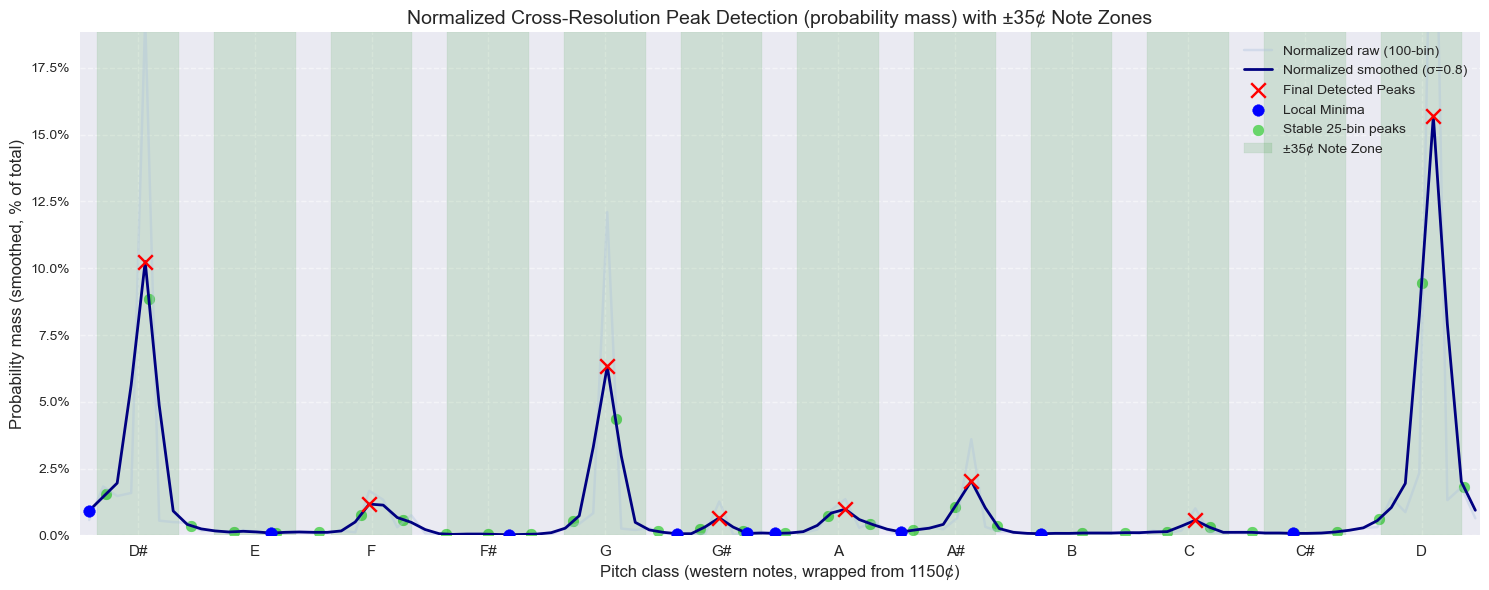

[INFO] detected_peak_count = 8

Found 8 precise peaks (100-bin) and 8 stable regions (25-bin).
Validated 8 final peaks.
Pitch-class candidates passed to next stage (±35¢ rule): [0, 2, 3, 5, 7, 8, 9, 10]


In [24]:
from collections import defaultdict
from scipy.signal import find_peaks, peak_prominences
from scipy.ndimage import gaussian_filter1d

# canonical form: lexicographically smallest rotation of the pattern
def get_canonical_intervals(intervals):
    if not isinstance(intervals, tuple) or not intervals:
        return tuple()
    return min(tuple(np.roll(intervals, i)) for i in range(len(intervals)))

# load processed raga hash table
raga_df = pd.read_csv('/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/db/raga_list_final.csv')

# build lookup: canonical interval pattern → list of matching ragas
raga_interval_db = defaultdict(list)

for _, row in raga_df.iterrows():
    if 'mask' in raga_df.columns:
        mask_abs = tuple(map(int, row['mask'].split(',')))
        name = row['raga']
    else:
        mask_abs = tuple(int(row[str(i)]) for i in range(12))
        name = row['names']

    p = np.where(np.array(mask_abs) == 1)[0]
    if len(p) < 2:
        continue
    p.sort()
    intervals = tuple(np.mod(np.diff(np.concatenate((p, [p[0] + 12]))), 12))
    if sum(intervals) != 12:
        continue
    canonical_pattern = get_canonical_intervals(intervals)
    raga_interval_db[canonical_pattern].append({'name': name, 'intervals': intervals})

raga_masks = raga_interval_db
print("Successfully built the new interval-based rāga database.")

# compute high- and low-resolution histograms
num_bins_high_res = 100
num_bins_low_res = 33
sigma = 0.8

midi_vals_mel = librosa.hz_to_midi(valid_freqs_v)
cent_values = (midi_vals_mel % 12) * 100

H_mel_100, bin_edges_100 = np.histogram(cent_values, bins=num_bins_high_res, range=(0, 1200))
H_mel_25, bin_edges_25 = np.histogram(cent_values, bins=num_bins_low_res, range=(0, 1200))

print(f"Computed high-resolution histogram with shape: {H_mel_100.shape}")
print(f"Computed low-resolution histogram with shape: {H_mel_25.shape}")



# ---------------- Replacement for "part a: find peaks in both histograms and convert to cents" --------------
from scipy.signal import find_peaks, peak_prominences

# smoothed_H_100 and bin_centers_100 already computed above
smoothed_H_100 = gaussian_filter1d(H_mel_100, sigma=sigma, mode='wrap')
bin_centers_100 = (bin_edges_100[:-1] + bin_edges_100[1:]) / 2.0

# helper: circular-aware peak finder using scipy.find_peaks
def find_circular_peaks(arr, prominence=None, distance=None, height=None):
    n = len(arr)
    peaks, props = find_peaks(arr, prominence=prominence, distance=distance, height=height)
    peaks = list(peaks)

    # simple wrap checks for index 0 and n-1 (find_peaks treats array as linear)
    if n >= 2:
        if 0 not in peaks and arr[0] > arr[1] and arr[0] > arr[-1]:
            peaks.append(0)
        if (n - 1) not in peaks and arr[-1] > arr[-2] and arr[-1] > arr[0]:
            peaks.append(n - 1)

    peaks = sorted(set(peaks))
    prominences = peak_prominences(arr, peaks)[0] if peaks else np.array([])
    return np.array(peaks, dtype=int), props, prominences

# helper: more robust circular minima using array extension around the seam
# detects maxima on -arr in an extended array and maps them back, deduplicating by highest prominence

def find_circular_minima_extended(arr, prominence=None, distance=None):
    n = len(arr)
    pad = max(int(distance or 1), 3)
    ext = np.concatenate([arr[-pad:], arr, arr[:pad]])
    # find maxima on the negated extended signal
    peaks_ext, _ = find_peaks(-ext, prominence=prominence, distance=distance, height=None)
    if peaks_ext.size == 0:
        return np.array([], dtype=int), np.array([])
    prom_ext = peak_prominences(-ext, peaks_ext)[0]

    # map back to base indices and keep only the strongest per base bin
    best = {}
    for eidx, pval in zip(peaks_ext, prom_ext):
        base_idx = (eidx - pad) % n
        if (base_idx not in best) or (pval > best[base_idx][0]):
            best[base_idx] = (float(pval), int(eidx))

    final_indices = np.array(sorted(best.keys()))
    final_prom = np.array([best[i][0] for i in final_indices])
    return final_indices.astype(int), final_prom

# --- parameters you can tune ---
prom_high = max(1.0, 0.03 * float(smoothed_H_100.max()))  # default: 3% of max or at least 1
dist_high = 2   # min separation in bins for high-res (2 bins ≈ 24 cents if 100 bins -> 12 semitones)
height_high = None

# find high-res peaks in smoothed histogram
smoothed_peaks_100_indices, sm_props_high, sm_high_proms = find_circular_peaks(
    smoothed_H_100, prominence=prom_high, distance=dist_high, height=height_high
)
smoothed_peaks_cents = bin_centers_100[smoothed_peaks_100_indices]
print(f"[PEAKS] high-res smoothed: found {len(smoothed_peaks_100_indices)} peaks (prom={prom_high:.2f}, dist={dist_high})")

# Also find local minima with robust circular handling across the 1200↔0 seam
min_prom = max(1.0, 0.02 * float(smoothed_H_100.max() - smoothed_H_100.min()))
min_dist = dist_high
smoothed_minima_100_indices, sm_min_proms = find_circular_minima_extended(
    smoothed_H_100, prominence=min_prom, distance=min_dist
)
smoothed_minima_cents = bin_centers_100[smoothed_minima_100_indices]
print(f"[MINIMA] high-res smoothed: found {len(smoothed_minima_100_indices)} minima (prom>={min_prom:.2f}, dist={min_dist})")

# low-res histogram (25 bins)
bin_centers_25 = (bin_edges_25[:-1] + bin_edges_25[1:]) / 2.0
prom_low = max(0, 0.01 * float(H_mel_25.max()))
dist_low = 1
raw_peaks_25_indices, low_props, low_proms = find_circular_peaks(
    H_mel_25, prominence=prom_low, distance=dist_low, height=None
)
raw_peaks_cents = bin_centers_25[raw_peaks_25_indices]
print(f"[PEAKS] low-res: found {len(raw_peaks_25_indices)} peaks (prom={prom_low:.2f})")

# Print some diagnostics (optional, helpful while tuning)
if len(smoothed_peaks_100_indices):
    print("[DEBUG] high-res peak sample (idx, cents, count, prom):")
    for p_idx, p_prom in zip(smoothed_peaks_100_indices[:8], sm_high_proms[:8]):
        print(f"  idx={int(p_idx)}, cents={bin_centers_100[int(p_idx)]:.1f}, count={smoothed_H_100[int(p_idx)]:.1f}, prom={p_prom:.2f}")
# ----------------------------------------------------------------------------------------------------------


# config
note_centers = np.arange(0, 1200, 100)
tolerance_cents = 35
peak_tolerance_cents = 45
# shift plot start to avoid splitting the C note, and then add tonic offset
# Get the pitch class (0-11) from the tonic MIDI base
tonic_ref = globals().get('tonic', globals().get('TONIC', 'C'))
tonic_midi_base = librosa.note_to_midi(str(tonic_ref) + '4')
tonic_pitch_class = int(tonic_midi_base) % 12
print(f"Tonic reference: {tonic_ref}, MIDI base: {tonic_midi_base}, Pitch class: {tonic_pitch_class}")
# Calculate shift: 50 cents base offset + (tonic pitch class * 100 cents)
tonic_position_cents = tonic_pitch_class * 100  # 1100 for B
WRAP_START = (tonic_position_cents - 50) % 1200  # Start 50¢ before tonic

# part b: validate precise peaks using stable peaks + ±35¢ note center rule
final_peak_indices_100 = []
for i, sp_cent in zip(smoothed_peaks_100_indices, smoothed_peaks_cents):
    is_validated = any(abs(sp_cent - rp_cent) <= peak_tolerance_cents for rp_cent in raw_peaks_cents)
    if not is_validated:
        continue
    diffs = np.abs((sp_cent - note_centers + 600) % 1200 - 600)
    if np.min(diffs) <= tolerance_cents:
        final_peak_indices_100.append(i)

import matplotlib.ticker as mtick

def wrap_for_plot(values, start=WRAP_START, period=1200):
    """Wrap cent values so the plot window starts at WRAP_START cents."""
    arr = np.asarray(values, dtype=float)
    return np.where(arr < start, arr + period, arr)

# normalized plotting
smoothed_H_100_norm = smoothed_H_100.astype(float)
total = smoothed_H_100_norm.sum()
if total <= 0:
    smoothed_H_100_plot = smoothed_H_100_norm
else:
    smoothed_H_100_plot = smoothed_H_100_norm / total
H_mel_100_norm = H_mel_100.astype(float) / (H_mel_100.sum() + 1e-12)

bin_centers_plot = wrap_for_plot(bin_centers_100)
sort_idx = np.argsort(bin_centers_plot)
bin_centers_plot_sorted = bin_centers_plot[sort_idx]
H_mel_100_norm_sorted = H_mel_100_norm[sort_idx]
smoothed_H_100_plot_sorted = smoothed_H_100_plot[sort_idx]

print("Generating *normalized* histogram plot with western-note x-axis and ±35¢ note zones...")

NOTE_NAMES = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
plt.figure(figsize=(15, 6))
plt.plot(bin_centers_plot_sorted, H_mel_100_norm_sorted, color='lightsteelblue', alpha=0.4, label='Normalized raw (100-bin)')
plt.plot(bin_centers_plot_sorted, smoothed_H_100_plot_sorted, color='navy', linewidth=2, label=f'Normalized smoothed (σ={sigma})')
peak_x_values = wrap_for_plot(bin_centers_100[final_peak_indices_100])
peak_y_values_plot = smoothed_H_100_plot[final_peak_indices_100]
plt.scatter(peak_x_values, peak_y_values_plot, color='red', s=110, marker='x',
            zorder=6, label='Final Detected Peaks')

# plot local minima on the smoothed histogram in blue
if len(smoothed_minima_100_indices):
    minima_x_values = wrap_for_plot(bin_centers_100[smoothed_minima_100_indices])
    minima_y_values_plot = smoothed_H_100_plot[smoothed_minima_100_indices]
    plt.scatter(minima_x_values, minima_y_values_plot, color='blue', s=70, marker='o',
                zorder=6, label='Local Minima')

low_centers = bin_centers_25
low_centers_plot = wrap_for_plot(low_centers)
low_vals_plot = np.interp(low_centers_plot, bin_centers_plot_sorted, smoothed_H_100_plot_sorted)
plt.scatter(low_centers_plot, low_vals_plot, color='limegreen', s=60, marker='o', alpha=0.7, label='Stable 25-bin peaks')
for idx, center in enumerate(note_centers):
    center_plot = wrap_for_plot([center])[0]
    low = center_plot - tolerance_cents
    high = center_plot + tolerance_cents
    plt.axvspan(low, high, color='green', alpha=0.12, label='±35¢ Note Zone' if idx == 0 else "")
xticks_positions = wrap_for_plot(note_centers)
plt.xticks(ticks=xticks_positions, labels=NOTE_NAMES, fontsize=11)
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.ylabel("Probability mass (smoothed, % of total)", fontsize=12)
plt.title("Normalized Cross-Resolution Peak Detection (probability mass) with ±35¢ Note Zones", fontsize=14)
plt.xlabel("Pitch class (western notes, wrapped from 1150¢)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')
plt.xlim(WRAP_START, WRAP_START + 1200)
plt.ylim(0, max(smoothed_H_100_plot.max() * 1.2, 0.01))
plt.tight_layout()
plt.show()

# part d: final output for downstream cell
final_peak_cents = bin_centers_100[final_peak_indices_100]
pc_cand = set()
for cent_val in final_peak_cents:
    diffs = np.abs((cent_val - note_centers + 600) % 1200 - 600)
    nearest_idx = np.argmin(diffs)
    if diffs[nearest_idx] <= tolerance_cents:
        pc_cand.add(nearest_idx % 12)
pc_cand = sorted(pc_cand)
cent_to_pc = np.round(bin_centers_100 / 100).astype(int) % 12
#pc_cand = sorted(list({cent_to_pc[i] for i in final_peak_indices_100}))
if 'pc_cand' in globals():
    detected_peak_count = len(pc_cand)
print(f"[INFO] detected_peak_count = {detected_peak_count}")
print(f"\nFound {len(smoothed_peaks_cents)} precise peaks (100-bin) and {len(raw_peaks_cents)} stable regions (25-bin).")
print(f"Validated {len(final_peak_indices_100)} final peaks.")
print(f"Pitch-class candidates passed to next stage (±{tolerance_cents}¢ rule): {pc_cand}")
detected_peak_count = len(pc_cand)


=== Gaussian Mixture Model Analysis for Andolan Detection ===
Analyzing microtonal movements around detected peaks...

Fitting GMM to 8 detected peaks...
Peak positions (cents): ['6.0', '210.0', '306.0', '498.0', '702.0', '798.0', '906.0', '1014.0']
Peak at 6.0¢:
  Component 1: μ=467.39¢, σ=562.49¢, weight=1.000
  Log-likelihood: -7.75

Peak at 210.0¢:
  Component 1: μ=212.04¢, σ=19.98¢, weight=1.000
  Log-likelihood: -4.41

Peak at 306.0¢:
  Component 1: μ=300.57¢, σ=20.14¢, weight=1.000
  Log-likelihood: -4.42

Peak at 498.0¢:
  Component 1: μ=505.17¢, σ=23.74¢, weight=1.000
  Log-likelihood: -4.59

Peak at 702.0¢:
  Component 1: μ=701.24¢, σ=14.44¢, weight=1.000
  Log-likelihood: -4.09

Peak at 798.0¢:
  Component 1: μ=794.27¢, σ=29.86¢, weight=1.000
  Log-likelihood: -4.82

Peak at 906.0¢:
  Component 1: μ=908.55¢, σ=25.39¢, weight=1.000
  Log-likelihood: -4.65

Peak at 1014.0¢:
  Component 1: μ=1010.30¢, σ=20.57¢, weight=1.000
  Log-likelihood: -4.44



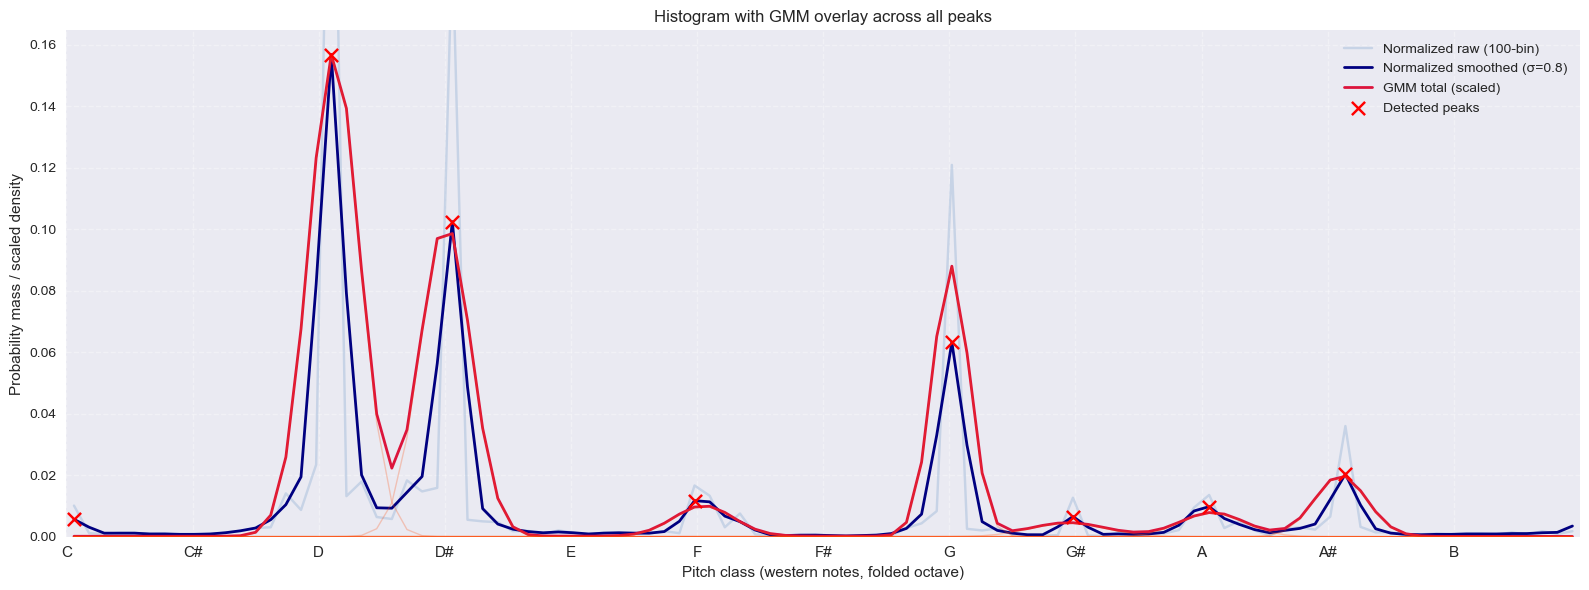


=== Summary of Andolan Analysis ===
Peak characteristics (potential andolan signatures):
----------------------------------------------------------------------
Peak 1: C region
  Original peak: 6.0¢, Height: 0.0057
  GMM center: 467.4¢ (σ=562.5¢, weight=1.00)
  Deviation from C: +467.4¢
  *** Significant deviation detected - possible shruti variation ***

Peak 2: D region
  Original peak: 210.0¢, Height: 0.1569
  GMM center: 212.0¢ (σ=20.0¢, weight=1.00)
  Deviation from D: +12.0¢

Peak 3: D# region
  Original peak: 306.0¢, Height: 0.1025
  GMM center: 300.6¢ (σ=20.1¢, weight=1.00)
  Deviation from D#: +0.6¢

Peak 4: F region
  Original peak: 498.0¢, Height: 0.0117
  GMM center: 505.2¢ (σ=23.7¢, weight=1.00)
  Deviation from F: +5.2¢

Peak 5: G region
  Original peak: 702.0¢, Height: 0.0633
  GMM center: 701.2¢ (σ=14.4¢, weight=1.00)
  Deviation from G: +1.2¢

Peak 6: G# region
  Original peak: 798.0¢, Height: 0.0066
  GMM center: 794.3¢ (σ=29.9¢, weight=1.00)
  Deviation from G#: -5.

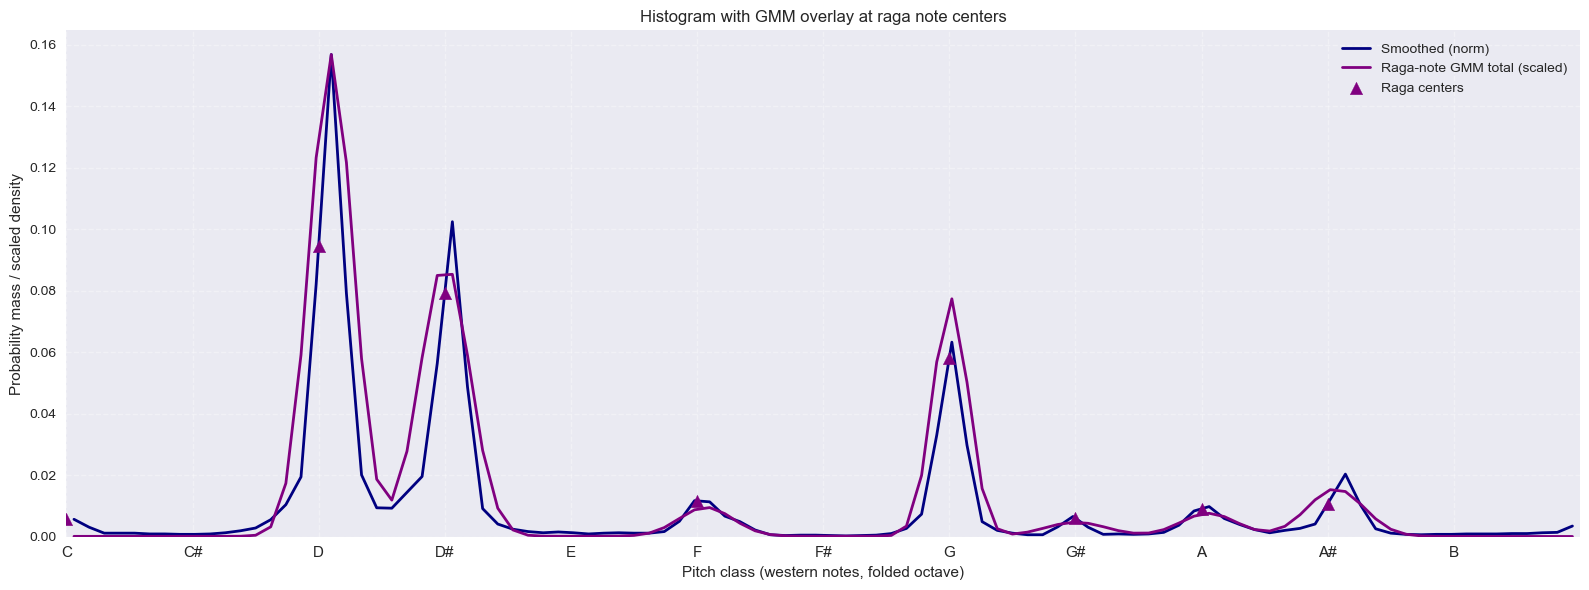

Saved note_gmm_vector_12_raga (rows C..B; cols: height, deviation, sigma)
[[  0.006 485.408 568.35 ]
 [    nan     nan     nan]
 [  0.157   9.843  17.059]
 [  0.102   0.139  19.601]
 [    nan     nan     nan]
 [  0.012   7.048  21.262]
 [    nan     nan     nan]
 [  0.063   1.     13.93 ]
 [  0.007   0.47   24.586]
 [  0.01    5.542  22.262]
 [  0.02    6.314  22.428]
 [    nan     nan     nan]]


In [25]:
from sklearn.mixture import GaussianMixture
from scipy import stats
import matplotlib.pyplot as plt

# Gaussian Mixture Model fitting for detected peaks to analyze microtonal movements
def fit_gmm_to_peaks(smoothed_histogram, bin_centers, peak_indices, n_components_per_peak=1,
                     window_width_cents=150, plot=True, overlay_plot=True, debug_per_peak=False,
                     base_series_1=None, base_label_1='Normalized raw (100-bin)',
                     base_series_2=None, base_label_2='Normalized smoothed'):
    """
    Fit Gaussian Mixture Models around each detected peak to analyze microtonal movements.

    Parameters:
    - smoothed_histogram: The smoothed histogram values (ideally normalized like smoothed_H_100_plot)
    - bin_centers: Cent positions corresponding to histogram bins (e.g., bin_centers_100)
    - peak_indices: Indices of detected peaks (e.g., final_peak_indices_100)
    - n_components_per_peak: Number of Gaussian components to fit per peak region
    - window_width_cents: Width of window around each peak for GMM fitting
    - plot: Enable plotting in general
    - overlay_plot: If True, draw a single full-range plot (0..1200) with base histogram(s) and GMM overlays
    - debug_per_peak: If True, draw detailed 2xN per-peak window plots (can be noisy for many peaks)
    - base_series_1/2: Optional baseline series to overlay (e.g., H_mel_100_norm and smoothed_H_100_plot)

    Returns:
    - gmm_results: List of dictionaries containing GMM parameters for each peak
    - note_gmm_vector_12: A (12, 3) numpy array with (height, deviation_from_center, sigma) per note
    """

    gmm_results = []
    peak_cents = bin_centers[peak_indices]

    # Initialize 12x3 vector: (height, deviation_from_center, sigma)
    note_centers = np.arange(0, 1200, 100)
    note_gmm_vector_12 = np.zeros((12, 3), dtype=float)
    note_gmm_vector_12[:] = np.nan  # fill with NaN until populated

    print(f"Fitting GMM to {len(peak_indices)} detected peaks...")
    print("Peak positions (cents):", [f"{cent:.1f}" for cent in peak_cents])

    # Optional per-peak debug plots
    if plot and debug_per_peak and len(peak_indices) > 0:
        cols = min(4, len(peak_indices))
        fig, axes = plt.subplots(2, cols, figsize=(4*cols, 8))
        if cols == 1:
            axes = axes.reshape(2, 1)

    # Collect all GMM components across peaks for global overlay
    all_components = []  # list of dicts: {mu, sigma, weight, peak_height}

    for i, (peak_idx, peak_cent) in enumerate(zip(peak_indices, peak_cents)):
        # Define window around peak (handling circular nature of cents)
        half_window = window_width_cents / 2

        # Bins within window (with wrap-around at 0/1200)
        distances = np.abs(bin_centers - peak_cent)
        distances = np.minimum(distances, 1200 - distances)  # circular distance
        window_mask = distances <= half_window

        if np.sum(window_mask) < 3:  # Need minimum data points
            print(f"Warning: Peak at {peak_cent:.1f}¢ has insufficient data for GMM fitting")
            continue

        # Extract data for this peak region
        window_cents = bin_centers[window_mask]
        window_values = smoothed_histogram[window_mask]

        # Create weighted samples for GMM (repeat each cent value according to its histogram value)
        # Scale values to create reasonable number of samples
        scale_factor = max(1, int(1000 / max(np.sum(window_values), 1e-6)))
        samples = []
        for cent, value in zip(window_cents, window_values):
            n_samples = max(1, int(value * scale_factor))
            samples.extend([cent] * n_samples)

        if len(samples) < 5:  # Minimum samples needed
            print(f"Warning: Peak at {peak_cent:.1f}¢ has too few samples for reliable GMM fitting")
            continue

        X = np.array(samples).reshape(-1, 1)

        # Fit GMM
        try:
            gmm = GaussianMixture(n_components=n_components_per_peak, random_state=42)
            gmm.fit(X)

            # Extract parameters
            means = gmm.means_.flatten()
            covariances = np.sqrt(gmm.covariances_.flatten())  # Standard deviations
            weights = gmm.weights_

            # Sort by weight (most prominent component first)
            sort_idx = np.argsort(weights)[::-1]
            means = means[sort_idx]
            covariances = covariances[sort_idx]
            weights = weights[sort_idx]

            # Calculate peak height from original histogram (normalized smoothed)
            peak_height = float(smoothed_histogram[peak_idx])

            # Store components for global overlay
            for mu, sigma, w in zip(means, covariances, weights):
                all_components.append({
                    'mu': float(mu),
                    'sigma': float(max(sigma, 1e-6)),  # guard against zero
                    'weight': float(w),
                    'peak_height': float(peak_height)
                })

            # Store results per-peak
            peak_result = {
                'original_peak_cent': float(peak_cent),
                'peak_height': peak_height,
                'gmm_means': means.tolist(),
                'gmm_sigmas': covariances.tolist(),
                'gmm_weights': weights.tolist(),
                'log_likelihood': float(gmm.score(X)),
                'n_samples': int(len(samples)),
                'window_range': (float(window_cents.min()), float(window_cents.max()))
            }
            gmm_results.append(peak_result)

            # Map this peak to the nearest note center and record tuple if not already recorded
            diffs_to_notes = np.abs((peak_cent - note_centers + 600) % 1200 - 600)
            nearest_note_idx = int(np.argmin(diffs_to_notes))
            # Use the primary component (highest weight)
            primary_mu = float(means[0])
            primary_sigma = float(covariances[0])
            deviation_from_note = (primary_mu - float(note_centers[nearest_note_idx]) + 600) % 1200 - 600
            # Only set if NaN (first peak mapped to this note wins). If multiple peaks map to same note,
            # keep the one with larger peak_height.
            existing = note_gmm_vector_12[nearest_note_idx]
            if np.isnan(existing[0]) or peak_height > existing[0]:
                note_gmm_vector_12[nearest_note_idx] = np.array([peak_height, deviation_from_note, primary_sigma])

            # Optional: per-peak debug plots (limit to first 4 columns)
            if plot and debug_per_peak and i < 4:
                x_range = np.linspace(window_cents.min(), window_cents.max(), 200)

                # Top subplot: Original histogram and GMM components
                ax_top = axes[0, i]
                ax_top.plot(window_cents, window_values, 'bo-', alpha=0.7, label='Original (window)')

                gmm_total = np.zeros_like(x_range)
                for j, (mu, sigma, weight) in enumerate(zip(means, covariances, weights)):
                    component = weight * peak_height * stats.norm.pdf(x_range, mu, sigma)
                    gmm_total += component
                    ax_top.plot(x_range, component, '--', alpha=0.8,
                                label=f'C{j+1}: μ={mu:.1f}¢, σ={sigma:.1f}¢')

                ax_top.plot(x_range, gmm_total, 'r-', linewidth=2, label='GMM Total')
                ax_top.axvline(peak_cent, color='red', linestyle=':', alpha=0.7, label='Original peak')
                ax_top.set_title(f'Peak @ {peak_cent:.1f}¢ | H={peak_height:.3f}')
                ax_top.set_xlabel('Cents')
                ax_top.set_ylabel('Normalized intensity')
                ax_top.legend(fontsize=8)
                ax_top.grid(True, alpha=0.3)

                # Bottom subplot: Residuals
                ax_bottom = axes[1, i]
                gmm_interp = np.interp(window_cents, x_range, gmm_total)
                residuals = window_values - gmm_interp
                ax_bottom.plot(window_cents, residuals, 'go-', alpha=0.7)
                ax_bottom.axhline(0, color='red', linestyle='-', alpha=0.5)
                ax_bottom.set_title('Residuals (Original - GMM)')
                ax_bottom.set_xlabel('Cents')
                ax_bottom.set_ylabel('Residual')
                ax_bottom.grid(True, alpha=0.3)

            # Console summary
            print(f"Peak at {peak_cent:.1f}¢:")
            for j, (mu, sigma, weight) in enumerate(zip(means, covariances, weights)):
                print(f"  Component {j+1}: μ={mu:.2f}¢, σ={sigma:.2f}¢, weight={weight:.3f}")
            print(f"  Log-likelihood: {gmm.score(X):.2f}\n")

        except Exception as e:
            print(f"Error fitting GMM to peak at {peak_cent:.1f}¢: {e}")
            continue

    if plot and debug_per_peak and len(peak_indices) > 0:
        plt.tight_layout()
        plt.show()

    # Single full-range overlay plot (0..1200) with base histogram(s) and all GMMs
    if plot and overlay_plot and len(all_components) > 0:
        x_full = bin_centers
        gmm_sum = np.zeros_like(x_full, dtype=float)
        component_curves = []  # for optional individual component overlays

        # Build unscaled GMM sum
        for comp in all_components:
            mu = comp['mu']
            sigma = comp['sigma']
            w = comp['weight']
            peak_h = comp['peak_height']
            curve = w * peak_h * stats.norm.pdf(x_full, mu, sigma)
            component_curves.append(curve)
            gmm_sum += curve

        # Scale GMM curves to be visually comparable to the smoothed histogram
        target_max = float(np.max(smoothed_histogram)) if np.max(smoothed_histogram) > 0 else 1.0
        current_max = float(np.max(gmm_sum)) if np.max(gmm_sum) > 0 else 1.0
        scale = target_max / current_max
        gmm_sum_scaled = gmm_sum * scale
        component_curves_scaled = [c * scale for c in component_curves]

        # Compose overlay plot
        plt.figure(figsize=(16, 6))

        # Base series: show raw-normalized and smoothed if available
        drew_any_base = False
        if base_series_1 is not None:
            plt.plot(bin_centers, base_series_1, color='lightsteelblue', alpha=0.6, label=base_label_1)
            drew_any_base = True
        if base_series_2 is not None:
            plt.plot(bin_centers, base_series_2, color='navy', linewidth=2, label=base_label_2)
            drew_any_base = True
        if not drew_any_base:
            # Fallback: draw the smoothed_histogram on its own
            plt.plot(bin_centers, smoothed_histogram, color='navy', linewidth=2, label='Smoothed (norm)')

        # Overlay: combined GMM sum
        plt.plot(x_full, gmm_sum_scaled, color='crimson', linewidth=2, label='GMM total (scaled)')

        # Optionally overlay individual components (limit to avoid clutter)
        max_components_to_draw = 24
        if len(component_curves_scaled) <= max_components_to_draw:
            for c in component_curves_scaled:
                plt.plot(x_full, c, color='orangered', alpha=0.25, linewidth=1)
        else:
            # Too many components; skip detailed component overlay
            pass

        # Show detected peak markers
        if len(peak_indices) > 0:
            peak_x = bin_centers[peak_indices]
            peak_y = smoothed_histogram[peak_indices]
            plt.scatter(peak_x, peak_y, color='red', s=90, marker='x', zorder=5, label='Detected peaks')

        # Cosmetic settings matching earlier plots
        xticks_positions = np.arange(0, 1200, 100)
        note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
        plt.xticks(ticks=xticks_positions, labels=note_names, fontsize=11)
        plt.xlim(0, 1200)
        ymax = max(float(np.max(smoothed_histogram)) * 1.05, 0.01)
        plt.ylim(0, ymax)
        plt.xlabel('Pitch class (western notes, folded octave)')
        plt.ylabel('Probability mass / scaled density')
        plt.title('Histogram with GMM overlay across all peaks')
        plt.grid(True, linestyle='--', alpha=0.35)
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

    return gmm_results, note_gmm_vector_12

# New: Fit GMMs centered on the selected raga's notes (independent of detected peaks)

def fit_gmm_to_raga_notes(smoothed_histogram, bin_centers, valid_pcs,
                          n_components_per_note=1, window_width_cents=120,
                          plot=True, overlay_plot=True,
                          base_series_1=None, base_label_1='Normalized raw (100-bin)',
                          base_series_2=None, base_label_2='Normalized smoothed',
                          mark_centers=True):
    """
    Fit Gaussians around the fixed note centers for a given raga using provided valid pitch classes,
    regardless of detected peaks.

    Parameters:
    - smoothed_histogram: normalized smoothed histogram (e.g., smoothed_H_100_plot)
    - bin_centers: cent positions of the histogram bins (0..1200)
    - valid_pcs: list/array of pitch classes (0..11) valid for the raga
    - n_components_per_note: number of GMM components to fit per raga note window
    - window_width_cents: total window width in cents around each note center (e.g. 120 = ±60)

    Returns:
    - gmm_results: list of dicts per raga note with fitted components
    - note_gmm_vector_12_raga: (12, 3) array [height, deviation_from_center, sigma] per pitch-class
    """
    centers_cents = (np.array(valid_pcs, dtype=int) % 12) * 100

    gmm_results = []
    note_gmm_vector_12_raga = np.full((12, 3), np.nan, dtype=float)

    all_components = []  # for global overlay

    def _circular_window_mask(center_cent, half_window):
        d = np.abs(bin_centers - center_cent)
        d = np.minimum(d, 1200 - d)
        return d <= half_window

    half_window = window_width_cents / 2.0

    for pc, center in zip(valid_pcs, centers_cents):
        window_mask = _circular_window_mask(center, half_window)
        if np.sum(window_mask) < 3:
            continue

        window_cents = bin_centers[window_mask]
        window_values = smoothed_histogram[window_mask]

        # reference height from local max
        local_max_idx = np.argmax(window_values)
        peak_idx_global = np.where(window_mask)[0][local_max_idx]
        peak_height = float(smoothed_histogram[peak_idx_global])

        # weighted samples
        scale_factor = max(1, int(1000 / max(np.sum(window_values), 1e-6)))
        samples = []
        for c, v in zip(window_cents, window_values):
            samples.extend([c] * max(1, int(v * scale_factor)))
        if len(samples) < 5:
            samples.extend([center - 1, center, center + 1])

        X = np.array(samples).reshape(-1, 1)

        try:
            gmm = GaussianMixture(n_components=n_components_per_note, random_state=42)
            gmm.fit(X)

            means = gmm.means_.flatten()
            sigmas = np.sqrt(gmm.covariances_.flatten())
            weights = gmm.weights_

            order = np.argsort(weights)[::-1]
            means, sigmas, weights = means[order], sigmas[order], weights[order]

            # primary component into 12x3 vector
            mu = float(means[0]); sigma_p = float(max(sigmas[0], 1e-6))
            deviation = (mu - float(center) + 600) % 1200 - 600
            note_gmm_vector_12_raga[int(pc) % 12] = [peak_height, deviation, sigma_p]

            # accumulate for overlay
            for m, s, w in zip(means, sigmas, weights):
                all_components.append({'mu': float(m), 'sigma': float(s), 'weight': float(w), 'peak_height': peak_height})

            gmm_results.append({
                'raga_pc': int(pc),
                'center_cent': float(center),
                'peak_height': peak_height,
                'gmm_means': means.tolist(),
                'gmm_sigmas': sigmas.tolist(),
                'gmm_weights': weights.tolist()
            })
        except Exception:
            continue

    # Overlay plot
    if plot and overlay_plot and len(all_components) > 0:
        x_full = bin_centers
        gmm_sum = np.zeros_like(x_full, dtype=float)

        for comp in all_components:
            mu, sigma_p, w, peak_h = comp['mu'], comp['sigma'], comp['weight'], comp['peak_height']
            gmm_sum += w * peak_h * stats.norm.pdf(x_full, mu, sigma_p)

        target_max = float(np.max(smoothed_histogram)) if np.max(smoothed_histogram) > 0 else 1.0
        current_max = float(np.max(gmm_sum)) if np.max(gmm_sum) > 0 else 1.0
        scale = target_max / current_max
        gmm_sum_scaled = gmm_sum * scale

        plt.figure(figsize=(16, 6))
        plt.plot(bin_centers, smoothed_histogram, color='navy', linewidth=2, label='Smoothed (norm)')
        plt.plot(x_full, gmm_sum_scaled, color='purple', linewidth=2, label='Raga-note GMM total (scaled)')
        centers_mark_x = centers_cents
        centers_mark_y = np.interp(centers_mark_x, bin_centers, smoothed_histogram)
        plt.scatter(centers_mark_x, centers_mark_y, color='purple', s=80, marker='^', zorder=5, label='Raga centers')
        xticks_positions = np.arange(0, 1200, 100)
        note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
        plt.xticks(ticks=xticks_positions, labels=note_names, fontsize=11)
        plt.xlim(0, 1200)
        ymax = max(float(np.max(smoothed_histogram)) * 1.05, 0.01)
        plt.ylim(0, ymax)
        plt.xlabel('Pitch class (western notes, folded octave)')
        plt.ylabel('Probability mass / scaled density')
        plt.title('Histogram with GMM overlay at raga note centers')
        plt.grid(True, linestyle='--', alpha=0.35)
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

    return gmm_results, note_gmm_vector_12_raga

# Apply GMM fitting to detected peaks with full overlay plot
if 'final_peak_indices_100' in globals() and 'smoothed_H_100_plot' in globals():
    print("=== Gaussian Mixture Model Analysis for Andolan Detection ===")
    print("Analyzing microtonal movements around detected peaks...\n")

    gmm_results, note_gmm_vector_12 = fit_gmm_to_peaks(
        smoothed_histogram=smoothed_H_100_plot,
        bin_centers=bin_centers_100,
        peak_indices=final_peak_indices_100,
        n_components_per_peak=1,
        window_width_cents=120,
        plot=True,
        overlay_plot=True,
        debug_per_peak=False,
        base_series_1=H_mel_100_norm if 'H_mel_100_norm' in globals() else None,
        base_label_1='Normalized raw (100-bin)',
        base_series_2=smoothed_H_100_plot,
        base_label_2=f'Normalized smoothed (σ={sigma})'
    )

    globals()['note_gmm_vector_12'] = note_gmm_vector_12

    if gmm_results:
        print("\n=== Summary of Andolan Analysis ===")
        print("Peak characteristics (potential andolan signatures):")
        print("-" * 70)

        note_centers = np.arange(0, 1200, 100)
        note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

        for i, result in enumerate(gmm_results):
            original_cent = result['original_peak_cent']
            height = result['peak_height']
            primary_mu = result['gmm_means'][0]
            primary_sigma = result['gmm_sigmas'][0]
            primary_weight = result['gmm_weights'][0]

            deviations = np.abs((original_cent - note_centers + 600) % 1200 - 600)
            nearest_note_idx = int(np.argmin(deviations))
            expected_cent = float(note_centers[nearest_note_idx])
            note_name = note_names[nearest_note_idx]

            deviation_from_note = (primary_mu - expected_cent + 600) % 1200 - 600

            print(f"Peak {i+1}: {note_name} region")
            print(f"  Original peak: {original_cent:.1f}¢, Height: {height:.4f}")
            print(f"  GMM center: {primary_mu:.1f}¢ (σ={primary_sigma:.1f}¢, weight={primary_weight:.2f})")
            print(f"  Deviation from {note_name}: {deviation_from_note:+.1f}¢")

            if abs(deviation_from_note) > 20:
                print(f"  *** Significant deviation detected - possible shruti variation ***")
            print()

    if 'note_gmm_vector_12' in globals():
        print("\nSaved note_gmm_vector_12 (rows C..B; cols: height, deviation, sigma):")
        with np.printoptions(precision=3, suppress=True):
            print(note_gmm_vector_12)

else:
    print("Error: Required variables not found. Please run the peak detection cell first.")

# New application: Fit GMMs at raga-selected notes using stats['valid_pitch_classes']
try:
    if ('smoothed_H_100_plot' in globals() and 'bin_centers_100' in globals() and 'stats' in globals()):
        print("\n=== Raga-centric GMM Analysis ===")
        valid_pcs = valid_pcs
        if valid_pcs is None or len(valid_pcs) == 0:
            raise ValueError("stats['valid_pitch_classes'] is missing or empty.")
        print(f"Using pitch classes from stats['valid_pitch_classes']: {valid_pcs}")
        results_raga, note_gmm_vector_12_raga = fit_gmm_to_raga_notes(
            smoothed_histogram=smoothed_H_100_plot,
            bin_centers=bin_centers_100,
            valid_pcs=valid_pcs,
            n_components_per_note=1,
            window_width_cents=120,
            plot=True,
            overlay_plot=True,
            base_series_1=H_mel_100_norm if 'H_mel_100_norm' in globals() else None,
            base_label_1='Normalized raw (100-bin)',
            base_series_2=smoothed_H_100_plot,
            base_label_2=f'Normalized smoothed (σ={sigma})',
            mark_centers=True
        )
        globals()['note_gmm_vector_12_raga'] = note_gmm_vector_12_raga
        print("Saved note_gmm_vector_12_raga (rows C..B; cols: height, deviation, sigma)")
        with np.printoptions(precision=3, suppress=True):
            print(note_gmm_vector_12_raga)
except Exception as e:
    print(f"[WARN] Raga-centric GMM analysis skipped due to error: {e}")

# pitch plot with tonic-relative sargam lines

Defines `plot_pitch_with_sargam_lines()` which draws a long/time-wide pitch contour and overlays horizontal lines for semitone classes relative to the tonic; useful for visualizing pitch vs sargam mapping.

# Relative (Interval-based) Transcription

Convert absolute sargam transcriptions to relative interval sequences showing the semitone gaps between successive notes. This is **tonic-independent** and only shows the melodic intervals.

In [26]:
def notes_to_interval_sequence(notes):
    """
    Convert a sequence of notes to relative interval-based transcription.
    Returns the semitone gaps between successive notes (tonic-independent).
    
    Parameters:
    - notes: List of note dictionaries with 'midi' or 'midi_note' keys
    
    Returns:
    - List of intervals (in semitones) between successive notes
    
    Example:
    If absolute notes are Pa(67) Sa(60) Ni(71) Re(62) Sa(60) in MIDI,
    Intervals would be: [60-67, 71-60, 62-71, 60-62] = [-7, +11, -9, -2]
    """
    if not notes or len(notes) == 0:
        return []
    
    # Extract MIDI values from notes
    midi_values = []
    for note in notes:
        midi_val = note.get('midi')
        if midi_val is None:
            midi_val = note.get('midi_note')
        if midi_val is not None:
            midi_values.append(int(round(midi_val)))
    
    if len(midi_values) < 2:
        return []
    
    # Calculate intervals between successive notes
    # This is simply: note[i] - note[i-1]
    intervals = []
    for i in range(1, len(midi_values)):
        interval = midi_values[i] - midi_values[i-1]
        intervals.append(interval)
    
    return intervals


def print_relative_transcription(notes, label='Transcription'):
    """
    Print relative (interval-based) transcription showing semitone gaps between successive notes.
    This is completely tonic-independent.
    
    Parameters:
    - notes: List of note dictionaries with 'sargam' and 'midi' keys
    - label: Label for the output
    """
    if not notes or len(notes) == 0:
        print(f"{label}: No notes to transcribe")
        return
    
    # Get absolute sargam notes
    sargam_notes = []
    for note in notes:
        sargam = note.get('sargam', note.get('midi', '?'))
        sargam_notes.append(str(sargam))
    
    # Get intervals
    intervals = notes_to_interval_sequence(notes)
    
    print(f"\n{label}:")
    print(f"  Absolute: {' '.join(sargam_notes)}")
    
    if intervals:
        # Format intervals with + for positive, - for negative
        interval_strs = [f"{interval:+d}" if interval >= 0 else f"{interval}" for interval in intervals]
        print(f"  Relative: {' '.join(interval_strs)}")
        print(f"  (semitone gaps between successive notes)")
    else:
        print("  Relative: (single note, no intervals)")


def print_relative_transcription_from_phrases(phrases, label='Phrase-wise Relative Transcription'):
    """
    Print relative transcription for phrase-separated notes.
    
    Parameters:
    - phrases: List of phrases, where each phrase is a list of note dictionaries
    - label: Label for the output
    """
    if not phrases or len(phrases) == 0:
        print(f"{label}: No phrases to transcribe")
        return
    
    print(f"\n{label}:")
    print("=" * 70)
    
    for i, phrase in enumerate(phrases, 1):
        if not phrase:
            continue
        
        # Get absolute sargam notes
        sargam_notes = []
        for note in phrase:
            sargam = note.get('sargam', note.get('midi', '?'))
            sargam_notes.append(str(sargam))
        
        # Get intervals
        intervals = notes_to_interval_sequence(phrase)
        
        # Calculate time info if available
        if phrase and 'start' in phrase[0] and 'end' in phrase[-1]:
            start_time = phrase[0]['start']
            end_time = phrase[-1]['end']
            time_info = f"({start_time:.2f}s - {end_time:.2f}s)"
        else:
            time_info = ""
        
        print(f"\nPhrase {i} {time_info}:")
        print(f"  Absolute: {' '.join(sargam_notes)}")
        
        if intervals:
            interval_strs = [f"{interval:+d}" if interval >= 0 else f"{interval}" for interval in intervals]
            print(f"  Relative: {' '.join(interval_strs)}")
        else:
            print(f"  Relative: (single note)")


# Example usage demonstration
print("Relative transcription functions loaded!")
print("\nThese functions calculate pure semitone intervals between successive notes,")
print("\nUsage:")
print("  1. print_relative_transcription(notes)")
print("  2. print_relative_transcription_from_phrases(phrases)")
print("  3. intervals = notes_to_interval_sequence(notes)  # Get just the interval list")


Relative transcription functions loaded!

These functions calculate pure semitone intervals between successive notes,

Usage:
  1. print_relative_transcription(notes)
  2. print_relative_transcription_from_phrases(phrases)
  3. intervals = notes_to_interval_sequence(notes)  # Get just the interval list


# Convert Existing Transcriptions to Relative Format

Use the cells below to convert any existing note sequences or phrase-based transcriptions to relative (interval-based) format.

In [27]:
notes_dict = {}

# Add vocal_note_sequence if it exists
if 'vocal_note_sequence' in dir() and vocal_note_sequence:
    notes_dict['Vocal Notes'] = vocal_note_sequence

# Add aggressive_notes if it exists
if 'aggressive_notes' in dir() and aggressive_notes:
    notes_dict['Aggressive Smooth'] = aggressive_notes

# Add sensitive_notes if it exists
if 'sensitive_notes' in dir() and sensitive_notes:
    notes_dict['Sensitive Notes'] = sensitive_notes

print(f"Created notes_dict with {len(notes_dict)} note sequences:")
for name in notes_dict.keys():
    print(f"  - {name}")

Created notes_dict with 3 note sequences:
  - Vocal Notes
  - Aggressive Smooth
  - Sensitive Notes


In [28]:
if 'notes' in dir():
    print_relative_transcription(notes, label='Main Transcription')

if 'detected_notes' in dir():
   print_relative_transcription(detected_notes, label='Detected Notes')

if 'vocal_notes' in dir():
   print_relative_transcription(vocal_notes, label='Vocal Notes')

if 'stationary_notes' in dir():
   print_relative_transcription(stationary_notes, label='Stationary Notes')

if 'phrases' in dir():
    print_relative_transcription_from_phrases(phrases)

if 'detected_phrases' in dir():
   print_relative_transcription_from_phrases(detected_phrases)

if 'notes_dict' in dir():
    print("\n" + "="*70)
    print("RELATIVE TRANSCRIPTION COMPARISON")
    print("="*70)
    for method_name, notes in notes_dict.items():
        print_relative_transcription(notes, label=f'{method_name} Method')


Phrase-wise Relative Transcription:

Phrase 1 (4.41s - 14.41s):
  Absolute: Sa Ni Sa
  Relative: -1 +1

Phrase 2 (15.32s - 40.62s):
  Absolute: Ma♯ (tivra) Sa Ni Dha Pa Dha Pa
  Relative: -18 -1 -2 -2 +2 -2

Phrase 3 (43.14s - 73.59s):
  Absolute: Ma♯ (tivra) Pa Ma♯ (tivra) Ni Sa Ni Sa Ni Sa Ni Sa Ni
  Relative: +1 -1 +5 +1 -1 +1 -1 +1 -1 +1 -1

Phrase 4 (74.34s - 80.50s):
  Absolute: Ga Re Ni Sa Ni Dha Dha
  Relative: -2 -3 +1 -1 -2 +0

Phrase 5 (81.24s - 105.94s):
  Absolute: Ni Sa Ni Sa Ni Sa Ni Sa Ga Re Ni
  Relative: +1 -1 +1 -1 +1 -1 +1 +4 -2 -3

Phrase 6 (106.65s - 111.14s):
  Absolute: Sa Ni Sa
  Relative: -1 +1

Phrase 7 (111.78s - 126.84s):
  Absolute: Re Sa Ni Sa Ni Ga
  Relative: -2 -1 +1 -1 +5

Phrase 8 (128.07s - 137.35s):
  Absolute: Ma♯ (tivra) Ma Ga Ma♯ (tivra) Re Sa
  Relative: -1 -1 +2 -4 -2

Phrase 9 (138.28s - 139.82s):
  Absolute: Ma
  Relative: (single note)

RELATIVE TRANSCRIPTION COMPARISON

Vocal Notes Method:
  Absolute: ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?